In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#from pathlib import Path
import sys
import os
import argparse
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append('../')
import json
from pathlib import Path
from log import logger
import logging
#from lib.io.loadConfigs import *
import lib.io.loadConfigs as loadConfigs
import lib.io.readPollyRawData as readPollyRawData
import lib.interface.picassoProc as picassoProc
import lib.misc.helper as helper
import lib.misc.startscreen as startscreen
import lib.misc.json2nc_mapping as json2nc_mapping

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from scipy.ndimage import uniform_filter1d

# Helper functions
def smooth_signal(signal, window_len):
    return uniform_filter1d(signal, size=window_len, mode='nearest')


In [5]:
## getting root dir of PicassoPy
root_dir0 = Path(os.path.abspath('')).resolve().parent
root_dir = helper.detect_path_type(root_dir0)

print(root_dir0)
print(root_dir)

## setting config files
picasso_default_config_file = Path(root_dir,'lib','config','pollynet_processing_chain_config.json')
print(picasso_default_config_file)
polly_default_config_file = Path(root_dir,'lib','config','polly_global_config.json')
print(polly_default_config_file)
#picasso_config_file = "/pollyhome/Bildermacher2/experimental/PicassoPy/config/pollynet_processing_chain_config_rsd2_24h_exp.json"
polly_default_global_defaults_file = Path(root_dir,'lib','config','polly_global_defaults.json')
print(polly_default_global_defaults_file)


/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_defaults.json


In [6]:
# for purpose of the notebook mimic the argparse interface
from types import SimpleNamespace
args = SimpleNamespace()

args.timestamp = '20230618'
args.device = 'arielle'

args.picasso_config_file = "/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json"
args.level0_file_to_process = "../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc"

In [7]:
import pprint

In [8]:
## start_screen
startscreen.startscreen()

## loading configs as dicts
picasso_config_dict = loadConfigs.loadPicassoConfig(args.picasso_config_file,picasso_default_config_file)
pprint.pprint(picasso_config_dict)
polly_config_array = loadConfigs.readPollyNetConfigLinkTable(picasso_config_dict['pollynet_config_link_file'],timestamp=args.timestamp,device=args.device)
polly_config_file = str(polly_config_array['Config file'].to_string(index=False)).strip()
polly_device = str(polly_config_array['Instrument'].to_string(index=False)).strip()
polly_location = str(polly_config_array['Location'].to_string(index=False)).strip()
polly_asl = str(polly_config_array['asl.'].to_string(index=False)).strip()
polly_default_file = str(polly_config_array['Default file'].to_string(index=False)).strip()

output_path = Path(picasso_config_dict["fileinfo_new"]).parent


if polly_config_file:
    polly_config_file_fullname = Path(picasso_config_dict['polly_config_folder'],polly_config_file)
else:
    polly_config_file_fullname = polly_default_config_file
if polly_default_file:
    polly_default_file_fullname = Path(picasso_config_dict['defaultFile_folder'],polly_default_file)
else:
    polly_default_file_fullname = polly_default_global_defaults_file

print("polly_config_file_fullname", polly_config_file_fullname)
print("polly_default_config_file", polly_default_config_file)
print("polly_config_file", polly_config_file)
print("polly_default_file", polly_default_file)

polly_config_dict = loadConfigs.loadPollyConfig(polly_config_file_fullname, polly_default_config_file)
## adding some information from pollynet_config_link_file (xlsx-file) to polly_config_dict
polly_config_dict['name'] = polly_device
polly_config_dict['site'] = polly_location
polly_config_dict['asl'] = polly_asl

polly_default_dict = loadConfigs.loadPollyConfig(polly_default_file_fullname, polly_default_global_defaults_file)

2025-02-28 17:40:02,809 - INFO - picasso_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
2025-02-28 17:40:02,817 - INFO - picasso_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json
2025-02-28 17:40:02,826 - INFO - pollynet_config_link_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_links.xlsx


      ____  _                            ____           ___ ____ 
     / __ \(_)________ _______________  / __ \__  __   <  // __ \
    / /_/ / / ___/ __ `/ ___/ ___/ __ \/ /_/ / / / /   / // / / /
   / ____/ / /__/ /_/ (__  |__  ) /_/ / ____/ /_/ /   / // /_/ / 
  /_/   /_/\___/\__,_/____/____/\____/_/    \__, /   /_(_)____/  
                                           /____/                
{'MWRFolder': '/home/hatpro/data/nmy/data/level2/',
 'contact': 'Holger Baars <baars@tropos.de>',
 'defaultFile_folder': '/home/matlab/picasso-nb-interface/configs/pollyDefaults',
 'doneListFile': '/home/matlab/Pollynet_Processing_Chain/run_lists/done_filelist_playground.txt',
 'figDPI': 80,
 'fileinfo_new': '/home/matlab/Pollynet_Processing_Chain/run_lists/fileinfo_playground.txt',
 'flagDebugOutput': False,
 'flagDeleteData': False,
 'flagDeletePreOutputs': True,
 'flagEnableCaliResultsOutput': True,
 'flagEnableDataVisualization': False,
 'flagEnableDataVisualization24h': True,
 'flagEnableResu

2025-02-28 17:40:05,193 - INFO - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
2025-02-28 17:40:05,202 - INFO - polly_config_file: /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json
2025-02-28 17:40:05,211 - INFO - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_defaults.json
2025-02-28 17:40:05,218 - WARNING - polly_config_file: /home/matlab/picasso-nb-interface/configs/pollyDefaults/arielle_defaults_neumeyer.json does not exist
2025-02-28 17:40:05,219 - WARNING - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_defaults.json will be used
2025-02-28 17:40:05,221 - WARNING - indexing_convention not given, assuming 1based


polly_config_file_fullname /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json
polly_default_config_file /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
polly_config_file arielle_config_20230101.json
polly_default_file arielle_defaults_neumeyer.json


In [9]:
rawfile_fullname = args.level0_file_to_process
print(rawfile_fullname)
rawfile = helper.detect_path_type(rawfile_fullname)

../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [10]:
rawdata_dict = readPollyRawData.readPollyRawData(filename=rawfile)

## initate picasso-object from class PicassoProc
data_cube = picassoProc.PicassoProc(rawdata_dict,polly_config_dict,picasso_config_dict,polly_default_dict)


2025-02-28 17:40:11,600 - INFO - reading nc-file: ../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [11]:
dir(data_cube)

['Angstroem',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calcDepol',
 'calcMolecular',
 'check_for_correct_mshots',
 'cloudFreeSeg',
 'cloudScreen',
 'counter',
 'data_retrievals',
 'date',
 'device',
 'filter_or_correct_false_mshots',
 'gf',
 'loadAOD',
 'loadMeteo',
 'location',
 'mdate_consistency',
 'mdate_filename',
 'mdate_infile',
 'num_of_channels',
 'num_of_profiles',
 'overlapCalc',
 'overlapCor',
 'overlapFixLowestBins',
 'picasso_config_dict',
 'polarizationCaliD90',
 'polarizationCaliMol',
 'pollySaturationDetect',
 'polly_config_dict',
 'polly_default_dict',
 'preprocessing',
 'rawdata_dict',
 'rayleighFit',
 'reset_date

In [12]:
print(data_cube.polly_config_dict['dtCorMode'])
print(data_cube.polly_config_dict['flagDTCor'])

data_cube.polly_config_dict['flagDTCor'] = True

1
True


In [13]:
#print(data_cube.device)
#print(data_cube.location)
#print(data_cube.date)

## reset date if date in filename differs date within nc-file 
data_cube.reset_date_infile()

## checking for correct mshots
data_cube.check_for_correct_mshots()
#print(data_cube.filter_or_correct_false_mshots())

## setting channelTags
data_cube.setChannelTags()
#print(data_cube.polly_config_dict['channelTags'])
#print(data_cube.channel_dict)

## check for correct date in nc-file
data_cube.reset_date_infile()

2025-02-28 17:40:44,291 - INFO - date consistency-check... 
2025-02-28 17:40:44,297 - INFO - ... date in nc-file equals date of filename
2025-02-28 17:40:44,317 - INFO - ChannelLabels: ['355_total_FR', '355_cross_FR', '387_total_FR', '407_total_FR', '532_total_FR', '532_cross_FR', '607_total_FR', '1064_total_FR', '532_total_NR', '607_total_NR', '355_total_NR', '387_total_NR', '532_cross_DFOV']
2025-02-28 17:40:44,322 - INFO - date consistency-check... 
2025-02-28 17:40:44,325 - INFO - ... date in nc-file equals date of filename


[]
13
first_range_gate_indx 13 [250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250]
corrected [250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250]
dtCorModeLabel 3 ['Polynomial coefficients stores in netcdf file', 'nonparalyzable correction', 'User defined polynomial cofficients']
dt 13 [[0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]
corrected [[0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]
bgCorRangeIndx 2 [10, 240]
mask_SNRmin 13 [1, 1, 1, 0.01, 1, 1, 1, 1, 1, 1, 1, 1, 1]
corrected [1, 1, 1, 0.01, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tempCorFunc 13 [

In [14]:
## preprocessing
data_cube.preprocessing()
#print(data_cube.rawdata_dict.keys())
#print(data_cube.data_retrievals.keys())

2025-02-28 17:40:47,167 - INFO - starting data preprocessing...
2025-02-28 17:40:47,170 - INFO - ... time conversion
2025-02-28 17:40:47,213 - WARNING - ... mShots not constant min 2991 max 2999
2025-02-28 17:40:47,216 - INFO - ... Deadtime-correction (Mode: 1)
2025-02-28 17:45:06,514 - INFO - ... removing background from signal
2025-02-28 17:45:16,431 - INFO - ... height bin calculations
2025-02-28 17:45:16,699 - INFO - ... mask bins with low SNR
2025-02-28 17:45:49,241 - INFO - ... mask for polarization calibration
2025-02-28 17:45:49,519 - INFO - ... calculate range-corrected Signal


(2880, 3000, 13)
ranges2d (2880, 3000)
(2880, 3000, 13)
ranges2d (2880, 3000)


2025-02-28 17:46:15,776 - INFO - finished data preprocessing.


In [15]:
import pickle
with open('sig_40_140.pickle', 'rb') as f:
    comp_ml = pickle.load(f)

print(comp_ml.keys())

dict_keys(['sig532t_40_140', 'sig532c_40_140', 'rawsig532t_40_140', 'rawsig532c_40_140', 'sigDTcor_532t_40_140', 'sigDTcor_532c_40_140'])


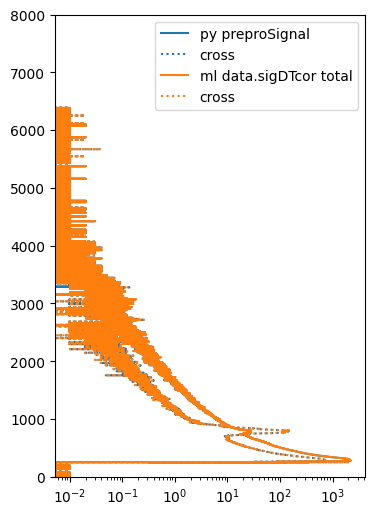

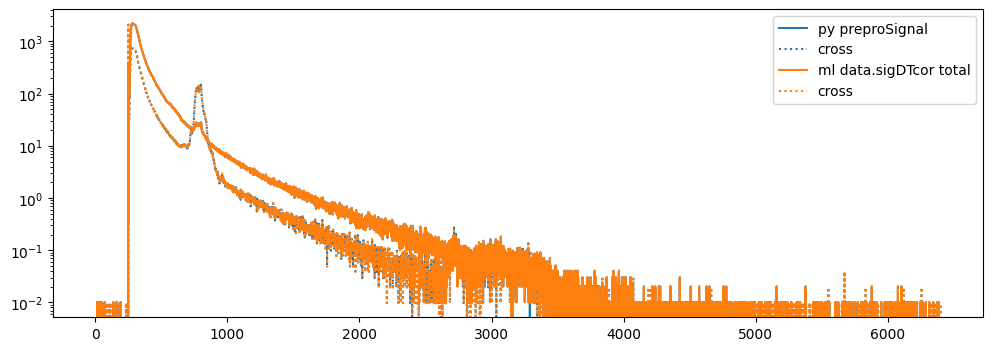

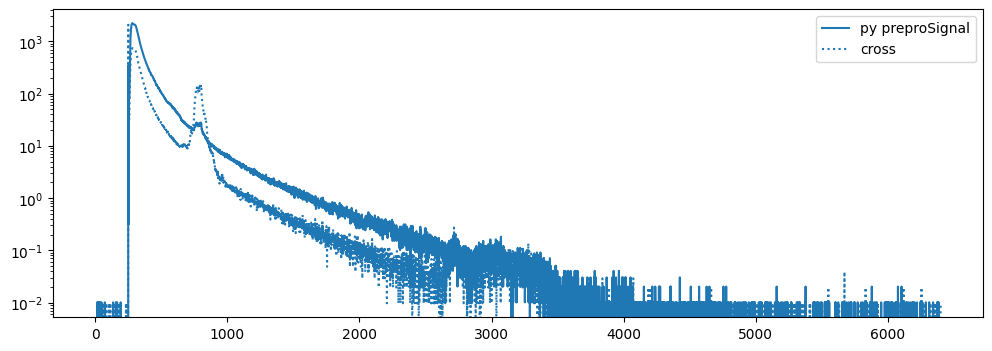

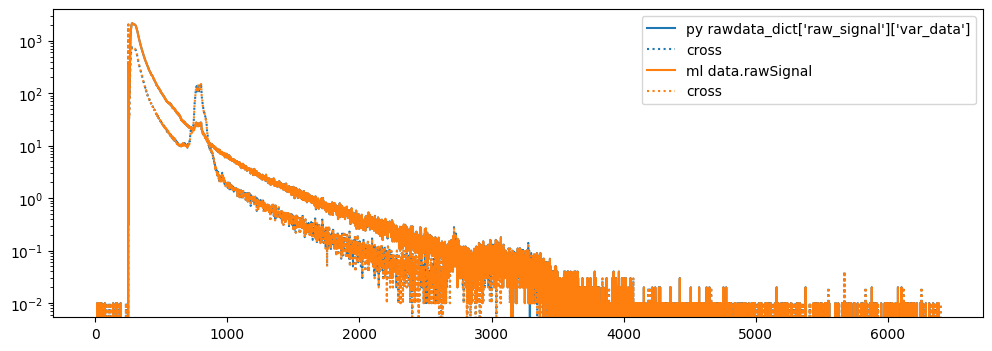

In [16]:
m_preproSig_532_total = np.mean(data_cube.data_retrievals['preproSignal'][39:139,:,4], axis=0)
m_preproSig_532_cross = np.mean(data_cube.data_retrievals['preproSignal'][39:139,:,5], axis=0)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(m_preproSig_532_total, np.arange(6400), color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, np.arange(6400), color='C0', ls=':', label='cross')

ax.plot(comp_ml['sigDTcor_532t_40_140'], np.arange(6400), color='C1', label='ml data.sigDTcor total')
ax.plot(comp_ml['sigDTcor_532c_40_140'], np.arange(6400), color='C1', ls=':', label='cross')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(m_preproSig_532_total, color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, color='C0', ls=':', label='cross')

ax.plot(comp_ml['sigDTcor_532t_40_140'], color='C1', label='ml data.sigDTcor total')
ax.plot(comp_ml['sigDTcor_532c_40_140'], color='C1', ls=':', label='cross')

ax.set_yscale('log')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(m_preproSig_532_total, color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, color='C0', ls=':', label='cross')

ax.set_yscale('log')
ax.legend()

rawsig_532_total = np.mean(data_cube.rawdata_dict['raw_signal']['var_data'][39:139,:,4], axis=0)
rawsig_532_cross = np.mean(data_cube.rawdata_dict['raw_signal']['var_data'][39:139,:,5], axis=0)
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(rawsig_532_total, color='C0', label="py rawdata_dict['raw_signal']['var_data']")
ax.plot(rawsig_532_cross, color='C0', ls=':', label='cross')

ax.plot(comp_ml['rawsig532t_40_140'], color='C1', label='ml data.rawSignal')
ax.plot(comp_ml['rawsig532c_40_140'], color='C1', ls=':', label='cross')

# ax.plot(comp_ml['readrawsig532t_40_140'], color='C2', label='ml read data.rawSignal')
# ax.plot(comp_ml['readrawsig532c_40_140'], color='C2', ls=':', label='cross')


# ax.set_ylim(0, 6000)
ax.set_yscale('log')
ax.legend()

In [17]:
len(data_cube.data_retrievals['time'])

2880

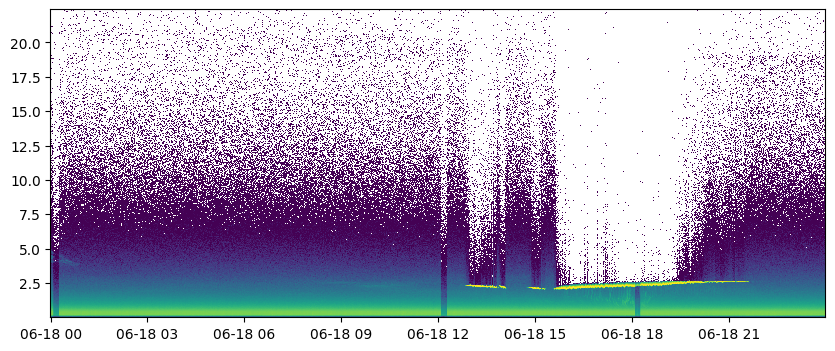

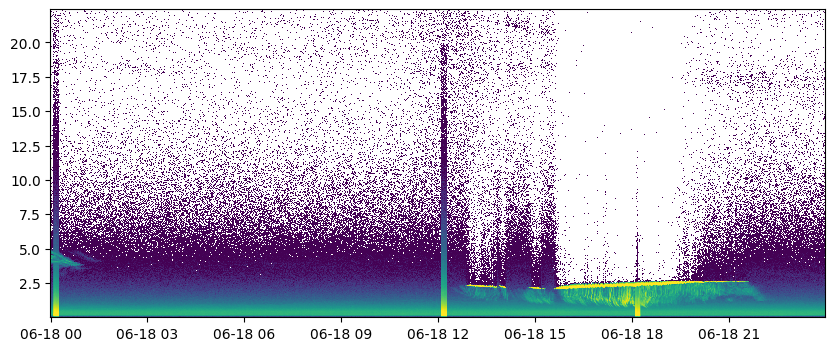

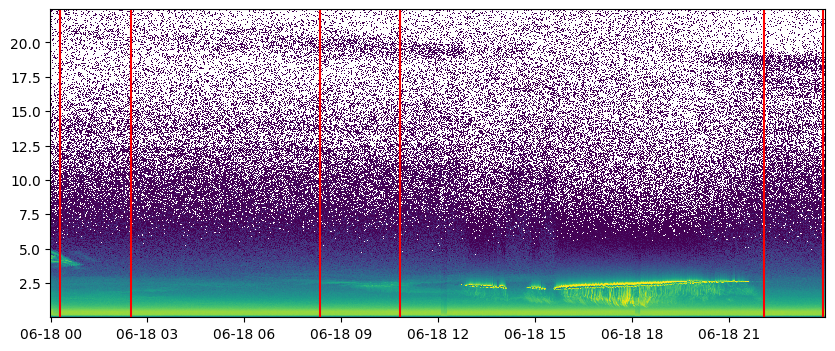

In [18]:
fig, ax = plt.subplots(1, figsize=(10, 4))
pcmesh = ax.pcolormesh(
    data_cube.data_retrievals['time64'], np.array(data_cube.data_retrievals['height'])/1000, 
    data_cube.data_retrievals['sigBGCor'][:,:,4].T, shading='nearest',
    norm=matplotlib.colors.LogNorm(vmin=5, vmax=1e4),
    )

fig, ax = plt.subplots(1, figsize=(10, 4))
pcmesh = ax.pcolormesh(
    data_cube.data_retrievals['time64'], np.array(data_cube.data_retrievals['height'])/1000, 
    data_cube.data_retrievals['sigBGCor'][:,:,5].T, shading='nearest',
    norm=matplotlib.colors.LogNorm(vmin=5, vmax=1e4),
    )

fig, ax = plt.subplots(1, figsize=(10, 4))
pcmesh = ax.pcolormesh(
    data_cube.data_retrievals['time64'], np.array(data_cube.data_retrievals['height'])/1000, 
    data_cube.data_retrievals['sigBGCor'][:,:,7].T, shading='nearest',
    norm=matplotlib.colors.LogNorm(vmin=5, vmax=1e4),
    )

ax.axvline(data_cube.data_retrievals['time64'][35], color='r')
ax.axvline(data_cube.data_retrievals['time64'][300], color='r')

ax.axvline(data_cube.data_retrievals['time64'][1000], color='r')
ax.axvline(data_cube.data_retrievals['time64'][1300], color='r')

ax.axvline(data_cube.data_retrievals['time64'][2650], color='r')
ax.axvline(data_cube.data_retrievals['time64'][2870], color='r')

# ax.set_ylim(top=6)
# cbar = fig.colorbar(pcmesh)
# ax.set_xlabel(f"Time", fontsize=10)
# ax.set_ylabel("Height [km]", fontsize=10)
# cbar.ax.set_ylabel(f"Signal Ch. {ich} ({picassointerface.short_label(channel_labels[ich])})", fontsize=10)
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=3))
# ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=[0,15,30,45]))
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

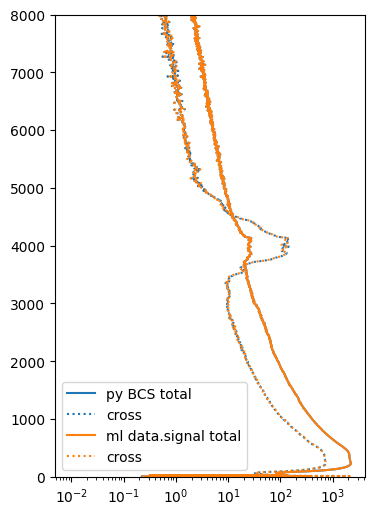

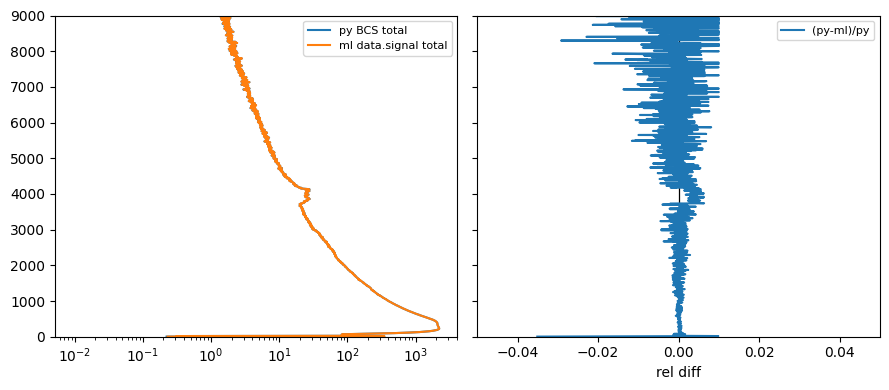

In [19]:
mean_532_total = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,4], axis=0)
mean_532_cross = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,5], axis=0)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py BCS total')
ax.plot(mean_532_cross, np.array(data_cube.data_retrievals['height']), color='C0', ls=':', label='cross')

ax.plot(comp_ml['sig532t_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', label='ml data.signal total')
ax.plot(comp_ml['sig532c_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', ls=':', label='cross')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend()



fig, (ax, ax1) = plt.subplots(1,2, figsize=(9,4), sharey=True)
ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py BCS total')
ax.plot(comp_ml['sig532t_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', label='ml data.signal total')

ax.set_ylim(0, 9000)
ax.set_xscale('log')
ax.legend(fontsize=8)

reldiff = (mean_532_total - comp_ml['sig532t_40_140'])/mean_532_total
ax1.axvline(0, lw=0.9, color='k')
ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
ax1.legend(fontsize=8)
ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
fig.tight_layout()
# # fig.savefig('mSig_rayleigh_fit.png')
# print('mSig', mSig[:20])


In [20]:
# data_cube.rawdata_dict['raw_signal']['var_data'].shape


In [21]:
print(data_cube.rawdata_dict.keys())

dict_keys(['filename', 'global_attributes', 'raw_signal', 'measurement_shots', 'measurement_time', 'depol_cal_angle', 'measurement_height_resolution', 'laser_rep_rate', 'laser_power', 'laser_flashlamp', 'location_height', 'location_coordinates', 'neutral_density_filter', 'if_center', 'if_fwhm', 'polstate', 'telescope', 'deadtime_polynomial', 'deadtime_polynomial_error', 'discr_level', 'pm_voltage', 'pinhole', 'zenithangle'])


In [22]:
print(data_cube.data_retrievals.keys())

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'avail_optical_profiles', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])


In [23]:
print(data_cube.channel_dict)

{0: '355_total_FR', 1: '355_cross_FR', 2: '387_total_FR', 3: '407_total_FR', 4: '532_total_FR', 5: '532_cross_FR', 6: '607_total_FR', 7: '1064_total_FR', 8: '532_total_NR', 9: '607_total_NR', 10: '355_total_NR', 11: '387_total_NR', 12: '532_cross_DFOV'}


In [24]:
#time = datetime.datetime.timestamp(datetime.datetime.now(datetime.timezone.utc))
print(data_cube.date)
data_cube.data_retrievals['time'][0], data_cube.data_retrievals['time'][-1] 

20230618


(1687039200, 1687125570)

In [25]:
data_cube.data_retrievals.keys()

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'avail_optical_profiles', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])

In [26]:
pol_cali = data_cube.polarizationCaliD90()

2025-02-28 17:48:02,842 - INFO - and even a 355 channel


starting loadGHK
data_cube keys  dict_keys(['rawdata_dict', 'polly_config_dict', 'picasso_config_dict', 'polly_default_dict', 'device', 'location', 'date', 'num_of_channels', 'num_of_profiles', 'data_retrievals', 'channel_dict', 'flags', 'flag_355_total_FR', 'flag_355_cross_FR', 'flag_355_parallel_FR', 'flag_355_total_NR', 'flag_387_total_FR', 'flag_387_total_NR', 'flag_407_total_FR', 'flag_407_total_NR', 'flag_532_total_FR', 'flag_532_cross_FR', 'flag_532_parallel_FR', 'flag_532_total_NR', 'flag_532_cross_DFOV', 'flag_532_rr_FR', 'flag_607_total_FR', 'flag_607_total_NR', 'flag_1058_total_FR', 'flag_1064_total_FR', 'flag_1064_cross_FR', 'flag_1064_total_NR'])
dict_keys(['flagCorrectFalseMShots', 'flagFilterFalseMShots', 'flagForceMeasTime', 'flagDTCor', 'flagSigTempCor', 'flagLCCalibration', 'flagDepolCali', 'flagWVCalibration', 'flagUsePreviousDepolCali', 'flagUsePreviousWVconst', 'flagUsePreviousLC', 'flagUseManualRefH', 'flagUseSameRefH', 'flagAutoscaleRCS', 'flagMolDepolCali', 'fla

2025-02-28 17:48:04,373 - INFO - pol_cali_355   {'eta': [19.368004950992564, 19.383862762618218, 19.584783259138838], 'eta_std': [0.3166830091178766, 0.3188415168891194, 0.34238582686093944], 'time_start': [1687039590, 1687082790, 1687104390], 'time_end': [1687040100, 1687083300, 1687104900], 'status': 1, 'eta_best': 19.368004950992564}
2025-02-28 17:48:04,377 - INFO - and even a 532 channel
2025-02-28 17:48:04,693 - INFO - pol_cali_532   {'eta': [28.495192182593424, 28.629563547942197, 28.788420363902958], 'eta_std': [0.40439422050359847, 0.38720256993168667, 0.34168484617132816], 'time_start': [1687039590, 1687082790, 1687104390], 'time_end': [1687040100, 1687083300, 1687104900], 'status': 1, 'eta_best': 28.788420363902958}
2025-02-28 17:48:04,696 - WARNING - calibrateGHK no 1064 channel


In [27]:
# dict(pol_cali[532][-1])

import pickle

# savestr = f"{starttime:%Y%m%d_%H%M}_polCali532_python.pickle"
savestr = f"20230618_HHMM_polCali532_python.pickle"

# with open(savestr, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    # pickle.dump(dict(pol_cali[532][-1]), f, pickle.HIGHEST_PROTOCOL)

In [28]:
# data_cube.cloudScreen and
# data_cube.cloudFreeSeg are not implemented yet.
# For testing reasons set the intervals manually:

data_cube.cloudFreeSeg()
data_cube.clFreeGrps = [
    [35, 300],
    [1000, 1300],
    [2650, 2870]
]

In [29]:
data_cube.polly_config_dict['meteorDataSource'] = 'nc_cloudnet'
data_cube.polly_config_dict['meteo_folder'] = '/mnt/c/Users/radenz/localdata/coala/model_ecmwf'
data_cube.polly_config_dict['meteo_file'] = ".*/{0:%Y}/{0:%Y%m%d}.*.nc"

data_cube.loadMeteo()

candidates  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230616_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230617_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230619_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230620_neumayer_ecmwf.nc']
regex  re.compile('.*/2023/20230618.*.nc')
filename  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc']


<xarray.Dataset> Size: 9MB
Dimensions:      (time: 97, height: 3000)
Coordinates:
  * height       (height) float64 24kB 3.75 11.22 18.69 ... 2.24e+04 2.241e+04
  * time         (time) datetime64[ns] 776B 2023-06-18 ... 2023-06-19
Data variables:
    temperature  (time, height) float64 2MB 248.8 249.0 249.4 ... 184.9 184.9
    pressure     (time, height) float64 2MB 9.883e+04 9.88e+04 ... 2.685e+03
    rh           (time, height) float64 2MB 0.7718 0.7593 ... 0.6816 0.681
    q            (time, height) float64 2MB 0.0003288 0.0003281 ... 2.079e-06
Attributes:
    source:               ECMWF Integrated Forecast System (IFS)
    institution:          European Centre for Medium-Range Weather Forecasting
    initialization_time:  2023-06-18 00:00:00 +00:00
    Conventions:          CF-1.8
    title:                ECMWF IFS single-site output over Neumayer III
    location:             Neumayer III
    file_uuid:            7df280a3-bc0c-4ae6-8df6-ff0bfc201570
    cloudnet_file_type:   mo

(-100.0, 1000.0)

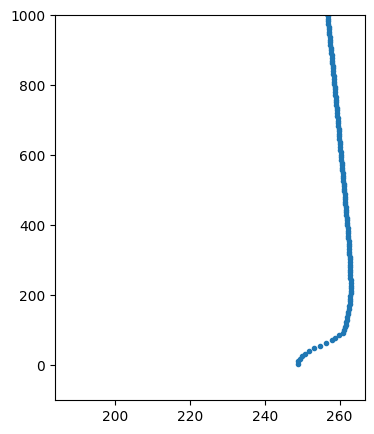

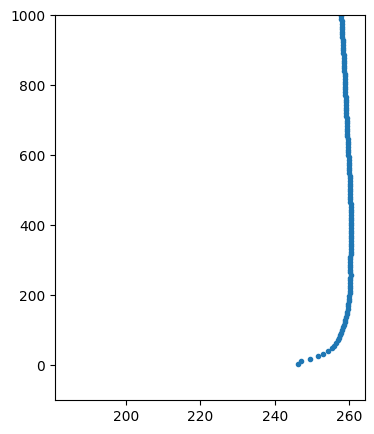

In [30]:
print(data_cube.met.ds)

fig, ax = plt.subplots(figsize=(4,5))
ax.plot(data_cube.met.ds.isel(time=0)['temperature'], data_cube.met.ds.height, '.')
ax.set_ylim(-100, 1000)

fig, ax = plt.subplots(figsize=(4,5))
ax.plot(data_cube.met.ds.isel(time=-1)['temperature'], data_cube.met.ds.height, '.')
ax.set_ylim(-100, 1000)

## Molecular profiles comparison

For profiles that are averaged over multiple hours it would be more correct to use the averaged
profiles of temperature and humidity instead of the nearest one at the midpoint (as done in matlab).


The averaging procedure is implemented in the `data_cube.calcMolecular()` function:
```
time slices of cloud free  [array(['2023-06-18T00:17:30.000000', '2023-06-18T02:30:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T08:20:00.000000', '2023-06-18T10:50:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T22:05:00.000000', '2023-06-18T23:55:00.000000'],
      dtype='datetime64[us]')]
```
but for the direct comparison with matlab the met profiles have to be 'degraded'.


In [31]:
# data_cube.calcMolecular()

from datetime import datetime,timedelta
def date_mid(first,second):
    return first + (second-first)*0.5

def round_to_hour(dt64):
    t = dt64.astype(datetime)
    t = t.replace(second=0, microsecond=0, minute=0, hour=t.hour)+timedelta(hours=t.minute//30)
    return np.datetime64(t)

time_slices = [round_to_hour(date_mid(*data_cube.data_retrievals['time64'][grp])) for grp in data_cube.clFreeGrps]
# time_slices = [date_mid(*data_cube.data_retrievals['time64'][grp]).astype('datetime64[h]') for grp in data_cube.clFreeGrps]
print(time_slices)
met_profiles = [data_cube.met.ds.sel(time=t, method='nearest') for t in time_slices]
# print(met_profiles)
import lib.misc.molecular as molecular
data_cube.mol_profiles = molecular.calc_profiles(met_profiles)

# data_cube.calcMolecular()

[np.datetime64('2023-06-18T01:00:00.000000'), np.datetime64('2023-06-18T10:00:00.000000'), np.datetime64('2023-06-18T23:00:00.000000')]
len mean_profiles 3
shape of the molecular scattering (3, 3000)
for the wavelengths  [355, 387, 407, 532, 607, 1058, 1064]


In [32]:
time_slices = [data_cube.data_retrievals['time64'][grp].tolist() for grp in data_cube.clFreeGrps]

print(time_slices)

[[datetime.datetime(2023, 6, 18, 0, 17, 30), datetime.datetime(2023, 6, 18, 2, 30)], [datetime.datetime(2023, 6, 18, 8, 20), datetime.datetime(2023, 6, 18, 10, 50)], [datetime.datetime(2023, 6, 18, 22, 5), datetime.datetime(2023, 6, 18, 23, 55)]]


In [33]:
print(data_cube.mol_profiles.keys())


dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])


In [34]:
m_reference = np.load('20230618_0000_rayleigh_cal_testinterval_matlab.npz')

print(m_reference.files)
print(m_reference['cloud_free'])

m_py = data_cube.mol_profiles
print(m_py.keys())

['height', 'number_density', 'cloud_free', 'mBsc355', 'mExt355', 'mBsc387', 'mExt387', 'mBsc407', 'mExt407', 'mBsc532', 'mExt532', 'mBsc607', 'mExt607', 'mBsc1064', 'mExt1064']
[[  36  301]
 [1001 1301]
 [2651 2871]]
dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])


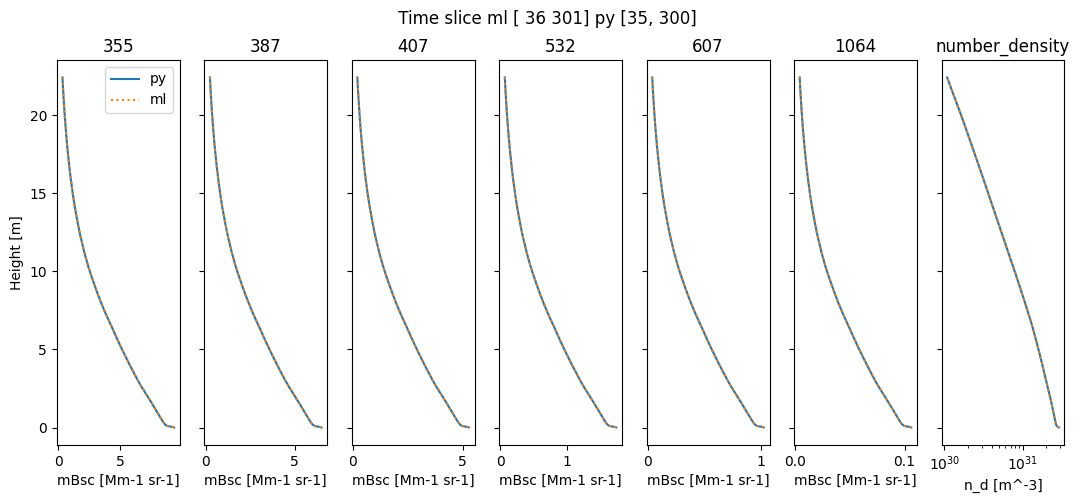

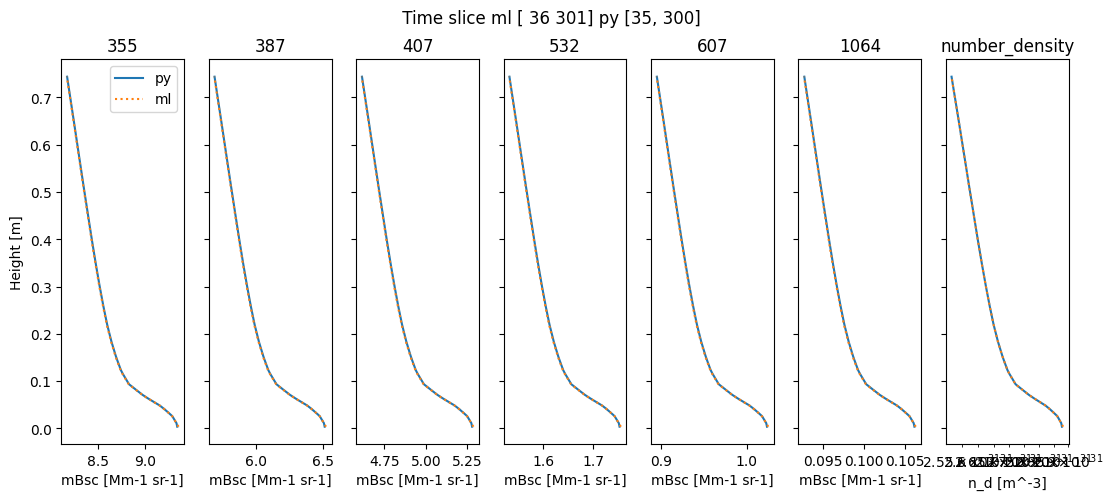

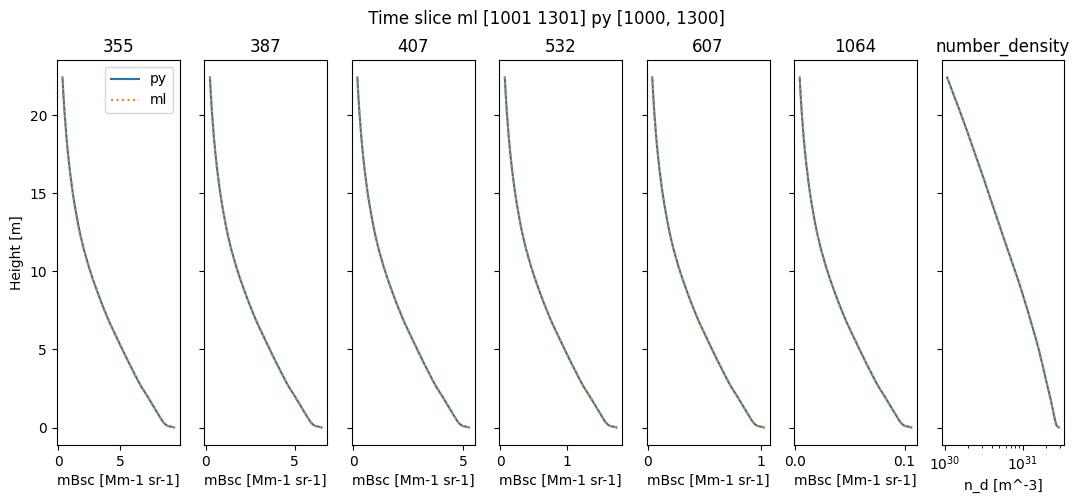

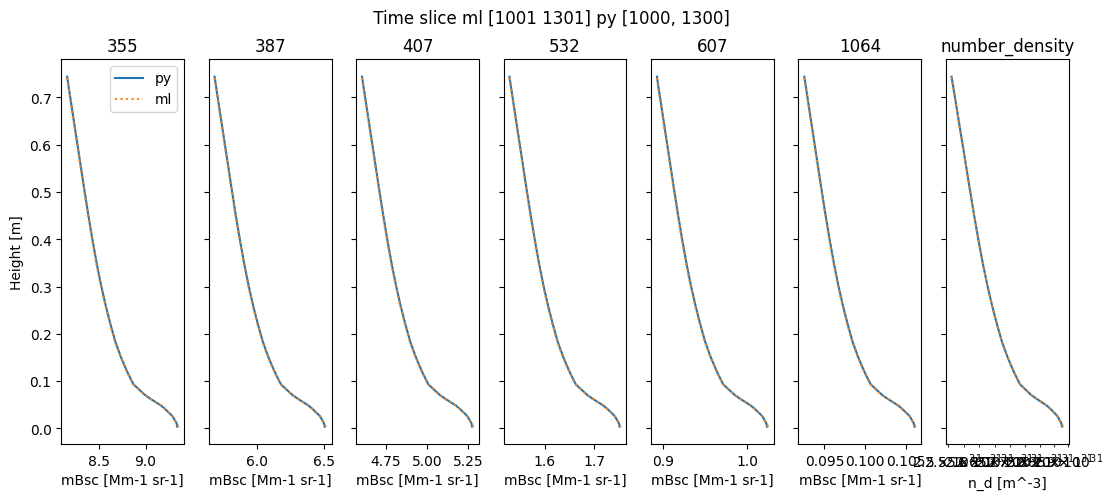

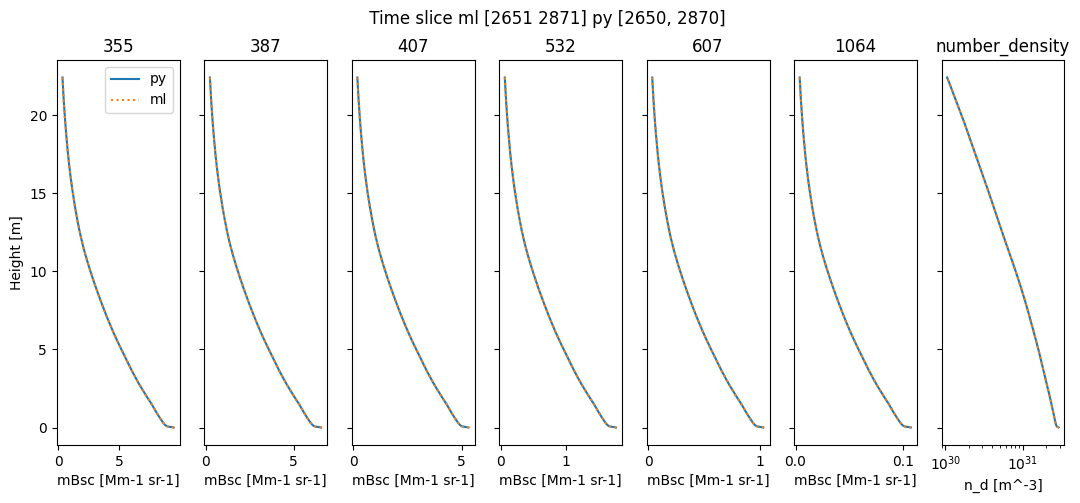

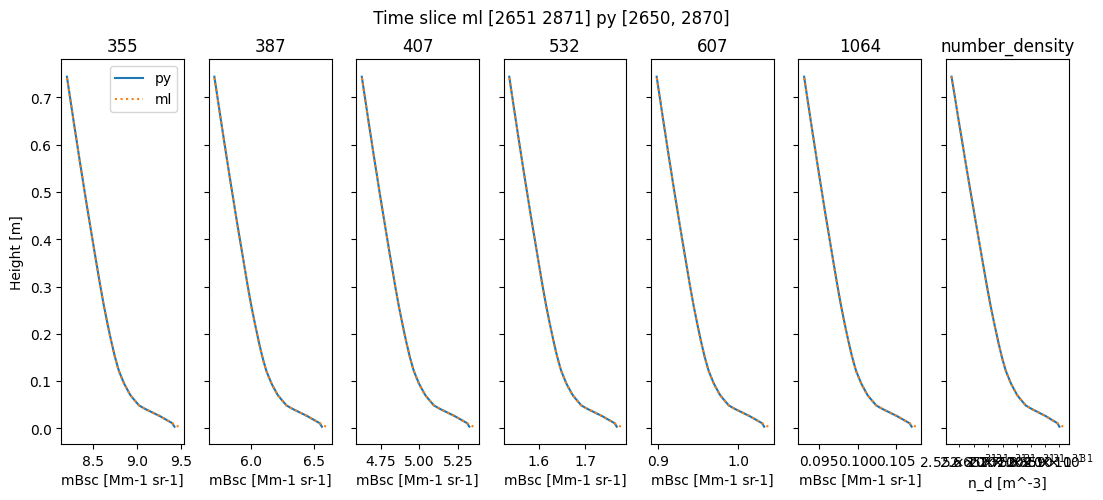

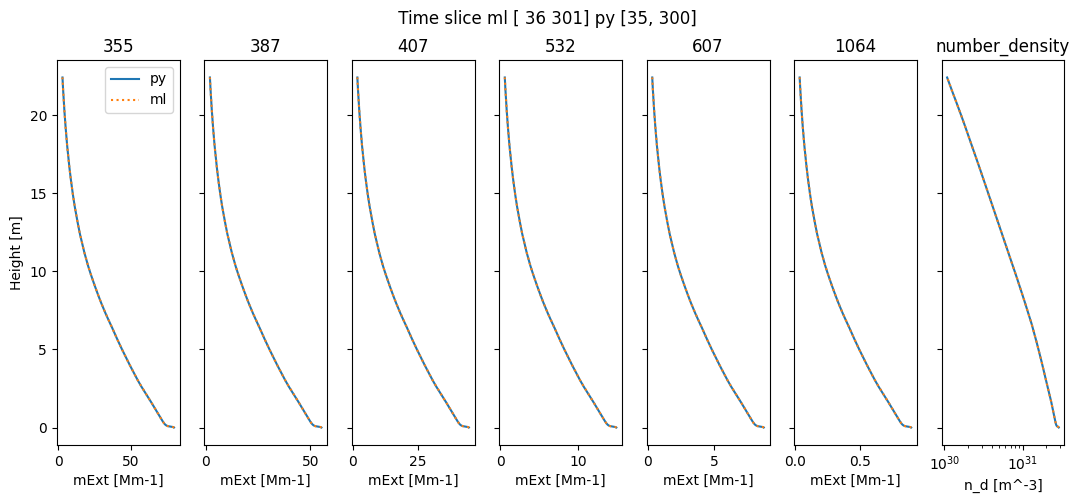

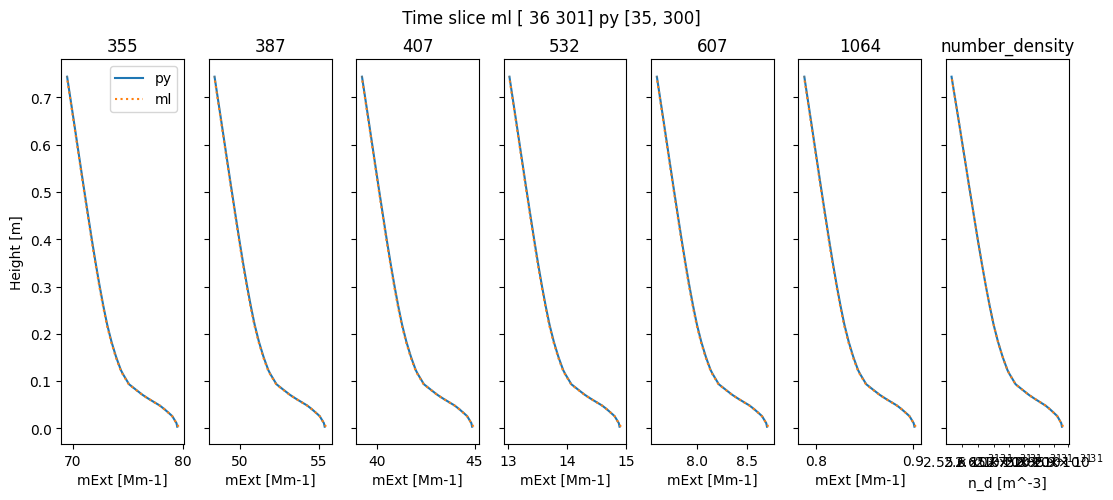

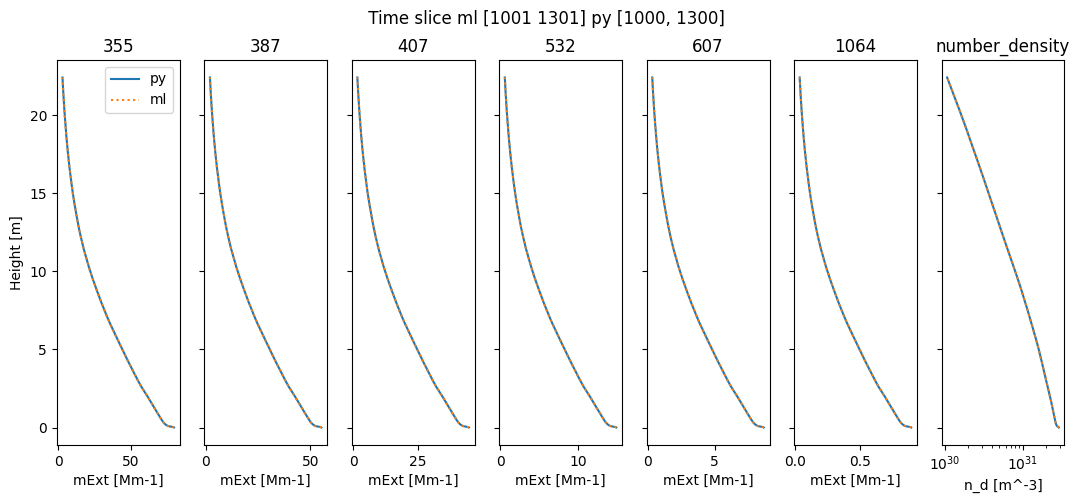

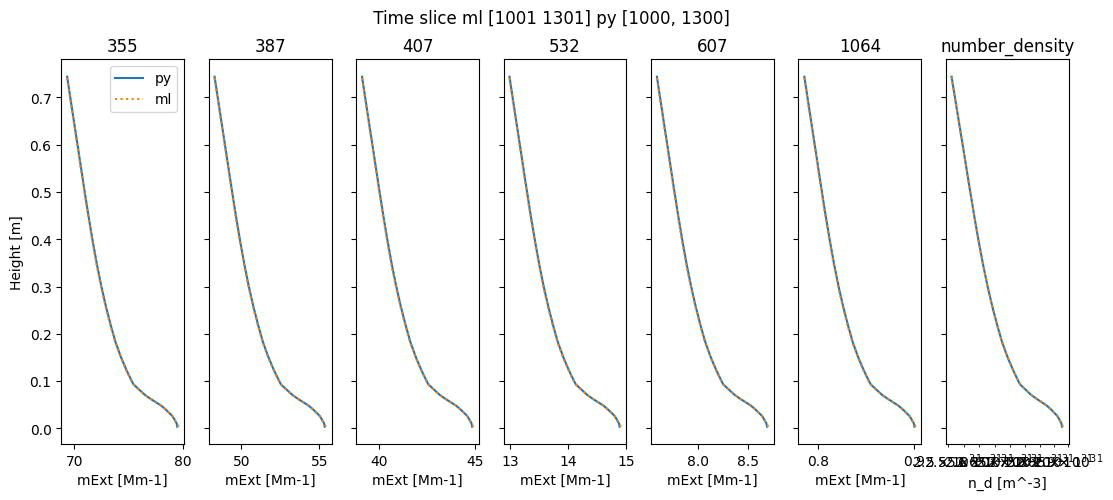

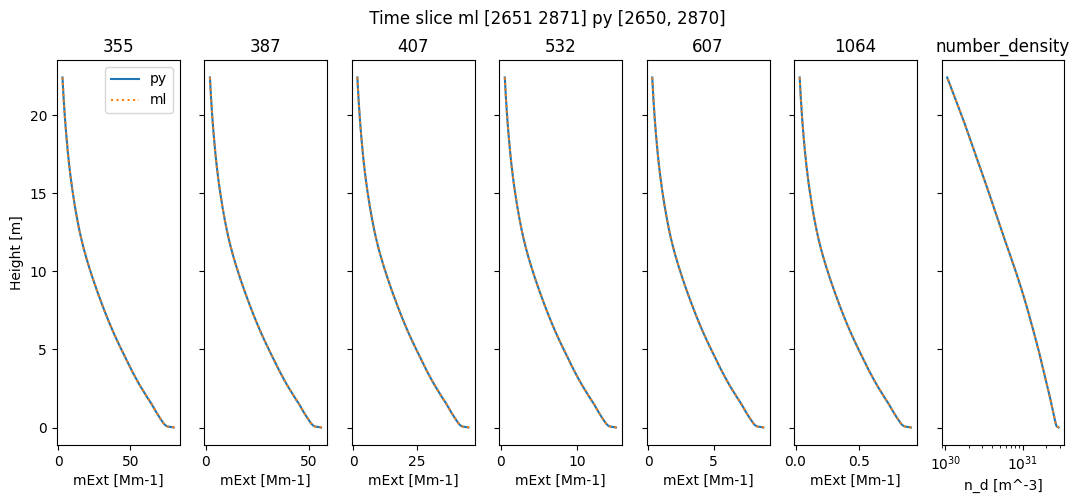

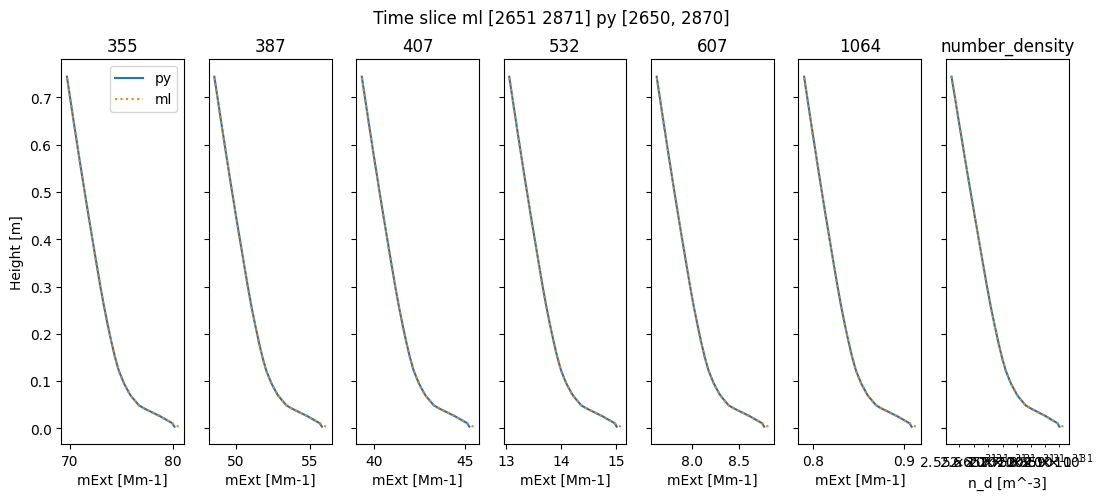

In [35]:
comparisons = [
    ['mBsc', 0, -1],
    ['mBsc', 0, 100],
    ['mBsc', 1, -1],
    ['mBsc', 1, 100],
    ['mBsc', 2, -1],
    ['mBsc', 2, 100],
    ['mExt', 0, -1],
    ['mExt', 0, 100],
    ['mExt', 1, -1],
    ['mExt', 1, 100],
    ['mExt', 2, -1],
    ['mExt', 2, 100],
]

for var, icld, imax in comparisons:
    # print(m_reference['height'])
    fig, ax = plt.subplots(1,7 ,figsize=(13,5), sharey=True)
    ax[0].plot(m_py[f'{var}_355'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-', label='py')
    ax[0].plot(m_reference[f'{var}355'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':', label='ml')
    ax[0].set_ylabel('Height [m]')
    ax[0].legend()
    ax[0].set_title('355')
    
    ax[1].plot(m_py[f'{var}_387'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[1].plot(m_reference[f'{var}387'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[1].set_title('387')
    
    ax[2].plot(m_py[f'{var}_407'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[2].plot(m_reference[f'{var}407'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[2].set_title('407')
    
    ax[3].plot(m_py[f'{var}_532'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[3].plot(m_reference[f'{var}532'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[3].set_title('532')
    
    ax[4].plot(m_py[f'{var}_607'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[4].plot(m_reference[f'{var}607'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[4].set_title('607')
    
    ax[5].plot(m_py[f'{var}_1064'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[5].plot(m_reference[f'{var}1064'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[5].set_title('1064')
    
    for i in range(0,6):
        if var == 'mBsc':
            ax[i].set_xlabel(f'{var} [Mm-1 sr-1]')
        elif var == 'mExt':
            ax[i].set_xlabel(f'{var} [Mm-1]')
    
    ax[6].plot(m_py['number_density'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[6].plot(m_reference['number_density'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[6].set_xlabel('n_d [m^-3]')
    ax[6].set_title('number_density')
    ax[6].set_xscale('log')
    
    # ax[0].set_ylim(0, 1000)
    fig.suptitle(f" Time slice ml {m_reference['cloud_free'][icld]} py {data_cube.clFreeGrps[icld]}")
    
    fig.savefig(f"{var}_icld_{icld}_hmax_{data_cube.met.ds.height[imax].values:.0f}.png")

    

In [36]:
m_py = data_cube.mol_profiles

m_py.keys()

dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])

dict_keys(['sig532', 'bg532', 'nShots532', 'pcr532', 'height', 'rcs532', 'scaRatio', 'mSig532'])
mSig [1.75231914e-06 1.75044542e-06 1.74579573e-06 1.74116209e-06
 1.73290531e-06 1.72440861e-06 1.71501904e-06 1.70285833e-06
 1.69084950e-06 1.67964721e-06 1.67020230e-06 1.66084800e-06
 1.65158368e-06 1.64696938e-06 1.64241038e-06 1.63786844e-06
 1.63390811e-06 1.63098349e-06 1.62806403e-06 1.62514972e-06]


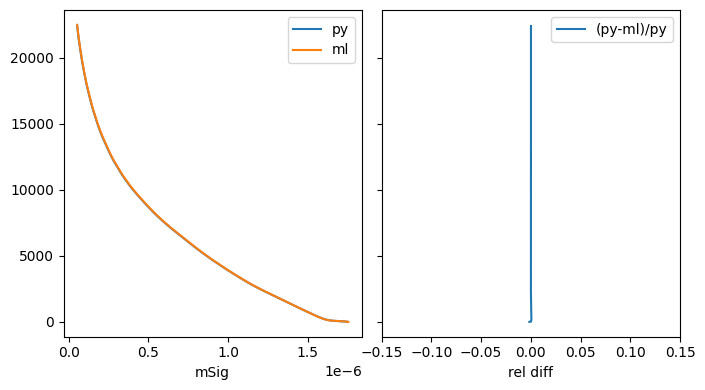

In [37]:
# rcs, mSig, scaRatio = data_cube.rayleighFit()

i = 0
height = data_cube.data_retrievals['range']
mSig = (
    data_cube.mol_profiles[f'mBsc_532'][i,:] * \
    np.exp(-2 * np.cumsum(data_cube.mol_profiles[f'mExt_532'][i,:] * np.concatenate(([height[0]], np.diff(height))))))



with open('20230618_0000_pcr_rcs_matlab.pickle', 'rb') as f:
    pcr_rcs_ml = pickle.load(f)
print(pcr_rcs_ml.keys())

# imax = 200
imax = -1

# im = 3000


fig, (ax, ax1) = plt.subplots(1,2,figsize=(7,4), sharey=True)
ax.plot(mSig[:imax], data_cube.data_retrievals['height'][:imax], label='py')
ax.plot(pcr_rcs_ml['mSig532'][:imax], pcr_rcs_ml['height'][:imax], label='ml')
ax.legend()
ax.set_xlabel('mSig')

reldiff = (mSig[:imax] - pcr_rcs_ml['mSig532'][:imax])/mSig[:imax]
ax1.plot(reldiff, data_cube.data_retrievals['height'][:imax], label='(py-ml)/py')
ax1.legend()
ax1.set_xlim(-0.15, 0.15); ax1.set_xlabel('rel diff')
fig.tight_layout()
# fig.savefig('mSig_rayleigh_fit.png')
print('mSig', mSig[:20])


# # rcs = np.nanmean(np.squeeze(
# #     data_cube.data_retrievals['RCS'][slice(*cldFree),:,data_cube.gf(532, 'total', 'FR')]), axis=0)


# fig, ax = plt.subplots(1 ,figsize=(6,4))

# ax.plot(np.squeeze(data_cube.data_retrievals['RCS'][35,:,data_cube.gf(532, 'total', 'FR')])[:imax], 
#         data_cube.data_retrievals['height'][:imax], color='grey', label='py single profile')
# ax.plot(rcs[:imax], data_cube.data_retrievals['height'][:imax], label='py averaged')
# ax.plot(pcr_rcs_ml['rcs532'][:imax], pcr_rcs_ml['height'][:imax], label='ml averaged')
# ax.legend()
# ax.set_xlabel('RCS 532')



# pcr_manual = np.mean(np.squeeze(data_cube.data_retrievals['PCR_cor'][35:300,:,data_cube.gf(532, 'total', 'FR')]), axis=0)


# fig, ax = plt.subplots(1 ,figsize=(6,4))
# ax.plot(pcr_manual[250:250+im], 
#         np.arange(6400)[:im], label='py single profile')
# ax.plot(pcr_rcs_ml['pcr532'][:im], np.arange(6400)[:im], ls=':', label='ml averaged')

# # note for continuing:
# # - pcr seems correct with execption of the 250 bins pretrigger
# #


# rcs_manual = pcr_manual[251:3251]*data_cube.data_retrievals['range']**2
# rcs_manual_0based = pcr_manual[250:3250]*data_cube.data_retrievals['range']**2

# fig, (ax, ax1) = plt.subplots(1,2,figsize=(7,4), sharey=True)
# # ax.plot(rcs_manual[:im], 
# #         data_cube.data_retrievals['height'][:im], color='dimgrey', lw=3, label='py manual')
# ax.plot(pcr_rcs_ml['rcs532'][:im], pcr_rcs_ml['height'][:im], '-', lw=3, color='tab:orange', label='ml averaged')
# ax.plot(rcs[:im], data_cube.data_retrievals['height'][:im], '--', lw=1, color='magenta', label='py wrong')
# ax.plot(rcs_manual_0based[:im], data_cube.data_retrievals['height'][:im], '--', lw=1, color='dodgerblue', label='py 0-based')
# ax.legend()
# ax.set_xlabel('RCS 532')
# ax.set_ylabel('Height')

# reldiff = (rcs - pcr_rcs_ml['rcs532'])/rcs
# ax1.axvline(0, lw=0.8, c='k')
# ax1.plot(reldiff[:im], data_cube.data_retrievals['height'][:im], label='(py-ml)/py')
# ax1.plot(smooth_signal(reldiff[:im], 30), data_cube.data_retrievals['height'])
# ax1.legend()
# ax1.set_xlim(-0.15, 0.15); ax1.set_xlabel('rel diff')
# fig.tight_layout()
# # fig.savefig('rcs_rayleigh_fit.png')


# fig, ax1 = plt.subplots(1,figsize=(3,5))
# ax1.axvline(0, lw=0.8, c='k')
# ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
# ax1.plot(smooth_signal(reldiff, 30), data_cube.data_retrievals['height'])
# ax1.legend()
# ax1.set_xlim(-0.1, 0.1); ax1.set_xlabel('rel diff')
# ax1.set_ylabel('Height')
# fig.tight_layout()
# # fig.savefig('rcs_reldiff_rayleigh_fit.png')

# fig, ax = plt.subplots(1 ,figsize=(6,4))
# ax.plot(scaRatio[:imax], data_cube.data_retrievals['height'][:imax], label='py')
# ax.plot(pcr_rcs_ml['scaRatio'][:imax], pcr_rcs_ml['height'][:imax], label='ml')
# ax.legend()
# ax.set_xlabel('scaRatio')

In [38]:
print(pcr_rcs_ml['height'][:10])
print(data_cube.data_retrievals['height'][:10])
print(data_cube.data_retrievals['range'][:10])

[ 3.76432439 11.26432439 18.76432439 26.26432439 33.76432439 41.26432439
 48.76432439 56.26432439 63.76432439 71.26432439]
[ 3.75       11.22146024 18.69292047 26.16438071 33.63584094 41.10730118
 48.57876141 56.05022165 63.52168189 70.99314212]
[ 3.75 11.25 18.75 26.25 33.75 41.25 48.75 56.25 63.75 71.25]


In [39]:
print(data_cube.polly_config_dict['flagUseManualRefH'])
print(data_cube.polly_config_dict[f'refH_FR_355'])
print(data_cube.polly_config_dict[f'refH_FR_532'])
print(data_cube.polly_config_dict[f'refH_FR_1064'])

data_cube.polly_config_dict['flagUseManualRefH'] = False
data_cube.polly_config_dict[f'refH_FR_355'] = [6000, 8000]
data_cube.polly_config_dict[f'refH_FR_532'] = [6000, 8000]
data_cube.polly_config_dict[f'refH_FR_1064'] = [6000, 8000]

False
[]
[]
[]


In [40]:
data_cube.rayleighFit()

2025-02-28 17:49:20,031 - WARNING - Potential for differences to matlab code du to numerical issues (subtraction of two small values)
2025-02-28 17:49:20,033 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-02-28 17:49:20,035 - WARNING - at 10km height this is a difference of about 4 indices


Start Rayleigh Fit
0 [35, 300]
refH for 532
height [  3.75  11.25  18.75  26.25  33.75  41.25  48.75  56.25  63.75  71.25
  78.75  86.25  93.75 101.25 108.75 116.25 123.75 131.25 138.75 146.25
 153.75 161.25 168.75 176.25 183.75 191.25 198.75 206.25 213.75 221.25] epsilon 0.2 height [1000] 10000 maxHThick 1500 window_size 60
hBaseIndx 133 1001.25
hTopIndx 1333 10001.25
DPInd [ 132  332  532  674  874 1074 1274 1332]
0 132 333
Region 0: 993.75 - 2501.25 fails in near and far-Range cross test.
1 332 533
Region 1: 2493.75 - 4001.25 fails in near and far-Range cross test.
2 532 675
Region 2: 3993.75 - 5066.25 fails in near and far-Range cross test.
3 674 875
white noise criterion  674 875
white noise chi2fit input 5.80875 4.951560761312452e-23 1.9742874403589153e-08
white noise chi2fit  2.090198186508026e-08 -3.6738884839759134e-09
all tests succeeded
4 874 1075
white noise criterion  874 1075
white noise chi2fit input 7.308750000000001 1.638229145498056e-22 2.2190806597676752e-08
white no

[{'532_total_FR': {'DPInd': array([ 132,  332,  532,  674,  874, 1074, 1274, 1332]),
   'refHInd': (674, 874)},
  '355_total_FR': {'DPInd': array([ 172,  372,  572,  772,  972, 1172, 1332]),
   'refHInd': (772, 972)},
  '1064_total_FR': {'DPInd': array([ 132,  332,  333,  439,  497,  550,  655,  708,  908, 1038, 1238,
          1332]),
   'refHInd': (708, 908)}},
 {'532_total_FR': {'DPInd': array([ 132,  316,  516,  548,  748,  948, 1148, 1332]),
   'refHInd': (948, 1148)},
  '355_total_FR': {'DPInd': array([ 172,  372,  572,  772,  972, 1172, 1332]),
   'refHInd': (972, 1172)},
  '1064_total_FR': {'DPInd': array([ 132,  216,  308,  357,  421,  583,  783,  983, 1121, 1321, 1332]),
   'refHInd': (583, 783)}},
 {'532_total_FR': {'DPInd': array([ 132,  332,  532,  732,  932, 1132, 1332]),
   'refHInd': (732, 932)},
  '355_total_FR': {'DPInd': array([ 172,  372,  572,  772,  972, 1172, 1332]),
   'refHInd': (772, 972)},
  '1064_total_FR': {'DPInd': array([ 132,  332,  532,  732,  783,  983

(772, 972)
(772, 972)
(674, 874)
(674, 874)
(708, 908)
[675, 875]
[675, 875]
[675, 875]
[675, 875]
(972, 1172)
(972, 1172)
(948, 1148)
(948, 1148)
(583, 783)
[675, 875]
[675, 875]
[675, 875]
[675, 875]
(772, 972)
(772, 972)
(732, 932)


/tmp/ipykernel_1482/919249480.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize=(12,2))


(732, 932)
(532, 732)
[675, 875]
[675, 875]
[675, 875]
[675, 875]


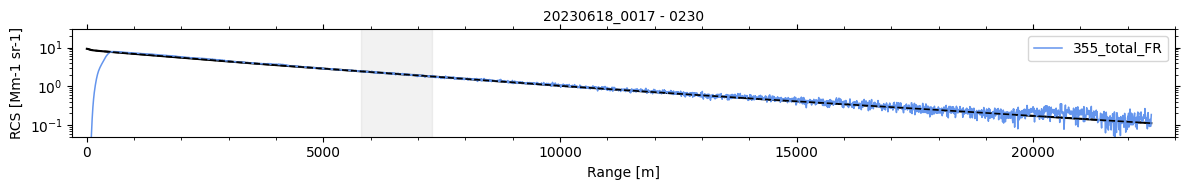

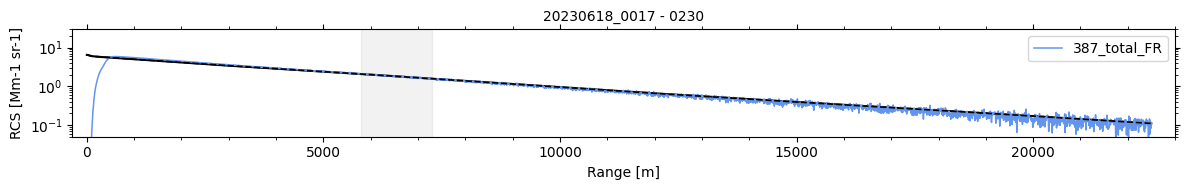

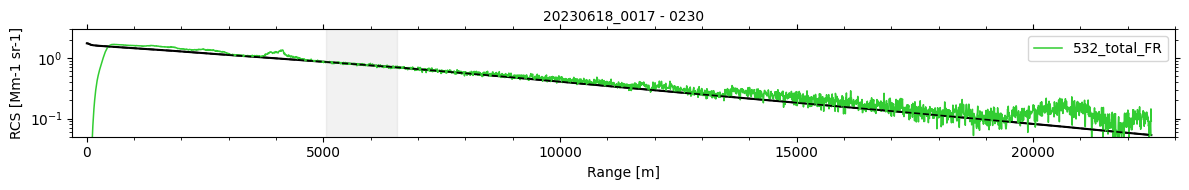

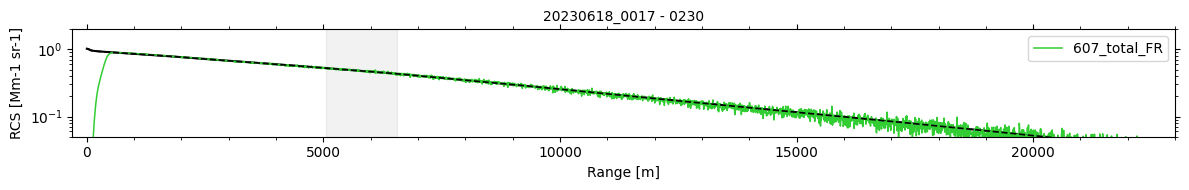

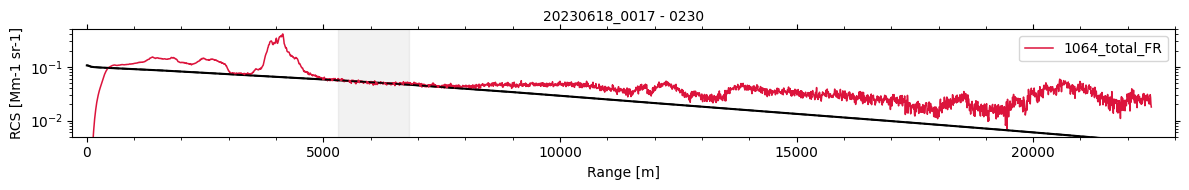

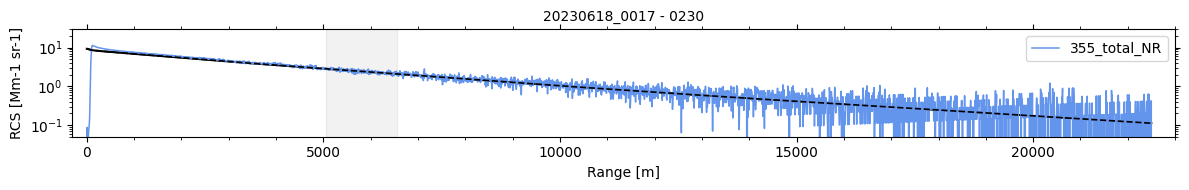

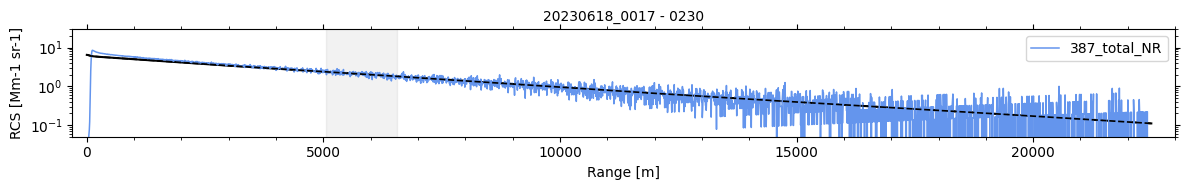

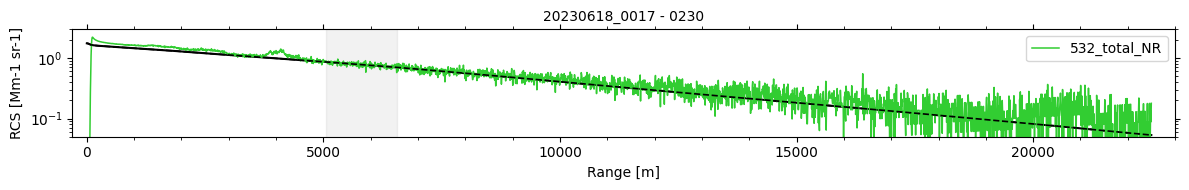

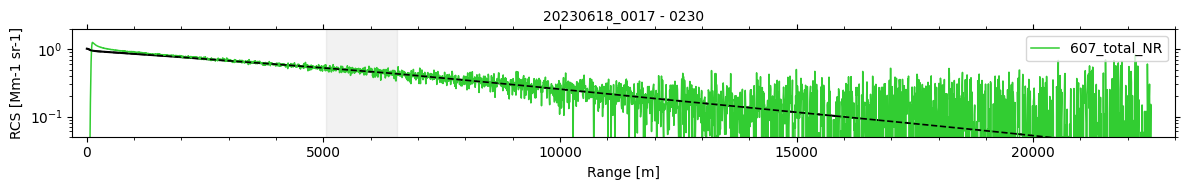

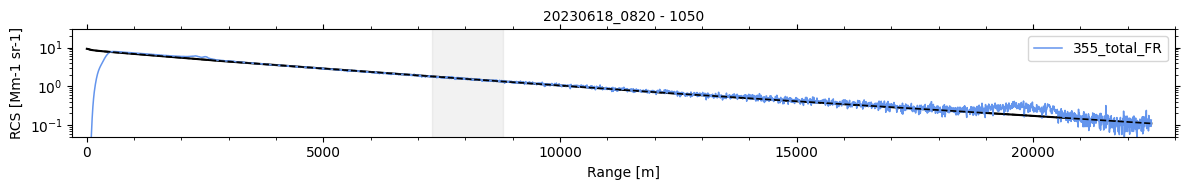

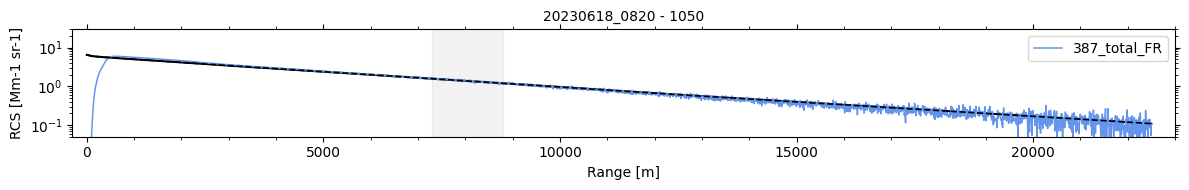

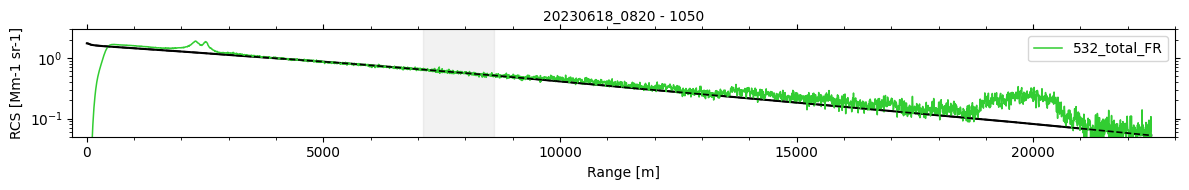

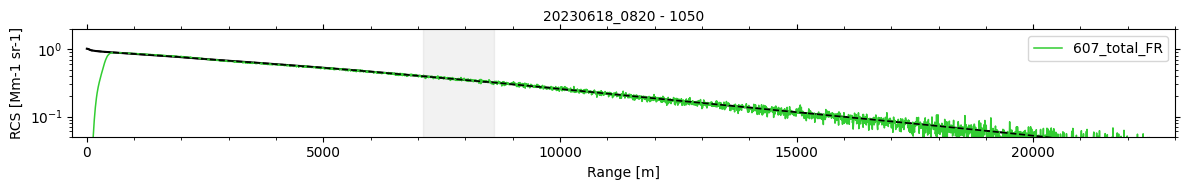

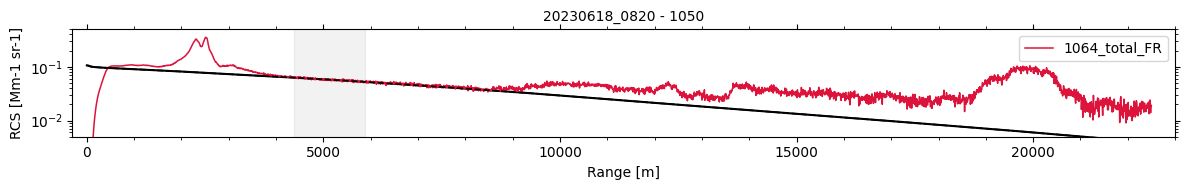

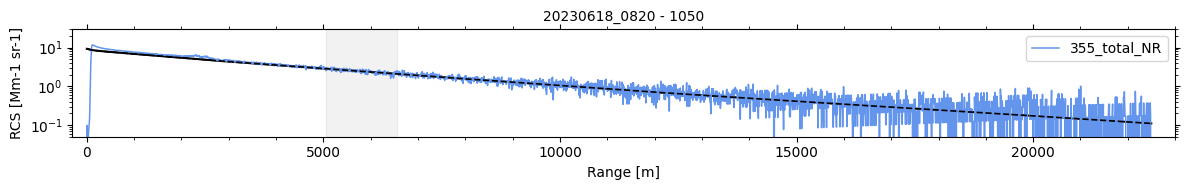

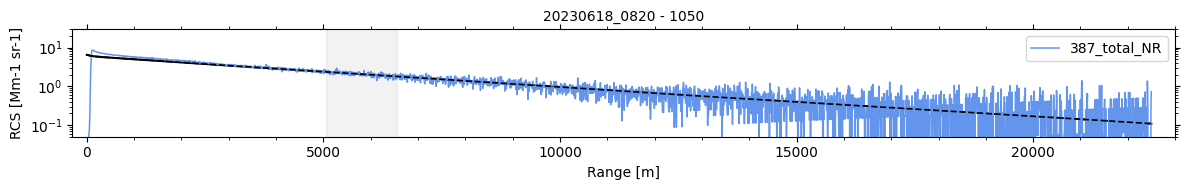

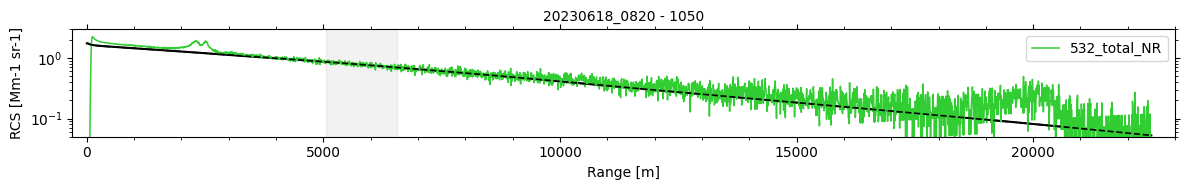

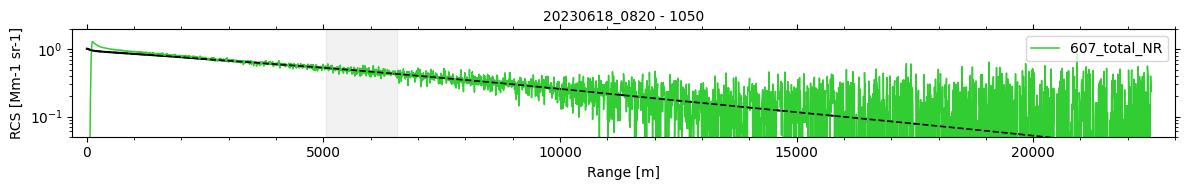

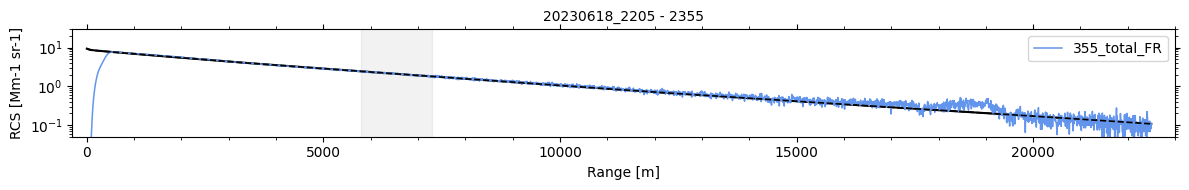

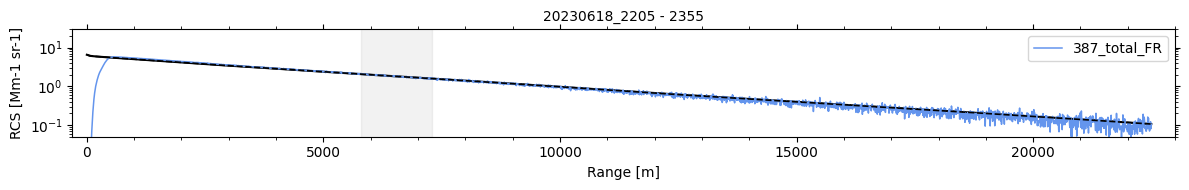

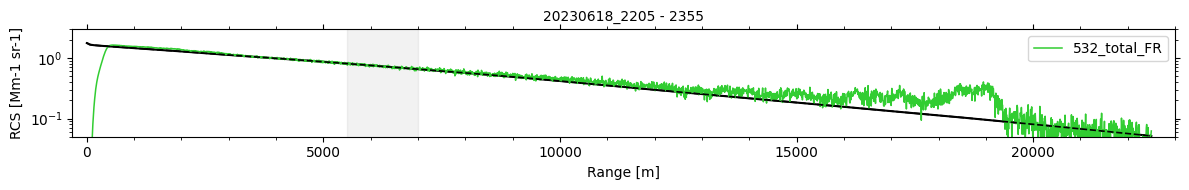

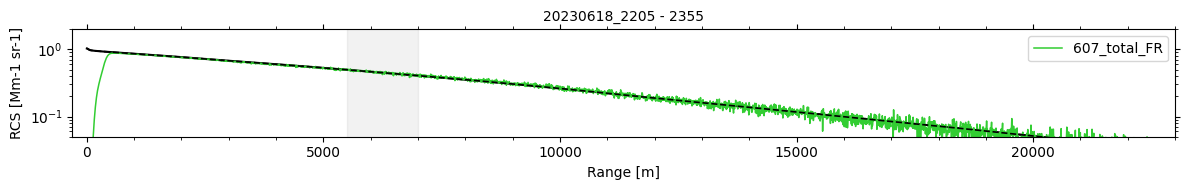

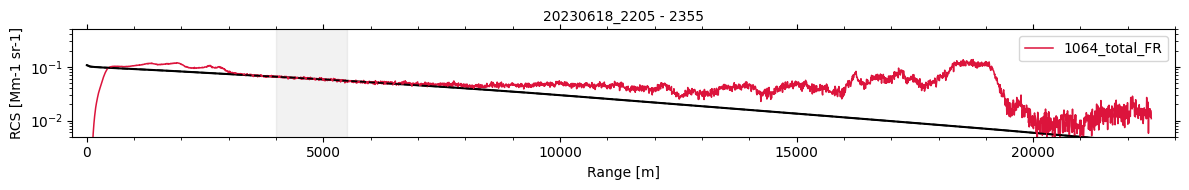

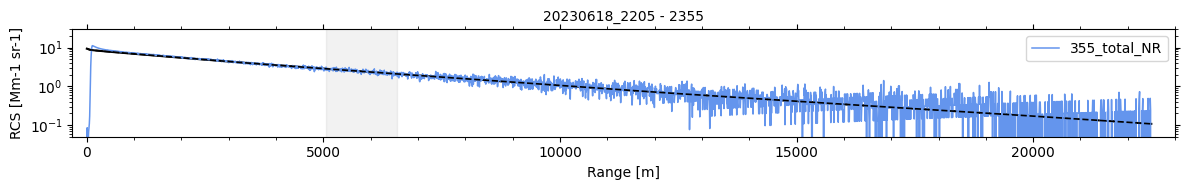

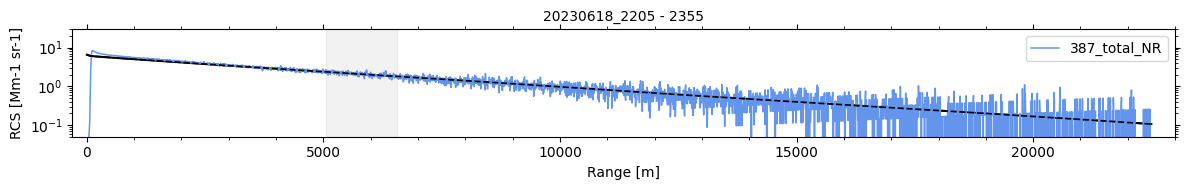

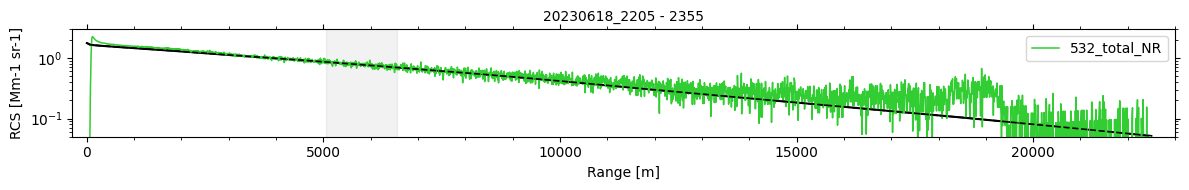

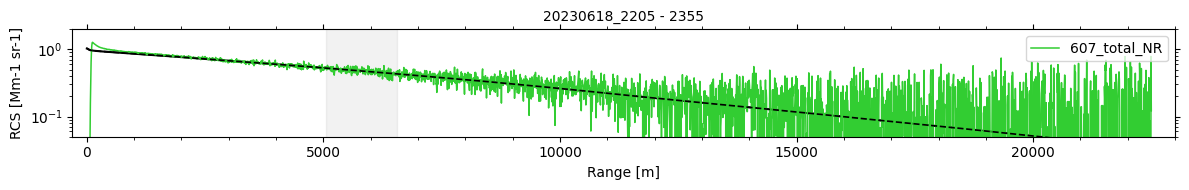

In [41]:
plotprops = {
    '355_total_FR': ['cornflowerblue', [5e-2, 30]],
    '387_total_FR': ['cornflowerblue', [5e-2, 30]],
    '532_total_FR': ['limegreen', [5e-2, 3]],
    '607_total_FR': ['limegreen', [5e-2, 2]],
    '1064_total_FR': ['crimson', [5e-3, 0.5]],

    '355_total_NR': ['cornflowerblue', [5e-2, 30]],
    '387_total_NR': ['cornflowerblue', [5e-2, 30]],
    '532_total_NR': ['limegreen', [5e-2, 3]],
    '607_total_NR': ['limegreen', [5e-2, 2]],
}

refH_wv_mapping = {355: 355, 387:355, 407:355, 532: 532, 607:532, 1064:1064}


# fancily plotting rayleighfits
rg = data_cube.data_retrievals['range']
for i, cldFree in enumerate(data_cube.clFreeGrps):

    for wv in [355, 387, 532, 607, 1064]:
        t, tel = 'total', 'FR'
        channel = f'{wv}_{t}_{tel}'
        pp = plotprops[channel]
        rcs = np.nanmean(np.squeeze(
            data_cube.data_retrievals['RCS'][slice(*cldFree),:,data_cube.gf(wv, t, tel)]), axis=0)
        mSig = (
            data_cube.mol_profiles[f'mBsc_{wv}'][i,:] * \
            np.exp(-2 * np.cumsum(data_cube.mol_profiles[f'mExt_{wv}'][i,:] * np.concatenate(([height[0]], np.diff(height))))))
        # when in doubt take the refernece height from the elastic channel
        refHInd = data_cube.refH[i][f"{refH_wv_mapping[int(wv)]}_{t}_{tel}"]['refHInd']
        factor = np.sum(rcs[slice(*refHInd)])/np.sum(mSig[slice(*refHInd)])
        print(refHInd)

        fig, ax = plt.subplots(1, figsize=(12,2))

        ax.fill_between([rg[refHInd[0]], rg[refHInd[1]]], [100,100],
                color='grey', alpha=0.1)

        ax.plot(rg, mSig*1e6, '-', color='black')
        ax.plot(rg, rcs/factor*1e6, lw=1.1, color=pp[0], label=channel)
        ax.plot(rg, mSig*1e6, '--', lw=1.2, color='black')
        ax.legend(loc='upper right')
        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%H%M}"
        ax.set_title(tstr, fontsize=10)
        ax.set_yscale('log')
        ax.set_ylim(pp[1])
        ax.set_xlim(-300, 23000); ax.set_xlabel('Range [m]')
        ax.set_ylabel('RCS [Mm-1 sr-1]')
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.tick_params(axis='both', which='both', top=True, right=True)
        fig.tight_layout()
        fig.savefig(f"{time_slices[i][0]:%Y%m%d_%H%M}_{channel}_rayleighfit.png", dpi=200)

    for wv in [355, 387, 532, 607]:
        t, tel = 'total', 'NR'
        channel = f'{wv}_{t}_{tel}'
        pp = plotprops[channel]
        rcs = np.nanmean(np.squeeze(
            data_cube.data_retrievals['RCS'][slice(*cldFree),:,data_cube.gf(wv, t, tel)]), axis=0)
        mSig = (
            data_cube.mol_profiles[f'mBsc_{wv}'][i,:] * \
            np.exp(-2 * np.cumsum(data_cube.mol_profiles[f'mExt_{wv}'][i,:] * np.concatenate(([height[0]], np.diff(height))))))
        # when in doubt take the refernece height from the elastic channel
        # refHInd = data_cube.refH[i][f"{refH_wv_mapping[int(wv)]}_{t}_{tel}"]['refHInd']
        refHInd = [675, 875]
        factor = np.sum(rcs[slice(*refHInd)])/np.sum(mSig[slice(*refHInd)])
        print(refHInd)

        fig, ax = plt.subplots(1, figsize=(12,2))

        ax.fill_between([rg[refHInd[0]], rg[refHInd[1]]], [100,100],
                color='grey', alpha=0.1)

        ax.plot(rg, mSig*1e6, '-', color='black')
        ax.plot(rg, rcs/factor*1e6, lw=1.1, color=pp[0], label=channel)
        ax.plot(rg, mSig*1e6, '--', lw=1.2, color='black')
        ax.legend(loc='upper right')
        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%H%M}"
        ax.set_title(tstr, fontsize=10)
        ax.set_yscale('log')
        ax.set_ylim(pp[1])
        ax.set_xlim(-300, 23000); ax.set_xlabel('Range [m]')
        ax.set_ylabel('RCS [Mm-1 sr-1]')
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.tick_params(axis='both', which='both', top=True, right=True)
        fig.tight_layout()
        fig.savefig(f"{time_slices[i][0]:%Y%m%d_%H%M}_{channel}_rayleighfit.png", dpi=200)


In [42]:
# overwrite manual reference heights for the test case

data_cube.refH = [
    {'532_total_FR': {'DPInd': [], 'refHInd': [675, 875,]},
     '355_total_FR': {'DPInd': [], 'refHInd': [975, 1174]},
     # '1064_total_FR': {'DPInd': [], 'refHInd': [721, 1121]},},
     '1064_total_FR': {'DPInd': [], 'refHInd': [721, 921]},},
    # {'532_total_FR': {'DPInd': [], 'refHInd': [587, 787]},
    {'532_total_FR': {'DPInd': [], 'refHInd': [962, 1162]},
     '355_total_FR': {'DPInd': [], 'refHInd': [775, 975]},
     '1064_total_FR': {'DPInd': [], 'refHInd': [583, 783]},},
    {'532_total_FR': {'DPInd': [], 'refHInd': [734, 934]},
     '355_total_FR': {'DPInd': [], 'refHInd': [774, 975]},
     '1064_total_FR': {'DPInd': [], 'refHInd': [533, 733]},},
]



data_cube.refH = [
    {'532_total_FR': {'DPInd': [], 'refHInd': [675, 875,]},
     '355_total_FR': {'DPInd': [], 'refHInd': [973, 1172]},
     # '1064_total_FR': {'DPInd': [], 'refHInd': [721, 1121]},},
     '1064_total_FR': {'DPInd': [], 'refHInd': [721, 921]},},
    # {'532_total_FR': {'DPInd': [], 'refHInd': [587, 787]},
    {'532_total_FR': {'DPInd': [], 'refHInd': [962, 1162]},
     '355_total_FR': {'DPInd': [], 'refHInd': [773, 973]},
     '1064_total_FR': {'DPInd': [], 'refHInd': [583, 783]},},
    {'532_total_FR': {'DPInd': [], 'refHInd': [734, 934]},
     '355_total_FR': {'DPInd': [], 'refHInd': [773, 973]},
     '1064_total_FR': {'DPInd': [], 'refHInd': [533, 733]},},
]

In [43]:
print(data_cube.polly_config_dict['refH_FR_355'])
print(data_cube.polly_config_dict['refH_FR_532'])
print(data_cube.polly_config_dict['refH_FR_1064'])

print(data_cube.polly_config_dict['refH_NR_355'])
print(data_cube.polly_config_dict['refH_NR_532'])

[6000, 8000]
[6000, 8000]
[6000, 8000]
[2500, 3000]
[2500, 3000]


In [44]:
# copy FR refH to the NR (mutable state?)
for e in data_cube.refH:
    print(e)
    e['532_total_NR'] = e['532_total_FR']
    e['355_total_NR'] = e['355_total_FR']

data_cube.refH  

{'532_total_FR': {'DPInd': [], 'refHInd': [675, 875]}, '355_total_FR': {'DPInd': [], 'refHInd': [973, 1172]}, '1064_total_FR': {'DPInd': [], 'refHInd': [721, 921]}}
{'532_total_FR': {'DPInd': [], 'refHInd': [962, 1162]}, '355_total_FR': {'DPInd': [], 'refHInd': [773, 973]}, '1064_total_FR': {'DPInd': [], 'refHInd': [583, 783]}}
{'532_total_FR': {'DPInd': [], 'refHInd': [734, 934]}, '355_total_FR': {'DPInd': [], 'refHInd': [773, 973]}, '1064_total_FR': {'DPInd': [], 'refHInd': [533, 733]}}


[{'532_total_FR': {'DPInd': [], 'refHInd': [675, 875]},
  '355_total_FR': {'DPInd': [], 'refHInd': [973, 1172]},
  '1064_total_FR': {'DPInd': [], 'refHInd': [721, 921]},
  '532_total_NR': {'DPInd': [], 'refHInd': [675, 875]},
  '355_total_NR': {'DPInd': [], 'refHInd': [973, 1172]}},
 {'532_total_FR': {'DPInd': [], 'refHInd': [962, 1162]},
  '355_total_FR': {'DPInd': [], 'refHInd': [773, 973]},
  '1064_total_FR': {'DPInd': [], 'refHInd': [583, 783]},
  '532_total_NR': {'DPInd': [], 'refHInd': [962, 1162]},
  '355_total_NR': {'DPInd': [], 'refHInd': [773, 973]}},
 {'532_total_FR': {'DPInd': [], 'refHInd': [734, 934]},
  '355_total_FR': {'DPInd': [], 'refHInd': [773, 973]},
  '1064_total_FR': {'DPInd': [], 'refHInd': [533, 733]},
  '532_total_NR': {'DPInd': [], 'refHInd': [734, 934]},
  '355_total_NR': {'DPInd': [], 'refHInd': [773, 973]}}]

In [45]:
# Manually add the defaults
# data_cube.polly_config_dict["molDepol532"] = 0.0041
# data_cube.polly_config_dict["molDepolStd532"] = 0.001
# data_cube.polly_config_dict["molDepol355"] = 0.0106
# data_cube.polly_config_dict["molDepolStd355"] = 0.0015

print(data_cube.polly_default_dict["molDepol532"])
print(data_cube.polly_default_dict["molDepolStd532"])
print(data_cube.polly_default_dict["molDepol355"])
print(data_cube.polly_default_dict["molDepolStd355"])

data_cube.polly_config_dict['flagMolDepolCali'] = False
pol_cali = data_cube.polarizationCaliMol()

2025-02-28 17:50:19,469 - WARNING - not checked against the matlab code


0.0041
0.001
0.0106
0.0015


In [46]:
if 'pol_cali_mol' in data_cube.__dict__.keys():
    data_cube.pol_cali_mol

In [47]:
data_cube.pol_cali

{355: {'eta': [19.368004950992564, 19.383862762618218, 19.584783259138838],
  'eta_std': [0.3166830091178766, 0.3188415168891194, 0.34238582686093944],
  'time_start': [1687039590, 1687082790, 1687104390],
  'time_end': [1687040100, 1687083300, 1687104900],
  'status': 1,
  'eta_best': 19.368004950992564},
 532: {'eta': [28.495192182593424, 28.629563547942197, 28.788420363902958],
  'eta_std': [0.40439422050359847, 0.38720256993168667, 0.34168484617132816],
  'time_start': [1687039590, 1687082790, 1687104390],
  'time_end': [1687040100, 1687083300, 1687104900],
  'status': 1,
  'eta_best': 28.788420363902958}}

In [48]:
data_cube.transCor()

2025-02-28 17:50:32,629 - WARNING - transmission correction
2025-02-28 17:50:33,998 - INFO - and even a 355 channel


[ True False False False False False False False False False False False
 False] [0]
G [1.] [1.]
H [0.18343195] [-0.99600798]
polCaliEta 19.368004950992564


2025-02-28 17:50:35,803 - INFO - and even a 532 channel


[False False False False  True False False False False False False False
 False] [4]
G [1.] [1.]
H [-0.0430622] [-0.99600798]
polCaliEta 28.788420363902958
[False False False False False False False  True False False False False
 False] [7]


In [49]:
data_cube.data_retrievals['sigTCor'].shape

(2880, 3000, 13)

dict_keys(['el532', 'bgEl532', 'height'])


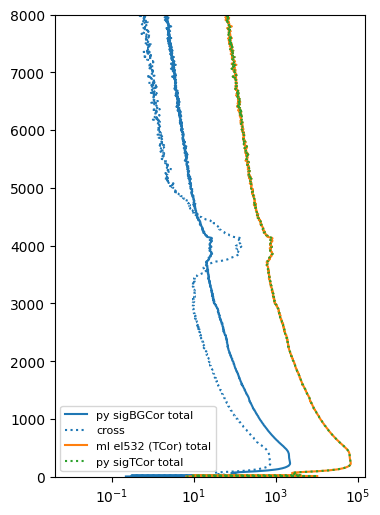

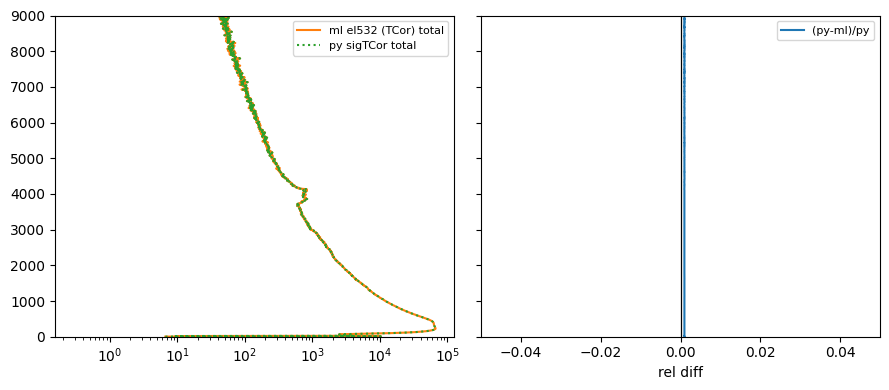

In [50]:
mean_532_total = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,4], axis=0)
mean_532_cross = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,5], axis=0)
mean_TCor_532_total = np.mean(data_cube.data_retrievals['sigTCor'][39:139,:,4], axis=0)

with open('20230618_0000_sigTCor_matlab.pickle', 'rb') as f:
    sigTCor_ml = pickle.load(f)
print(sigTCor_ml.keys())

mean_TCor_532_total_ml = np.mean(sigTCor_ml['el532'][:, 39:139], axis=1)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py sigBGCor total')
ax.plot(mean_532_cross, np.array(data_cube.data_retrievals['height']), color='C0', ls=':', label='cross')

ax.plot(mean_TCor_532_total_ml, np.array(sigTCor_ml['height']), color='C1', label='ml el532 (TCor) total')
# ax.plot(comp_ml['sig532c_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', ls=':', label='cross')

ax.plot(mean_TCor_532_total, np.array(data_cube.data_retrievals['height']), color='C2', ls=':', label='py sigTCor total')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend(fontsize=8)

fig, (ax, ax1) = plt.subplots(1,2, figsize=(9,4), sharey=True)
ax.plot(mean_TCor_532_total_ml, np.array(sigTCor_ml['height']), color='C1', label='ml el532 (TCor) total')
ax.plot(mean_TCor_532_total, np.array(data_cube.data_retrievals['height']), color='C2', ls=':', label='py sigTCor total')
ax.set_ylim(0, 9000)
ax.set_xscale('log')
ax.legend(fontsize=8)

reldiff = (mean_TCor_532_total - mean_TCor_532_total_ml)/mean_TCor_532_total
ax1.axvline(0, lw=0.9, color='k')
ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
ax1.legend(fontsize=8)
ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
fig.tight_layout()
# # fig.savefig('mSig_rayleigh_fit.png')
# print('mSig', mSig[:20])



In [51]:
import copy
# mol_profiles_py = copy.deepcopy(data_cube.mol_profiles)

# data_cube.mol_profiles = mol_profiles_py

In [52]:
# check if the errors in molecular scattering make a difference
# ... and it does....
# with open('20230618_0000_beta_klett_matlab.pickle', 'rb') as f:
#     beta_klett_ml = pickle.load(f)
# # print(beta_klett_ml.keys())

# data_cube.mol_profiles[f'mBsc_355'] = beta_klett_ml['mBsc355']

In [53]:
data_cube.retrievalKlett(nr=True)

2025-02-28 17:50:58,654 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-02-28 17:50:58,657 - WARNING - at 10km height this is a difference of about 4 indices


retrievalname klett
Starting Klett retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
== 532, total, FR klett =================================
(266, 3000, 1)
refHInd [675, 875] refH [5066.25 6566.25]
LR  50 [5066.25 6566.25] refBeta 1e-08 smoothWin_klett 21
indRefH  [675 875]
indRefH [675 875] 775
refH slice shape  (201,)
RCS[indRefMid]  1577889.1404193377
mean(mBsc) 0.0008797481113861896 1e-05
aerBR[indRefMid]  0.011373578901245502
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval'])
== 355, total, FR klett =================================
(266, 3000, 1)
refHInd [973, 1172] refH [7301.25 8793.75]
LR  50 [7301.25 8793.75] refBeta 2e-08 smoothWin_klett 21
indRefH  [ 973 1172]
indRefH [ 973 1172] 1073
refH slice shape  (200,)
RCS[indRefMid]  1155692.4858180515
mean(mBsc) 0.003458400642193114 2e-05
aerBR[indRefMid]  0.005796769106104807
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'a

In [54]:
print(data_cube.data_retrievals.keys())
print(len(data_cube.data_retrievals['klett']))
print(data_cube.data_retrievals['klett'][0].keys())

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'avail_optical_profiles', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS', 'sigTCor', 'BGTCor', 'klett'])
3
dict_keys(['532_total_FR', '355_total_FR', '1064_total_FR', '532_total_NR', '355_total_NR'])


dict_keys(['aerBsc355_klett', 'aerBsc532_klett', 'aerBsc1064_klett', 'aerBsc532_klett_manual', 'RCS532_manual', 'RCS355_manual_raw', 'RCS355_manual', 'RCS532_manual_raw', 'RCS1064_manual', 'signal_manual', 'molBsc_manual', 'mBsc355', 'mBsc532', 'mBsc1064', 'aerBR_manual', 'aerExt532_klett', 'pressure', 'temperature', 'height', 'range'])
reldiff 300:400 0.001764883459848266
reldiff 300:400 0.001722668667387422
reldiff 300:400 0.0016656197678176273
[973, 1172] [7273.48080932 8760.30139623]
[773, 973] [5779.18876219 7273.48080932]
[773, 973] [5779.18876219 7273.48080932]
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[734, 934] [5487.801813   6982.09386013]


/tmp/ipykernel_1482/3690924699.py:135: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)


[721, 921] [5390.67282993 6884.96487707]
[583, 783] [4359.61131741 5853.90336454]
[533, 733] [3986.03830562 5480.33035276]


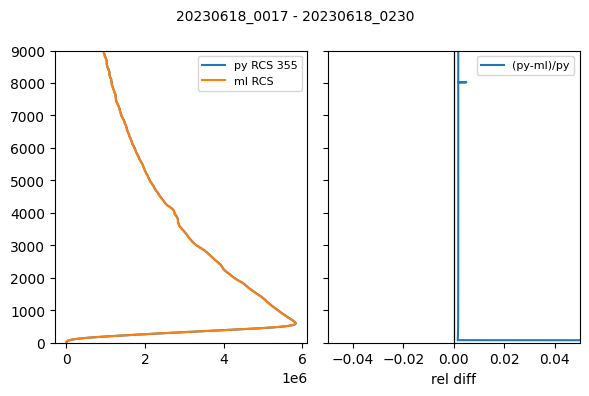

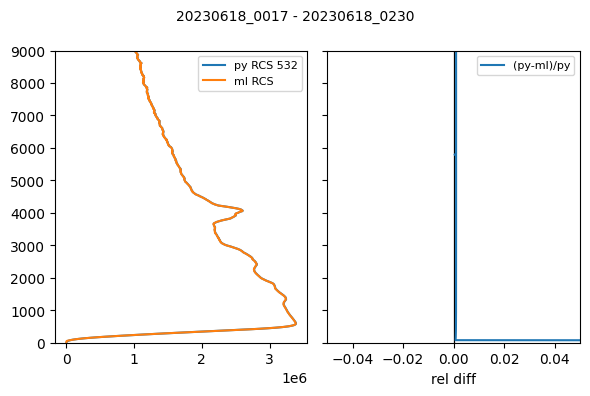

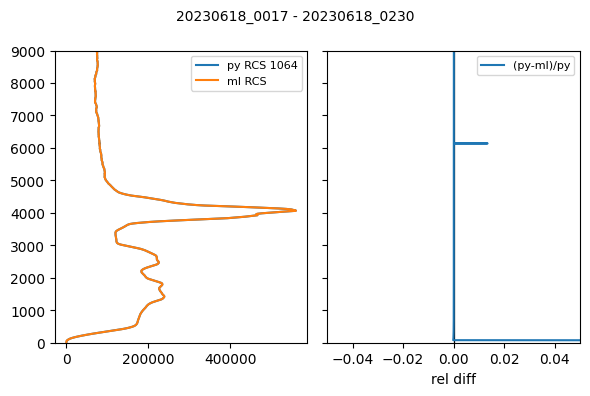

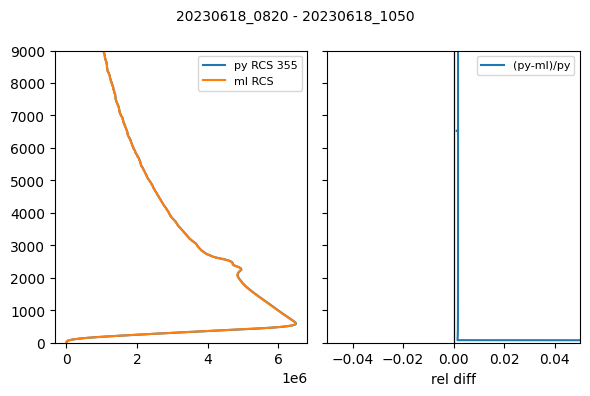

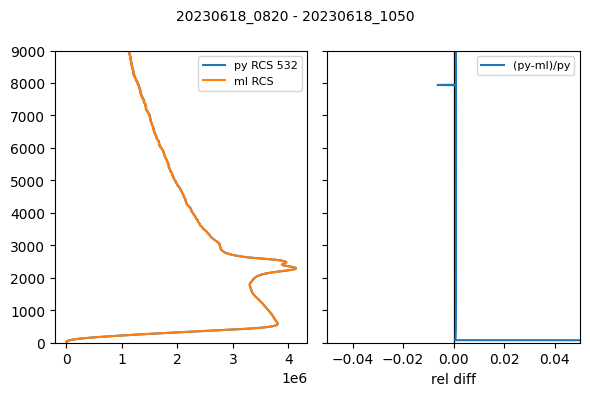

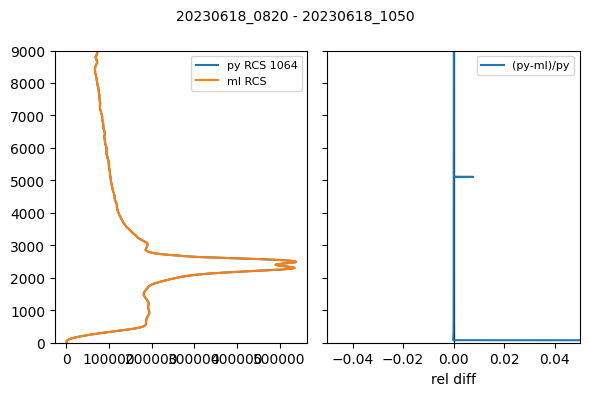

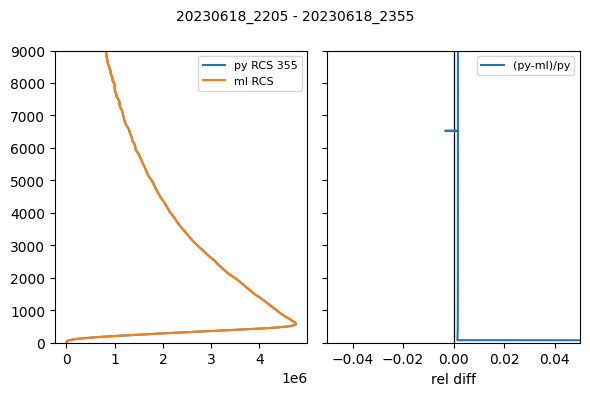

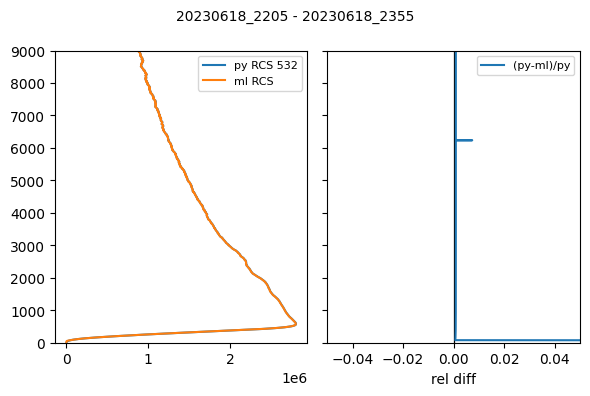

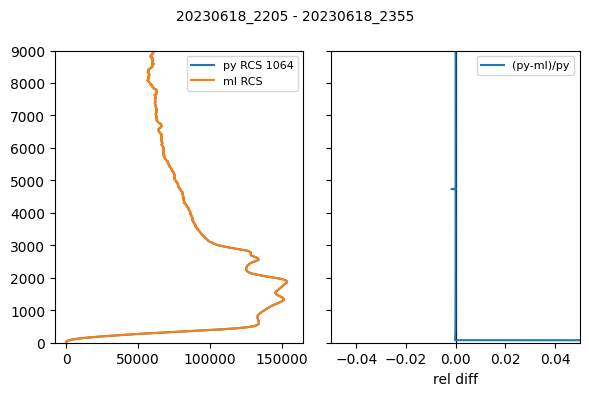

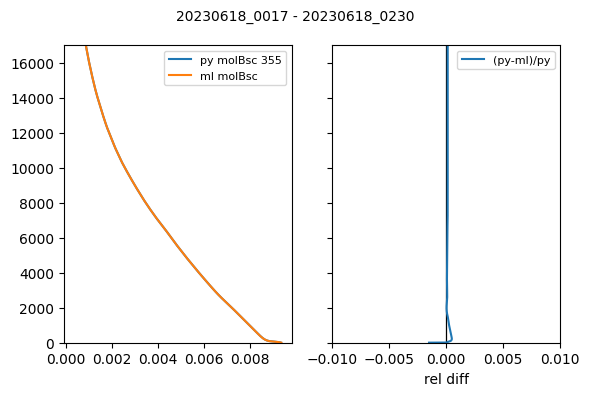

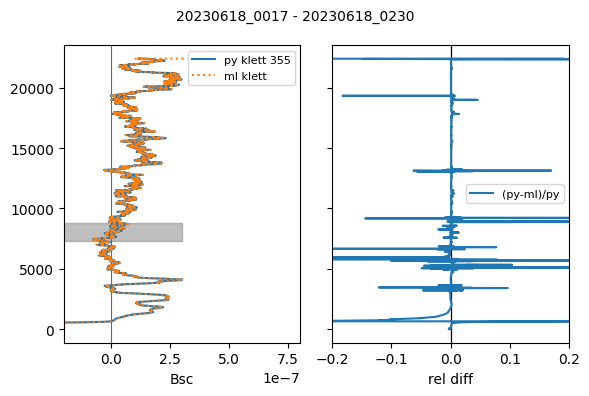

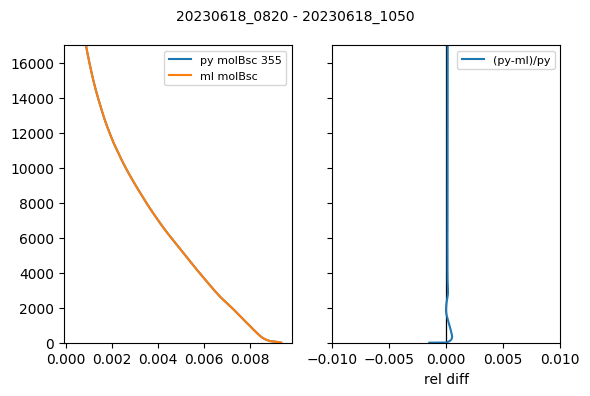

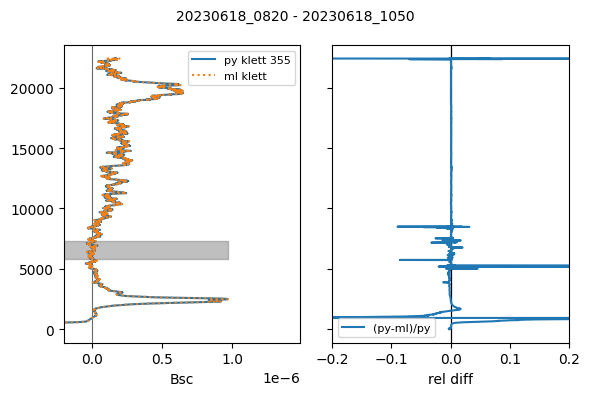

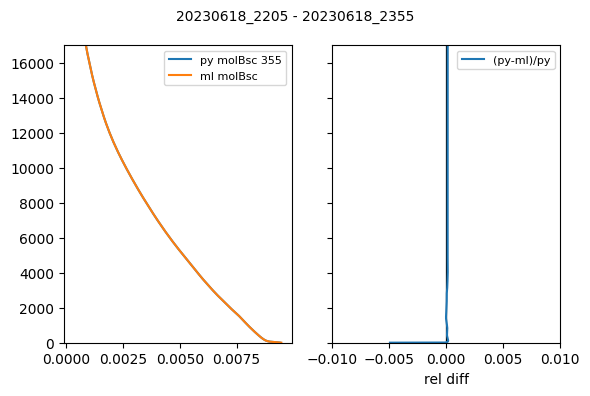

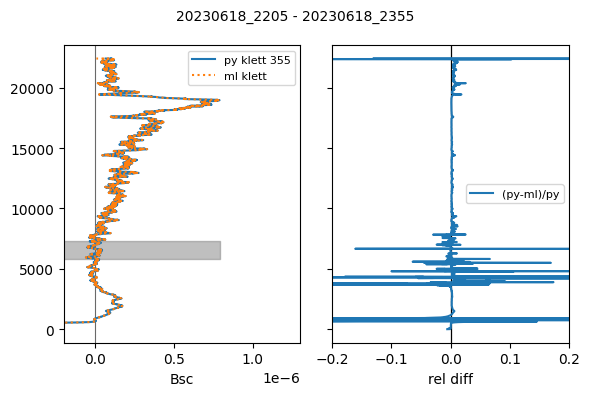

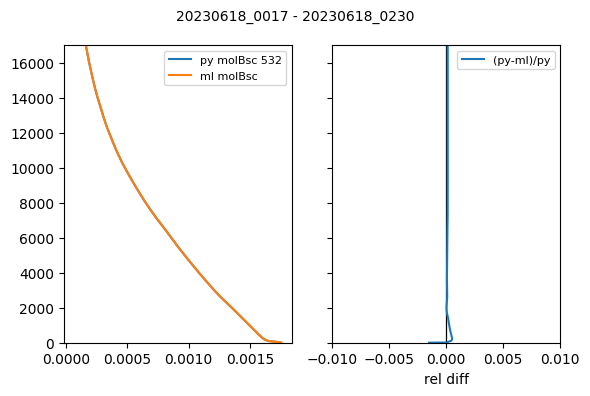

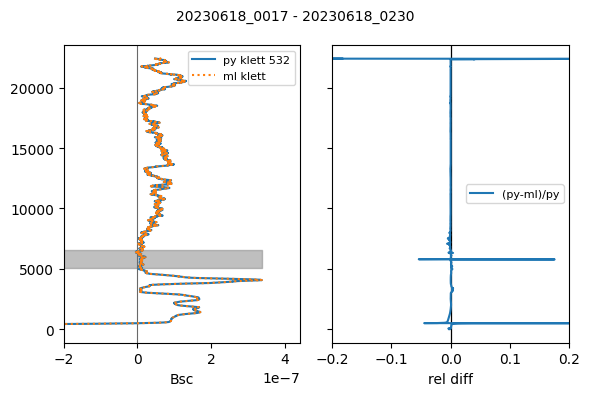

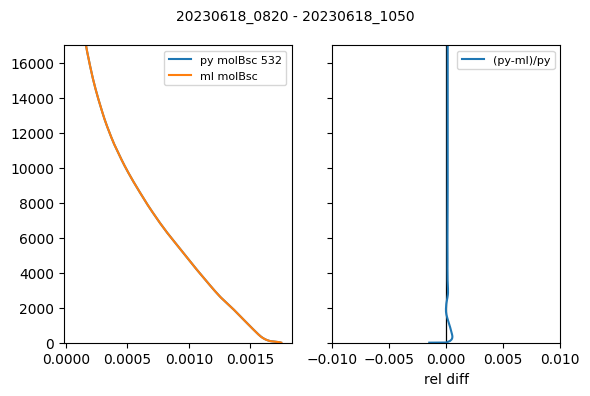

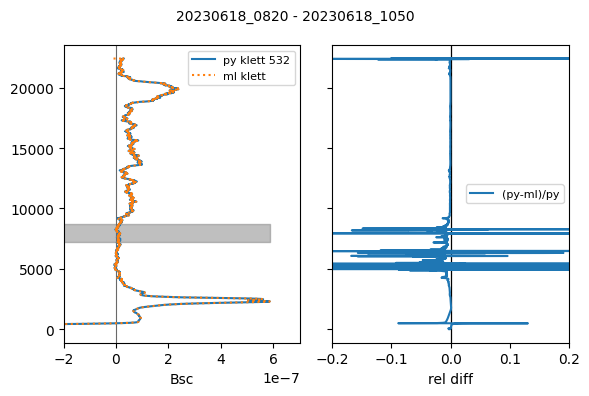

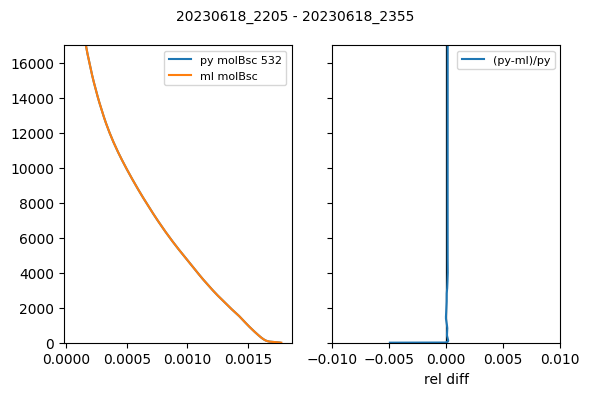

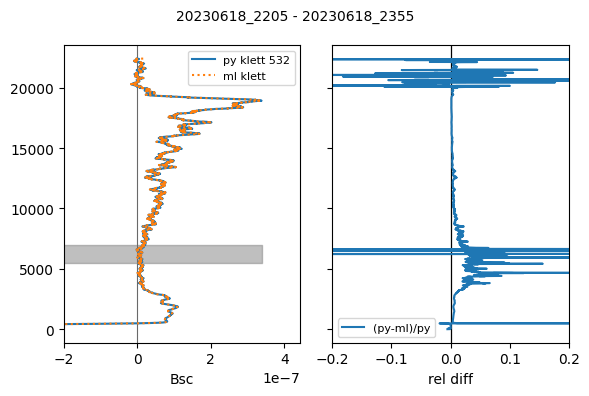

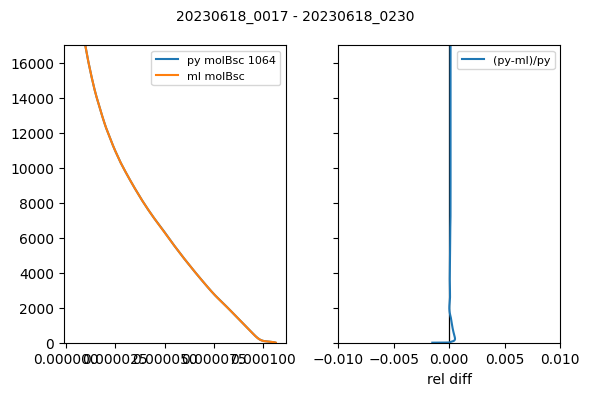

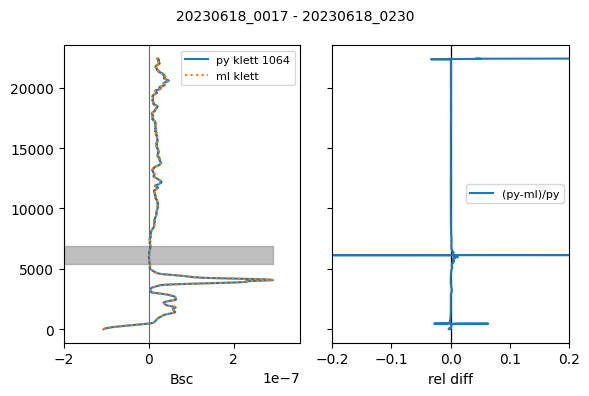

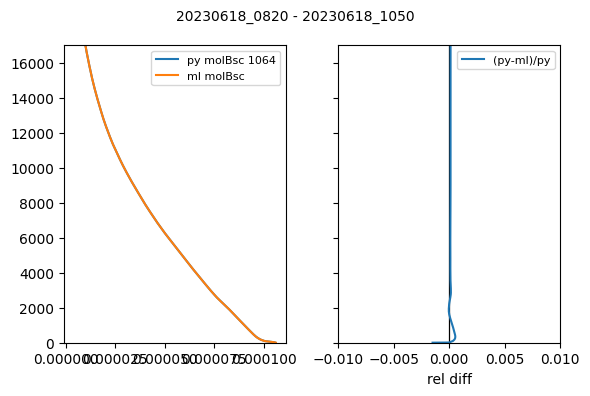

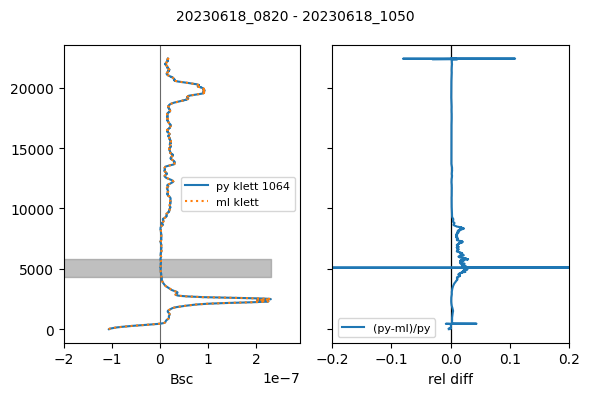

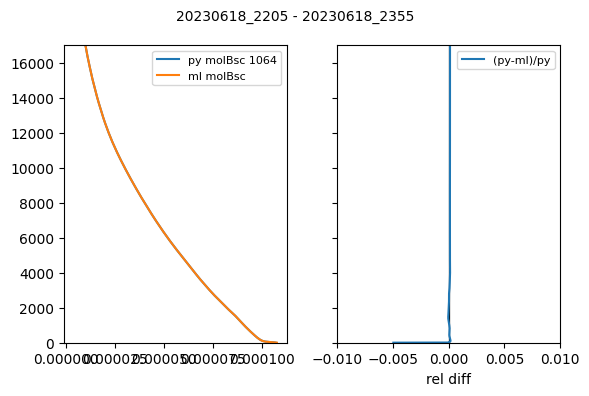

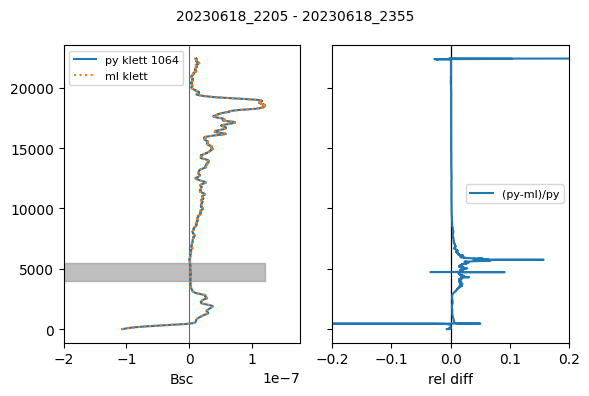

In [55]:
# aerBsc

with open('20230618_0000_beta_klett_matlab.pickle', 'rb') as f:
    beta_klett_ml = pickle.load(f)
print(beta_klett_ml.keys())

# fig, ax = plt.subplots(1, figsize=(4, 6))
# ax.plot(RCS, np.array(data_cube.data_retrievals['height']), color='C0', label='py RCS 532')

# ax.plot(np.array(beta_klett_ml['RCS_manual']), np.array(beta_klett_ml['height']), color='C1', label='ml RCS')

# ax.set_ylim(0, 10000)
# # ax.set_xscale('log')
# ax.legend(fontsize=8)
# # ax.set_xlabel('Bsc')
# # ax.set_xlim(left=-0.5e-6)

# fig, ax = plt.subplots(1, figsize=(4, 6))

# ax.plot(aerBsc, np.array(data_cube.data_retrievals['height']), color='C0', label='py klett 532')

# ax.plot(np.array(beta_klett_ml['aerBsc532_klett'])[0,:], np.array(beta_klett_ml['height']), color='C1', label='ml klett')
# ax.plot(np.array(beta_klett_ml['aerBsc532_klett_manual']), np.array(beta_klett_ml['height']), color='red', ls=':', label='ml klett man')

# # ax.set_ylim(0, 10000)
# # ax.set_xscale('log')
# ax.legend(fontsize=8)
# ax.set_xlabel('Bsc')
# ax.set_xlim(left=-0.5e-6)

for i in range(len(data_cube.data_retrievals['klett'])):

    tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
    if 'RCS' in data_cube.data_retrievals['klett'][i]['355_total_FR'].keys():
        RCS_py = data_cube.data_retrievals['klett'][i]['355_total_FR']['RCS']
        RCS_ml = np.array(beta_klett_ml['RCS355_manual'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.plot(RCS_py, np.array(data_cube.data_retrievals['height']), color='C0', label='py RCS 355')
        ax.plot(RCS_ml, np.array(beta_klett_ml['height']), color='C1', label='ml RCS')
        ax.set_ylim(0, 9000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        # ax.set_xlabel('Bsc')
        # ax.set_xlim(left=-0.5e-6)
        fig.suptitle(tstr, fontsize=10)
        
        reldiff = (RCS_py - RCS_ml)/RCS_py
        print('reldiff 300:400', np.mean(reldiff[300:400]))
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # fig.savefig('mSig_rayleigh_fit.png')
        # print('mSig', mSig[:20])

    if 'RCS' in data_cube.data_retrievals['klett'][i]['532_total_FR'].keys():
        RCS_py = data_cube.data_retrievals['klett'][i]['532_total_FR']['RCS']
        RCS_ml = np.array(beta_klett_ml['RCS532_manual'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.plot(RCS_py, np.array(data_cube.data_retrievals['height']), color='C0', label='py RCS 532')
        ax.plot(RCS_ml, np.array(beta_klett_ml['height']), color='C1', label='ml RCS')
        ax.set_ylim(0, 9000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        # ax.set_xlabel('Bsc')
        # ax.set_xlim(left=-0.5e-6)
        fig.suptitle(tstr, fontsize=10)
        
        reldiff = (RCS_py - RCS_ml)/RCS_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # fig.savefig('mSig_rayleigh_fit.png')
        # print('mSig', mSig[:20])

    if 'RCS' in data_cube.data_retrievals['klett'][i]['1064_total_FR'].keys():
        RCS_py = data_cube.data_retrievals['klett'][i]['1064_total_FR']['RCS']
        RCS_ml = np.array(beta_klett_ml['RCS1064_manual'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.plot(RCS_py, np.array(data_cube.data_retrievals['height']), color='C0', label='py RCS 1064')
        ax.plot(RCS_ml, np.array(beta_klett_ml['height']), color='C1', label='ml RCS')
        ax.set_ylim(0, 9000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        # ax.set_xlabel('Bsc')
        # ax.set_xlim(left=-0.5e-6)
        fig.suptitle(tstr, fontsize=10)
        
        reldiff = (RCS_py - RCS_ml)/RCS_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # fig.savefig('mSig_rayleigh_fit.png')
        # print('mSig', mSig[:20])

for wv in [355,532,1064]:
# for wv in [355]:
    for i in range(len(data_cube.data_retrievals['klett'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
        
        if 'molBsc' in data_cube.data_retrievals['klett'][i][f'{wv}_total_FR'].keys():
            molBsc_py = data_cube.data_retrievals['klett'][i][f'{wv}_total_FR']['molBsc']
            molBsc_ml = np.array(beta_klett_ml[f'mBsc{wv}'])[i,:]*1e3
            fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
            ax.plot(molBsc_py, np.array(data_cube.data_retrievals['height']), color='C0', label=f'py molBsc {wv}')
            ax.plot(molBsc_ml, np.array(beta_klett_ml['height']), color='C1', label='ml molBsc')
            ax.set_ylim(0, 9000)
            ax.set_ylim(0, 17000)
            # ax.set_xscale('log')
            ax.legend(fontsize=8)
            # ax.set_xlabel('Bsc')
            # ax.set_xlim(left=-0.5e-6)
            
            reldiff = (molBsc_py - molBsc_ml)/molBsc_py
            ax1.axvline(0, lw=0.9, color='k')
            ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
            ax1.legend(fontsize=8)
            ax1.set_xlim(-0.01, 0.01); ax1.set_xlabel('rel diff')
            fig.suptitle(tstr, fontsize=10)
            fig.tight_layout()
            # # fig.savefig('mSig_rayleigh_fit.png')
            # print('mSig', mSig[:20])
    
        beta_py = data_cube.data_retrievals['klett'][i][f'{wv}_total_FR']['aerBsc']
        beta_ml = np.array(beta_klett_ml[f'aerBsc{wv}_klett'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
                        color='grey', alpha=0.5)
        ax.plot(beta_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py klett {wv}')
        ax.plot(beta_ml, np.array(beta_klett_ml['height']), 
                color='C1', ls=':', label='ml klett')
        
        # ax.set_ylim(0, 10000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Bsc')
        ax.set_xlim(left=-0.2e-6)
    
        reldiff = (beta_py - beta_ml)/beta_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.2, 0.2); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')



candidates  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230616_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230617_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230619_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230620_neumayer_ecmwf.nc']
regex  re.compile('.*/2023/20230618.*.nc')
filename  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc']
time slices of cloud free  [[datetime.datetime(2023, 6, 18, 0, 17, 30), datetime.datetime(2023, 6, 18, 2, 30)], [datetime.datetime(2023, 6, 18, 8, 20), datetime.datetime(2023, 6, 18, 10, 50)], [datetime.datetime(2023, 6, 18, 22, 5), datetime.datetime(2023, 6, 18, 23, 55)]]


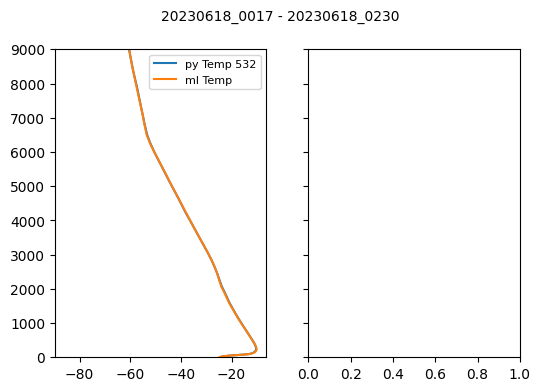

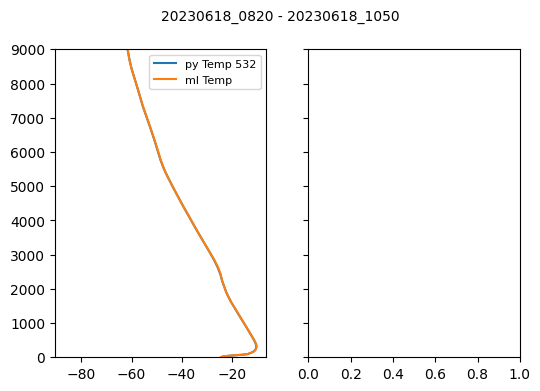

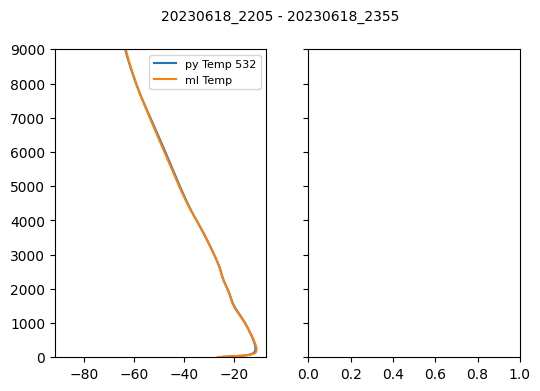

In [56]:
data_cube.loadMeteo()
time_slices = [data_cube.data_retrievals['time64'][grp].tolist() for grp in data_cube.clFreeGrps]
print('time slices of cloud free ', time_slices)
mean_profiles = data_cube.met.get_mean_profiles(time_slices) 

for i in range(len(data_cube.data_retrievals['klett'])):

    tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
    t_py = mean_profiles[i].temperature.values - 273.15
    t_ml = np.array(beta_klett_ml['temperature'])[i,:] 
    fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
    ax.plot(t_py, np.array(data_cube.data_retrievals['height']), color='C0', label='py Temp 532')
    ax.plot(t_ml, np.array(beta_klett_ml['height']), color='C1', label='ml Temp')
    ax.set_ylim(0, 9000)
    # ax.set_xscale('log')
    ax.legend(fontsize=8)
    fig.suptitle(tstr, fontsize=10)
    # ax.set_xlabel('Bsc')
    # ax.set_xlim(left=-0.5e-6)
    
    # reldiff = (RCS_py - RCS_ml)/RCS_py
    # ax1.axvline(0, lw=0.9, color='k')
    # ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
    # ax1.legend(fontsize=8)
    # ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
    # fig.tight_layout()
    # # fig.savefig('mSig_rayleigh_fit.png')
    # print('mSig', mSig[:20])

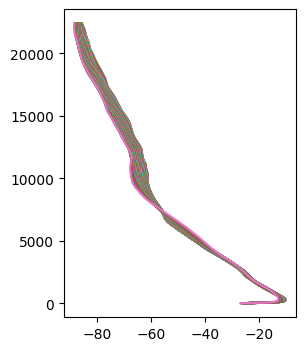

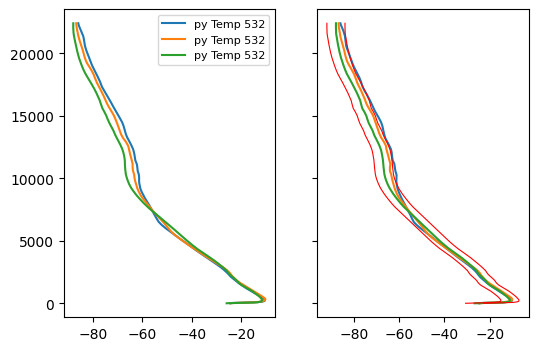

In [57]:
# for t in data_cube.met.ds.time:
#     print(t)

#     d = data_cube.met.ds.sel(time=t)
#     print(d)
#     fig, ax = plt.subplots(1, figsize=(3,4), sharey=True)
#     ax.plot(d.temperature-273.15, d.height, color='C0', label='py Temp 532')
#     ax.plot(t_ml, np.array(beta_klett_ml['height']), color='C1', label='ml Temp')
#     ax.set_ylim(0, 9000)
#     ax.set_title(t.values)

fig, ax = plt.subplots(1, figsize=(3,4), sharey=True)
for t in data_cube.met.ds.time:

    d = data_cube.met.ds.sel(time=t)
    ax.plot(d.temperature-273.15, d.height)
    # ax.set_ylim(0, 9000)
    # ax.set_title(t.values)

fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
for i in range(len(data_cube.data_retrievals['klett'])):

    t_py = mean_profiles[i].temperature.values - 273.15
    t_ml = np.array(beta_klett_ml['temperature'])[i,:] 
    ax.plot(t_py, np.array(data_cube.data_retrievals['height']), label='py Temp 532')
    ax1.plot(t_ml, np.array(beta_klett_ml['height']), label='ml Temp')
    # ax.set_ylim(0, 9000)
    # ax.set_xscale('log')
    ax.legend(fontsize=8)
    # ax.set_xlabel('Bsc')
    # ax.set_xlim(left=-0.5e-6)
ax1.plot(t_ml-4, np.array(beta_klett_ml['height']), color='r', lw=0.8, label='ml Temp')
ax1.plot(t_ml+4, np.array(beta_klett_ml['height']), color='r', lw=0.8, label='ml Temp')

In [58]:
ks = ["angstrexp", "smoothWin_raman_355", "smoothWin_raman_532", "smoothWin_raman_1064", "heightFullOverlap"]

for k in ks:
    print(k, data_cube.polly_config_dict[k])

ks = ["minRamanRefSNR355", "minRamanRefSNR387", "minRamanRefSNR532", "minRamanRefSNR607", "minRamanRefSNR1064"]
for k in ks:
    print(k, data_cube.polly_config_dict[k])

data_cube.polly_config_dict["smoothWin_raman_355"] = 131
data_cube.polly_config_dict["smoothWin_raman_532"] = 131
data_cube.polly_config_dict["smoothWin_raman_1064"] = 131

angstrexp 0.9
smoothWin_raman_355 61
smoothWin_raman_532 61
smoothWin_raman_1064 61
heightFullOverlap [1300, 1300, 1300, 1300, 1000, 1000, 1000, 1000, 150, 150, 150, 150, 150]
minRamanRefSNR355 50
minRamanRefSNR387 40
minRamanRefSNR532 20
minRamanRefSNR607 15
minRamanRefSNR1064 10


In [88]:
data_cube.retrievalRaman(nr=True)

2025-02-28 19:48:07,266 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-02-28 19:48:07,273 - WARNING - at 10km height this is a difference of about 4 indices


[array([1300, 1300, 1300, 1300, 1000, 1000, 1000, 1000,  150,  150,  150,
        150,  150]), array([1300, 1300, 1300, 1300, 1000, 1000, 1000, 1000,  150,  150,  150,
        150,  150]), array([1300, 1300, 1300, 1300, 1000, 1000, 1000, 1000,  150,  150,  150,
        150,  150])]
Starting Raman retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
== 355, total, FR | 387, total, FR raman ========
shape sig (266, 3000, 1)
1300 491.25
refHInd [973, 1172] refH [7301.25 8793.75] hBaseInd 239 hBase 1796.25
SNRRef [1905.2208161744331] SNRRef_r [514.1932552284588]
high enough to continue
filling below overlap with -1.0204094194846324e-06
== 532, total, FR | 607, total, FR raman ========
shape sig (266, 3000, 1)
1000 491.25
refHInd [675, 875] refH [5066.25 6566.25] hBaseInd 199 hBase 1496.25
SNRRef [3101.8153855036594] SNRRef_r [741.5800589447163]
high enough to continue
filling below overlap with 2.9025347527670815e-06
== 1064, total, FR | 607, total, FR raman ========
shape sig (266, 3000, 

/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/tests/../lib/retrievals/raman.py:283: RuntimeWarning: invalid value encountered in sqrt
  angstroemSample[iX, :], ext_mol, beta_mol, ext_mol_raman,


cldFree  1 [1000, 1300]
cldFree mod (1000, 1301)
== 355, total, FR | 387, total, FR raman ========
shape sig (301, 3000, 1)
1300 491.25
refHInd [773, 973] refH [5801.25 7301.25] hBaseInd 239 hBase 1796.25
SNRRef [2871.302892245996] SNRRef_r [765.3663285268359]
high enough to continue
filling below overlap with -1.565783508297485e-06
== 532, total, FR | 607, total, FR raman ========
shape sig (301, 3000, 1)
1000 491.25
refHInd [962, 1162] refH [7218.75 8718.75] hBaseInd 199 hBase 1496.25
SNRRef [2040.2391289922134] SNRRef_r [486.1661638524561]
high enough to continue
filling below overlap with -2.687023021843004e-06
== 1064, total, FR | 607, total, FR raman ========
shape sig (301, 3000, 1)
1000 491.25
refHInd [583, 783] refH [4376.25 5876.25] hBaseInd 199 hBase 1496.25
SNRRef [901.6565207124672] SNRRef_r [929.0046763979587]
high enough to continue
filling below overlap with -1.439939984017705e-06
== 532, total, NR | 607, total, NR raman ========
shape sig (301, 3000, 1)
150 93.75
refHI

/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/tests/../lib/retrievals/raman.py:201: RuntimeWarning: invalid value encountered in sqrt
  
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/tests/../lib/retrievals/raman.py:284: RuntimeWarning: invalid value encountered in sqrt
  beta_mol_inela, HRef, el_lambda, betaRefSample[iM], window_size,


cldFree  2 [2650, 2870]
cldFree mod (2650, 2871)
== 355, total, FR | 387, total, FR raman ========
shape sig (221, 3000, 1)
1300 491.25
refHInd [773, 973] refH [5801.25 7301.25] hBaseInd 239 hBase 1796.25
SNRRef [2497.925616849317] SNRRef_r [673.7086833489548]
high enough to continue
filling below overlap with -4.494242338344733e-06
== 532, total, FR | 607, total, FR raman ========
shape sig (221, 3000, 1)
1000 491.25
refHInd [734, 934] refH [5508.75 7008.75] hBaseInd 199 hBase 1496.25
SNRRef [2566.8050497929817] SNRRef_r [611.6256285821005]
high enough to continue
filling below overlap with -4.157742578897751e-06
== 1064, total, FR | 607, total, FR raman ========
shape sig (221, 3000, 1)
1000 491.25
refHInd [533, 733] refH [4001.25 5501.25] hBaseInd 199 hBase 1496.25
SNRRef [849.4383878166557] SNRRef_r [890.4673371077494]
high enough to continue
filling below overlap with -2.2280790800599096e-06
== 532, total, NR | 607, total, NR raman ========
shape sig (221, 3000, 1)
150 93.75
refHI

In [89]:
print(data_cube.data_retrievals.keys())
print(len(data_cube.data_retrievals['raman']))
print(data_cube.data_retrievals['raman'][0].keys())

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'avail_optical_profiles', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS', 'sigTCor', 'BGTCor', 'klett', 'raman', 'overlap', 'overlap2d', 'sigOLCor', 'BGOLCor', 'heightFullOverCor', 'klett_OC', 'raman_OC'])
3
dict_keys(['355_total_FR', '532_total_FR', '1064_total_FR', '532_total_NR', '355_total_NR'])


dict_keys(['aerExt355_raman', 'aerExt532_raman', 'aerExt1064_raman', 'aerBsc355_raman', 'aerBsc532_raman', 'aerBsc1064_raman', 'LR355_raman', 'LR532_raman', 'LR1064_raman', 'height'])
[973, 1172] [7273.48080932 8760.30139623]
[773, 973] [5779.18876219 7273.48080932]
[773, 973] [5779.18876219 7273.48080932]
[973, 1172] [7273.48080932 8760.30139623]
[773, 973] [5779.18876219 7273.48080932]
[773, 973] [5779.18876219 7273.48080932]
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[734, 934] [5487.801813   6982.09386013]
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[734, 934] [5487.801813   6982.09386013]
[721, 921] [5390.67282993 6884.96487707]
[583, 783] [4359.61131741 5853.90336454]
[533, 733] [3986.03830562 5480.33035276]
[721, 921] [5390.67282993 6884.96487707]
[583, 783] [4359.61131741 5853.90336454]
[533, 733] [3986.03830562 5480.33035276]


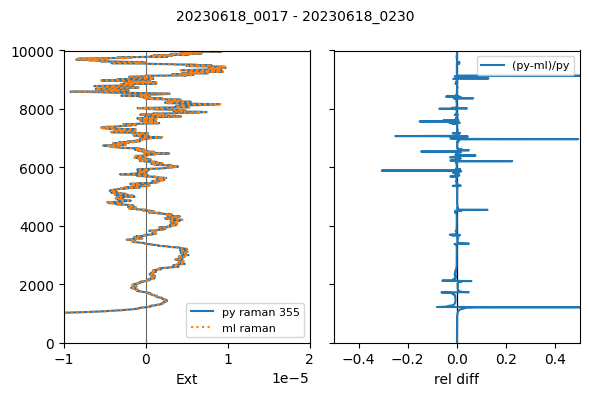

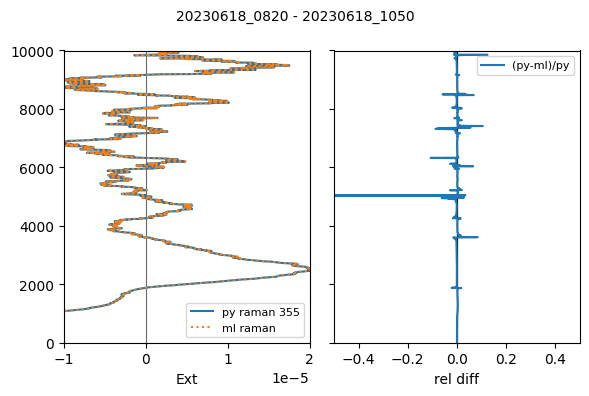

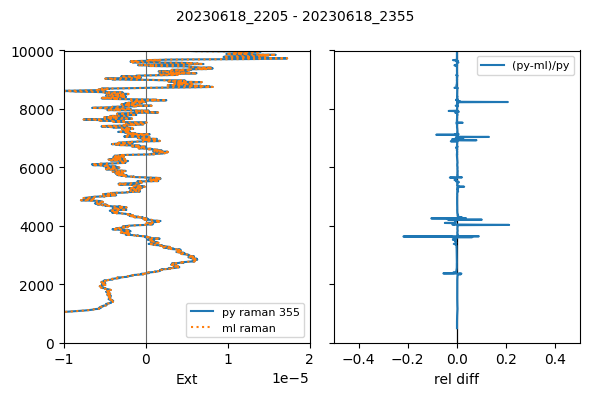

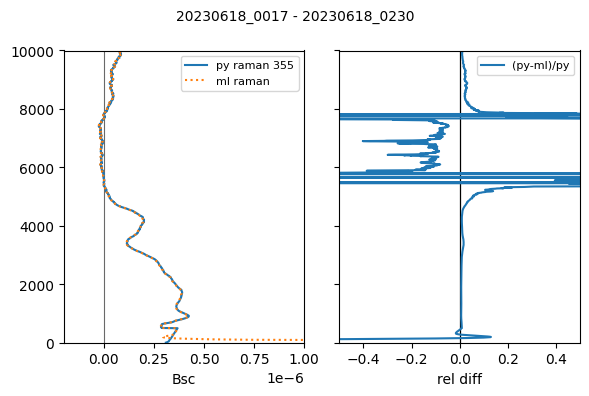

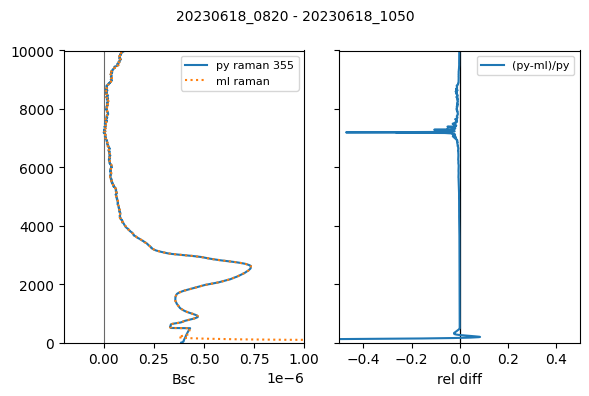

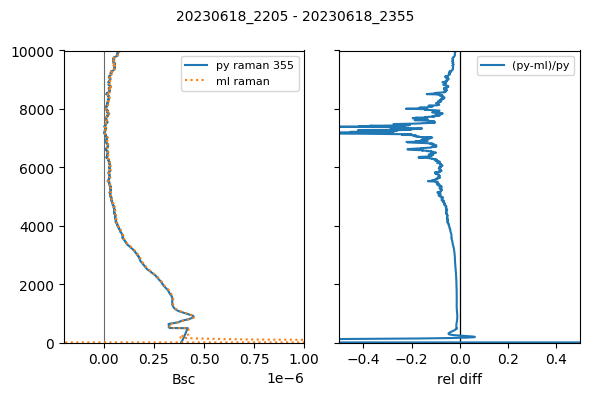

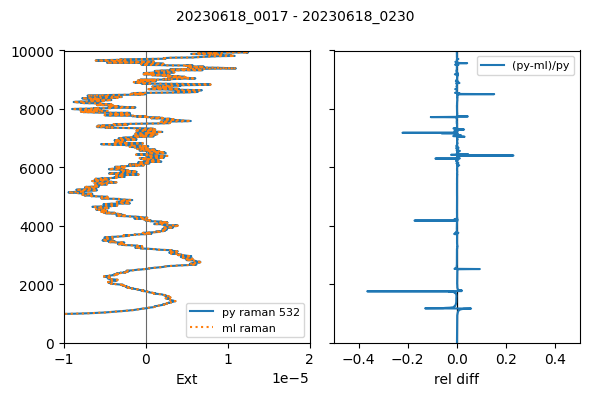

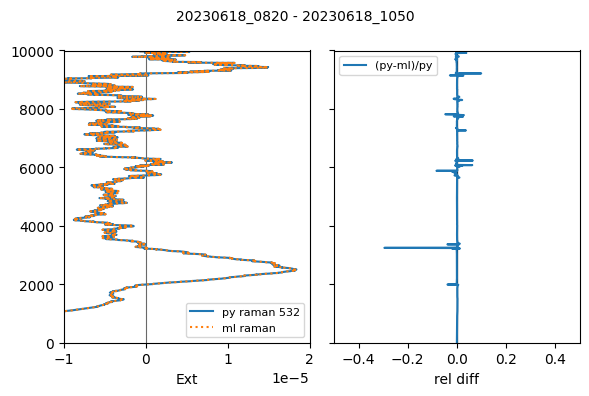

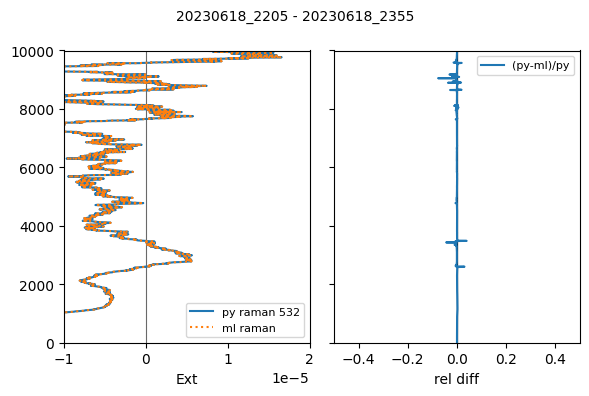

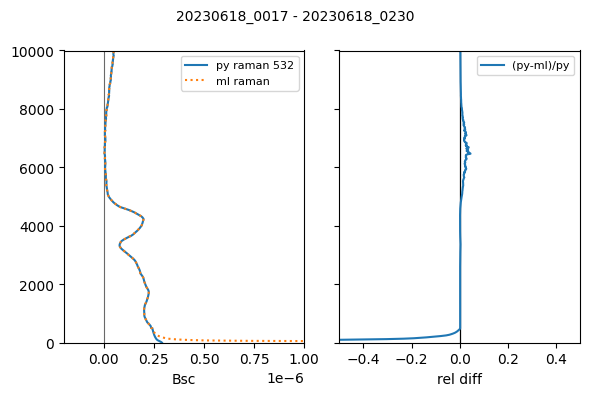

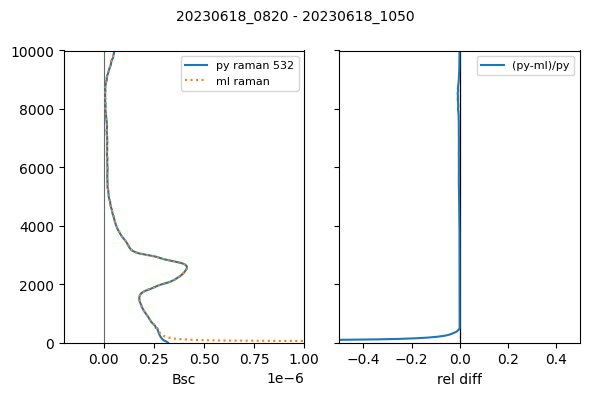

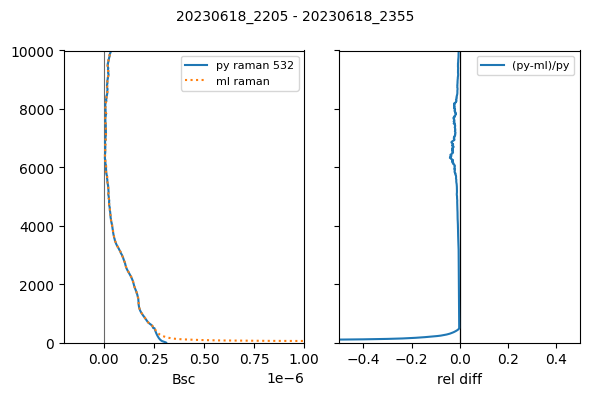

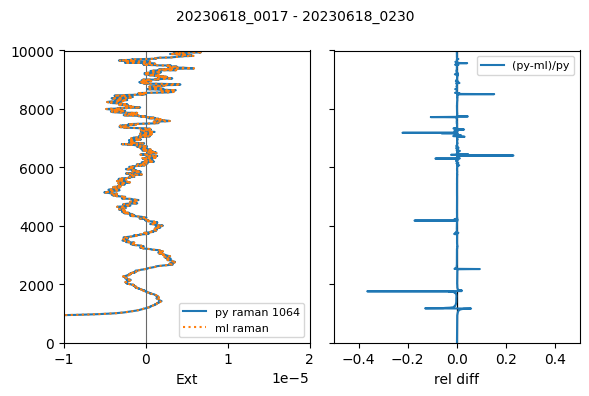

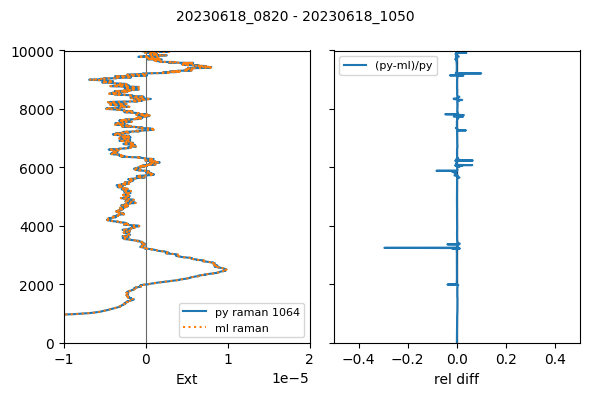

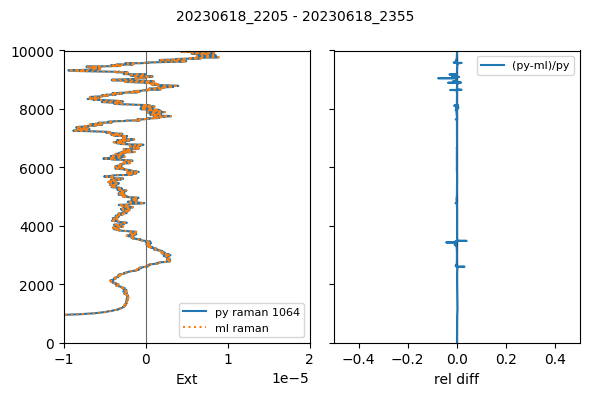

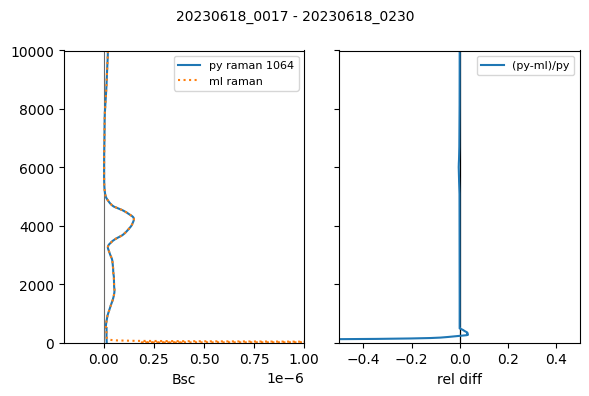

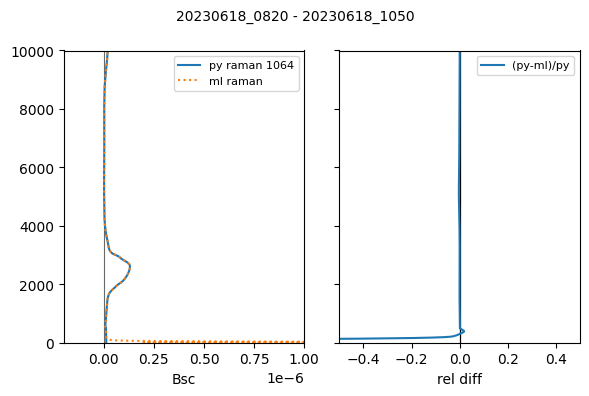

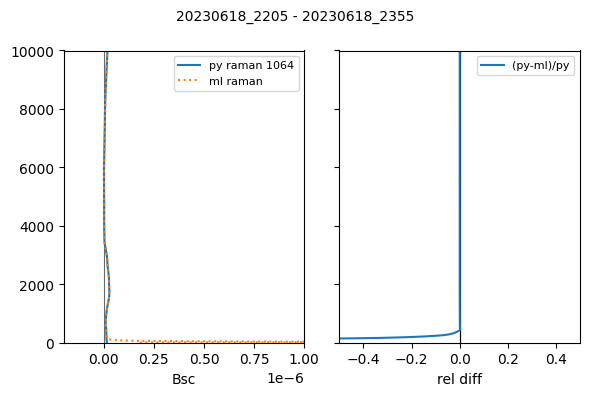

In [90]:

with open('20230618_0000_raman_matlab.pickle', 'rb') as f:
    raman_ml = pickle.load(f)
print(raman_ml.keys())

for wv in [355,532,1064]:
# for wv in [532]:
    for i in range(len(data_cube.data_retrievals['raman'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
           
        ext_py = data_cube.data_retrievals['raman'][i][f'{wv}_total_FR']['aerExt']
        ext_ml = np.array(raman_ml[f'aerExt{wv}_raman'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(ext_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py raman {wv}')
        ax.plot(ext_ml, np.array(raman_ml['height']), 
                color='C1', ls=':', label='ml raman')
        
        ax.set_ylim(0, 10000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Ext')
        ax.set_xlim([-0.1e-4, 0.2e-4])
    
        reldiff = (ext_py - ext_ml)/ext_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.5, 0.5); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')

    
    for i in range(len(data_cube.data_retrievals['raman'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
           
        bsc_py = data_cube.data_retrievals['raman'][i][f'{wv}_total_FR']['aerBsc']
        bsc_ml = np.array(raman_ml[f'aerBsc{wv}_raman'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(bsc_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py raman {wv}')
        ax.plot(bsc_ml, np.array(raman_ml['height']), 
                color='C1', ls=':', label='ml raman')
        
        ax.set_ylim(0, 10000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Bsc')
        ax.set_xlim([-0.2e-6, 1e-6])
    
        reldiff = (bsc_py - bsc_ml)/bsc_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.5, 0.5); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')


In [62]:
data_cube.overlapCalc()

2025-02-28 17:52:23,822 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-02-28 17:52:23,824 - WARNING - at 10km height this is a difference of about 4 indices


Starting Overlap retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
355 both telescopes available
387 both telescopes available
532 both telescopes available
607 both telescopes available
cldFree  1 [1000, 1300]
cldFree mod (1000, 1301)
355 both telescopes available
387 both telescopes available
532 both telescopes available
607 both telescopes available
cldFree  2 [2650, 2870]
cldFree mod (2650, 2871)
355 both telescopes available
387 both telescopes available
532 both telescopes available
607 both telescopes available


2025-02-28 17:52:28,034 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-02-28 17:52:28,038 - WARNING - at 10km height this is a difference of about 4 indices


Starting Raman Overlap retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
532 607 both wavelengths available
355 387 both wavelengths available
cldFree  1 [1000, 1300]
cldFree mod (1000, 1301)
532 607 both wavelengths available
355 387 both wavelengths available
cldFree  2 [2650, 2870]
cldFree mod (2650, 2871)
532 607 both wavelengths available
355 387 both wavelengths available


In [63]:
print(len(data_cube.data_retrievals['overlap']['frnr']))
print(data_cube.data_retrievals['overlap']['frnr'][0].keys())

3
dict_keys(['355_total_FR', '387_total_FR', '532_total_FR', '607_total_FR'])


In [64]:
test = data_cube.overlapFixLowestBins()

dict_keys(['olFunc532', 'olFunc532_Grp', 'flagCloudFree_NR', 'olFunc532Raman', 'olFunc532_raman_Grp', 'olFunc532_raman_raw_Grp', 'height'])


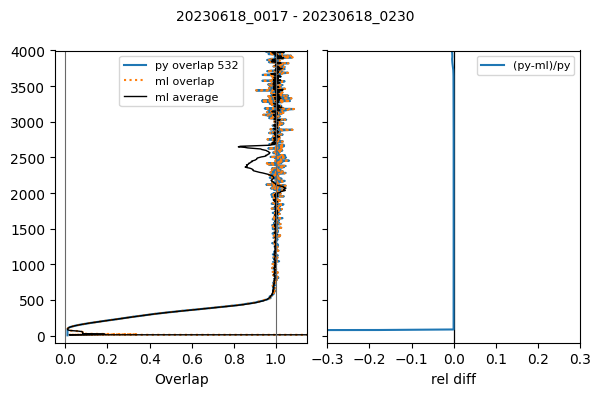

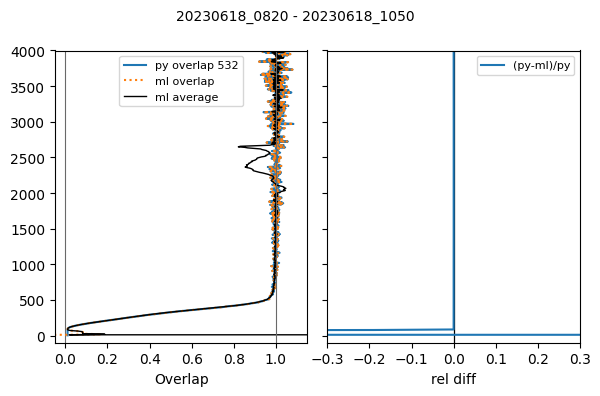

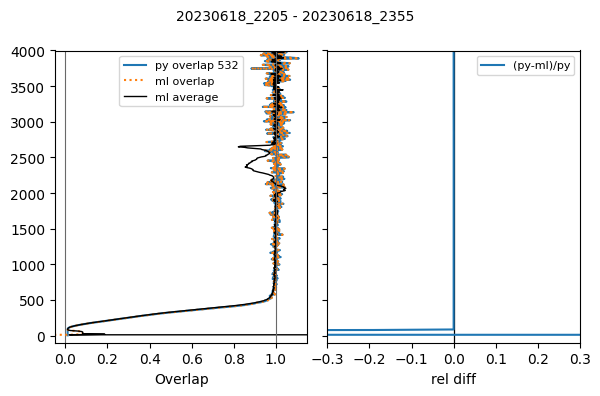

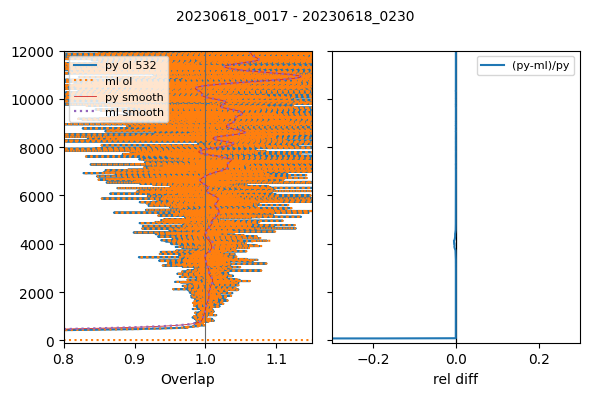

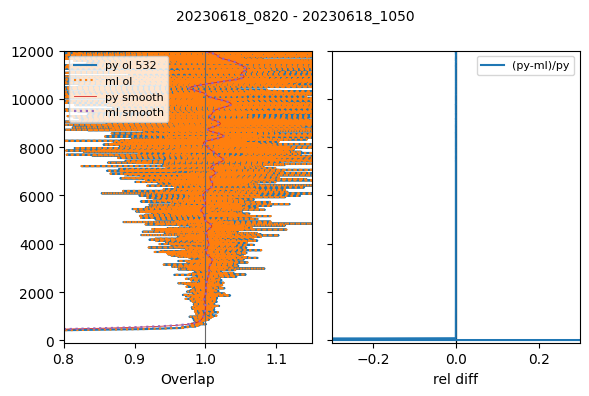

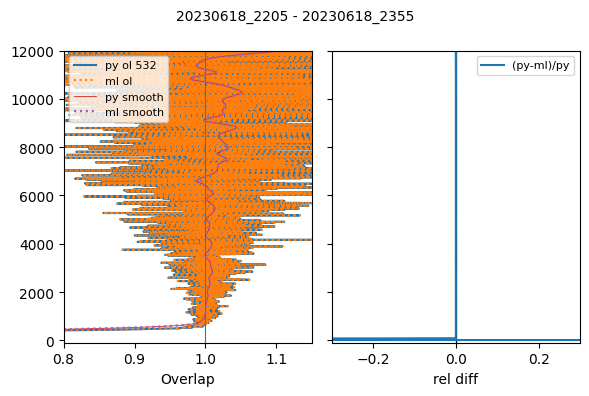

In [65]:
with open('20230618_0000_overlap.pickle', 'rb') as f:
    overlap_ml = pickle.load(f)
print(overlap_ml.keys())

for wv in [532]:
    for i in range(len(data_cube.data_retrievals['overlap']['frnr'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        ol_py = data_cube.data_retrievals['overlap']['frnr'][i][f'{wv}_total_FR']['olFunc']
        ol_ml = np.array(overlap_ml[f'olFunc{wv}_Grp'])[i,:]
        ol_avg_ml = np.array(overlap_ml[f'olFunc532'])[:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(ol_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py overlap {wv}')
        ax.plot(ol_ml, np.array(overlap_ml['height']), 
                color='C1', ls=':', label='ml overlap')
        ax.plot(ol_avg_ml, np.array(overlap_ml['height']), 
                color='k', lw=1, ls='-', label='ml average')
        ax.axvline(1, lw=0.8, color='dimgrey')
        
        ax.set_ylim(-100, 4000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Overlap')
        ax.set_xlim([-0.05, 1.15])
    
        reldiff = (ol_py - ol_ml)/ol_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.3, 0.3); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # # fig.savefig('mSig_rayleigh_fit.png')



for wv in [532]:
    for i in range(len(data_cube.data_retrievals['overlap']['frnr'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        ol_py = data_cube.data_retrievals['overlap']['frnr'][i][f'{wv}_total_FR']['olFunc']
        ol_ml = np.array(overlap_ml[f'olFunc{wv}_Grp'])[i,:]
        ol_avg_ml = np.array(overlap_ml[f'olFunc532'])[:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(ol_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py ol {wv}')
        ax.plot(ol_ml, np.array(overlap_ml['height']), 
                color='C1', ls=':', label='ml ol')
        ax.axvline(1, lw=0.8, color='dimgrey')

        ol_py_smooth = ol_py.copy()
        ol_ml_smooth = ol_ml.copy()
        for i in range(5):
            ol_py_smooth = uniform_filter1d(ol_py_smooth, 25)
            ol_ml_smooth = uniform_filter1d(ol_ml_smooth, 25)
        
        ax.plot(ol_py_smooth, np.array(data_cube.data_retrievals['height']), 
                color='C3', lw=0.6, label=f'py smooth')
        ax.plot(ol_ml_smooth, np.array(data_cube.data_retrievals['height']), 
                color='C4', ls=':', lw=1.6, label=f'ml smooth')
        
        ax.set_ylim(-100, 12000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8, loc='upper left')
        ax.set_xlabel('Overlap')
        ax.set_xlim([0.80, 1.15])
        
        reldiff = (ol_py - ol_ml)/ol_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.3, 0.3); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # # fig.savefig('mSig_rayleigh_fit.png')


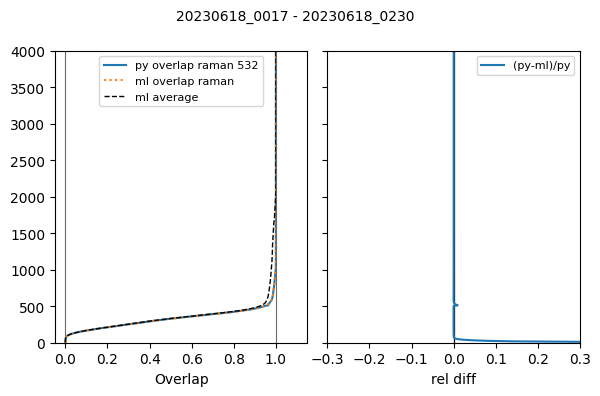

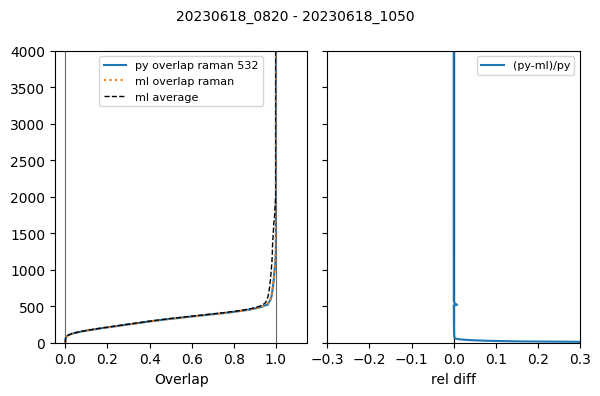

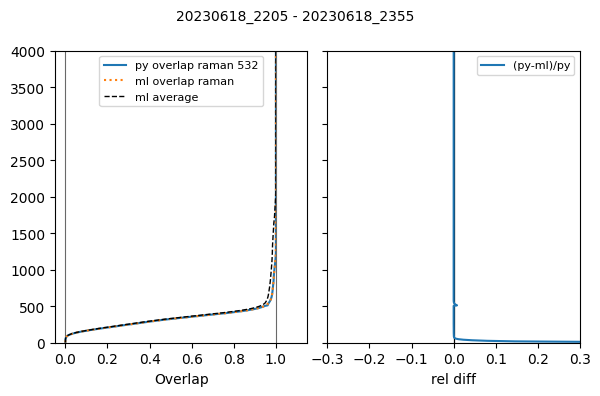

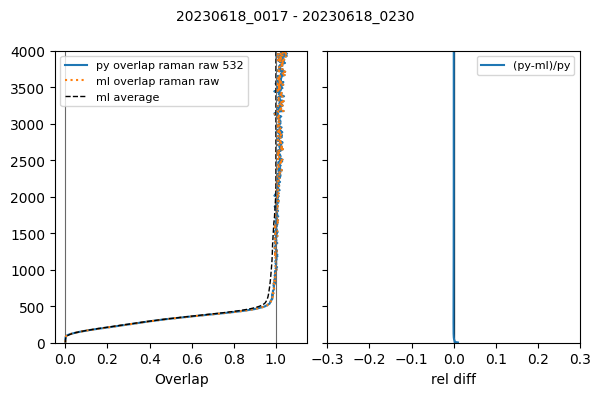

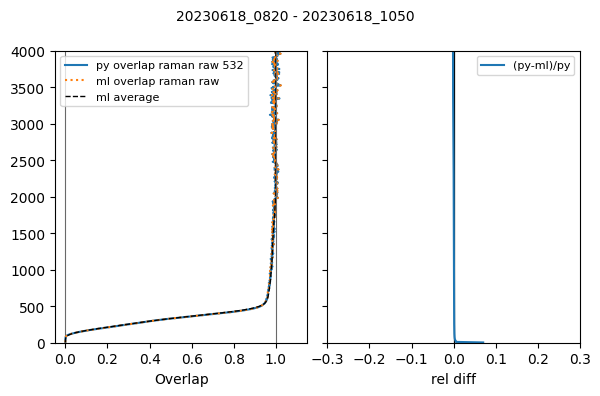

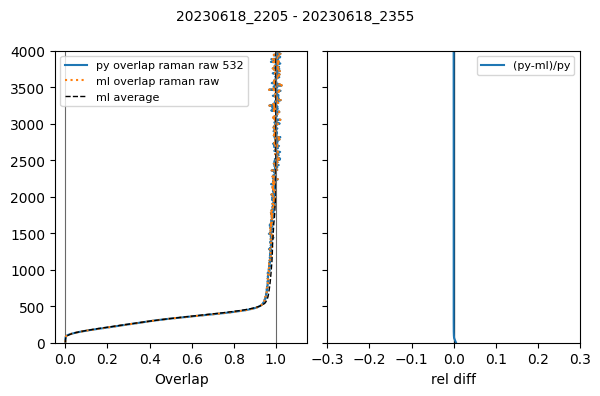

In [66]:
# dict_keys(['olFunc532', 'olFunc532_Grp', 'flagCloudFree_NR', 'olFunc532Raman', 'olFunc532_raman_Grp', 'olFunc532_raman_raw_Grp', 'height'])

for wv in [532]:
    for i in range(len(data_cube.data_retrievals['overlap']['raman'])):
        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        ol_py = data_cube.data_retrievals['overlap']['raman'][i][f'{wv}_total_FR']['olFunc']
        ol_py_raw = data_cube.data_retrievals['overlap']['raman'][i][f'{wv}_total_FR']['olFunc_raw']
        
        ol_ml = np.array(overlap_ml[f'olFunc{wv}_raman_Grp'])[i,:]
        ol_ml_raw = np.array(overlap_ml[f'olFunc{wv}_raman_raw_Grp'])[i,:]
        ol_avg_ml = np.array(overlap_ml[f'olFunc532Raman'])[:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        # ax.plot(ol_py_raw, np.array(data_cube.data_retrievals['height']), 
        #         color='b', label=f'py overlap {wv}')
        ax.plot(ol_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py overlap raman {wv}')
        ax.plot(ol_ml, np.array(overlap_ml['height']), 
                color='C1', ls=':', label='ml overlap raman')
        ax.plot(ol_avg_ml, np.array(overlap_ml['height']), 
                color='k', lw=1, ls='--', label='ml average')
        ax.axvline(1, lw=0.8, color='dimgrey')
        
        ax.set_ylim(0, 4000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Overlap')
        ax.set_xlim([-0.05, 1.15])
    
        reldiff = (ol_py - ol_ml)/ol_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.3, 0.3); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # # fig.savefig('mSig_rayleigh_fit.png')

for wv in [532]:
    for i in range(len(data_cube.data_retrievals['overlap']['raman'])):
        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        ol_py = data_cube.data_retrievals['overlap']['raman'][i][f'{wv}_total_FR']['olFunc_raw']
        
        ol_ml = np.array(overlap_ml[f'olFunc{wv}_raman_raw_Grp'])[i,:]
        ol_avg_ml = np.array(overlap_ml[f'olFunc532Raman'])[:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        # ax.plot(ol_py_raw, np.array(data_cube.data_retrievals['height']), 
        #         color='b', label=f'py overlap {wv}')
        ax.plot(ol_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py overlap raman raw {wv}')
        ax.plot(ol_ml, np.array(overlap_ml['height']), 
                color='C1', ls=':', label='ml overlap raman raw')
        ax.plot(ol_avg_ml, np.array(overlap_ml['height']), 
                color='k', lw=1, ls='--', label='ml average')
        ax.axvline(1, lw=0.8, color='dimgrey')
        
        ax.set_ylim(0, 4000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Overlap')
        ax.set_xlim([-0.05, 1.15])
    
        reldiff = (ol_py - ol_ml)/ol_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.3, 0.3); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # # fig.savefig('mSig_rayleigh_fit.png')


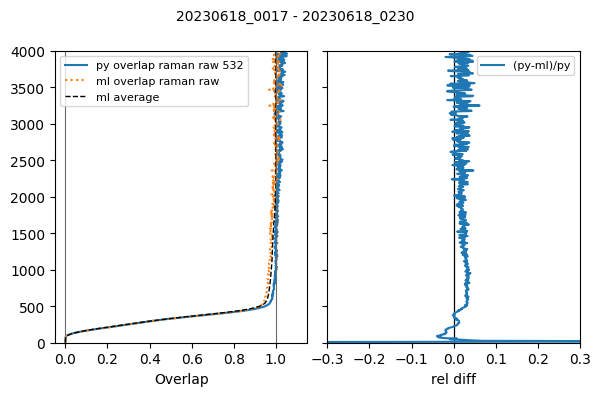

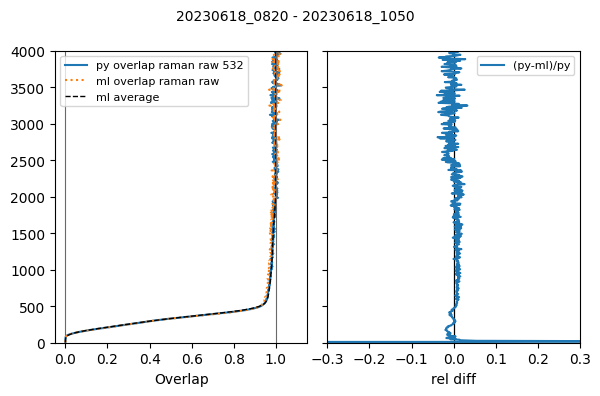

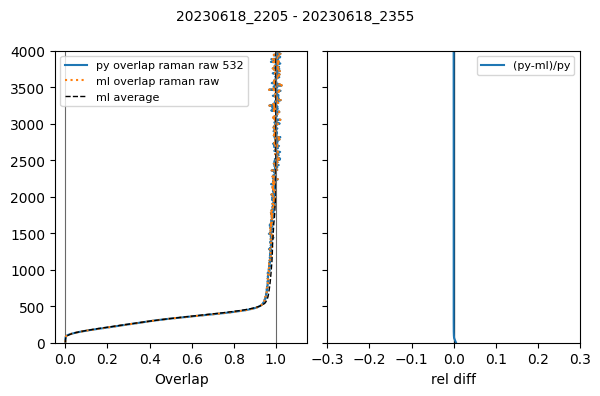

In [67]:
for wv in [532]:
    for i in range(len(data_cube.data_retrievals['overlap']['raman'])):
        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        ol_py = data_cube.data_retrievals['overlap']['raman'][i][f'{wv}_total_FR']['olFunc_raw']
        
        ol_avg_ml = np.array(overlap_ml[f'olFunc532Raman'])[:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        # ax.plot(ol_py_raw, np.array(data_cube.data_retrievals['height']), 
        #         color='b', label=f'py overlap {wv}')
        ax.plot(ol_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py overlap raman raw {wv}')
        ax.plot(ol_ml, np.array(overlap_ml['height']), 
                color='C1', ls=':', label='ml overlap raman raw')
        ax.plot(ol_avg_ml, np.array(overlap_ml['height']), 
                color='k', lw=1, ls='--', label='ml average')
        ax.axvline(1, lw=0.8, color='dimgrey')
        
        ax.set_ylim(0, 4000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Overlap')
        ax.set_xlim([-0.05, 1.15])
    
        reldiff = (ol_py - ol_ml)/ol_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.3, 0.3); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # # fig.savefig('mSig_rayleigh_fit.png')

dict_keys(['olFunc', 'olFunc_raw', 'LR', 'normRange'])
dict_keys(['olFunc', 'olFunc_raw', 'LR', 'normRange'])
dict_keys(['olFunc', 'olFunc_raw', 'LR', 'normRange'])


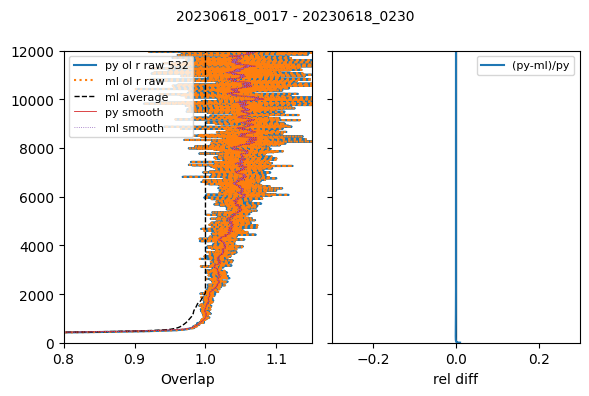

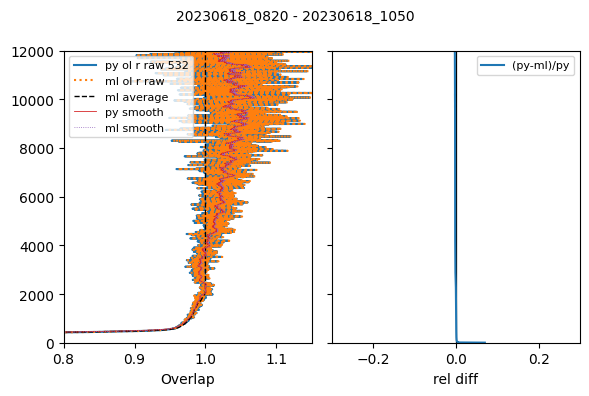

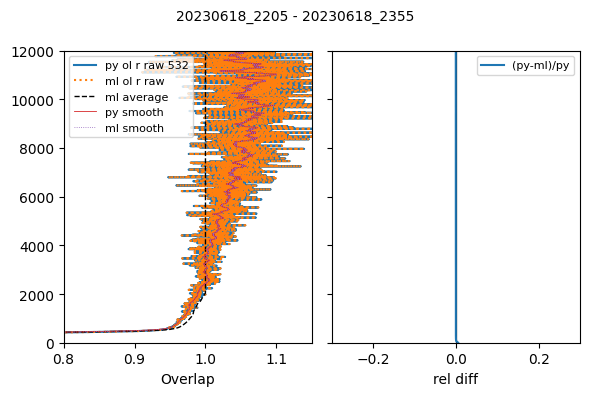

In [68]:
from scipy.ndimage import uniform_filter1d

for wv in [532]:
    for i in range(len(data_cube.data_retrievals['overlap']['raman'])):
        print(data_cube.data_retrievals['overlap']['raman'][i][f'{wv}_total_FR'].keys())
        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        ol_py = data_cube.data_retrievals['overlap']['raman'][i][f'{wv}_total_FR']['olFunc_raw']
        
        ol_ml = np.array(overlap_ml[f'olFunc{wv}_raman_raw_Grp'])[i,:]
        ol_avg_ml = np.array(overlap_ml[f'olFunc532Raman'])[:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        # ax.plot(ol_py_raw, np.array(data_cube.data_retrievals['height']), 
        #         color='b', label=f'py overlap {wv}')
        ax.plot(ol_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py ol r raw {wv}')
        ax.plot(ol_ml, np.array(overlap_ml['height']), 
                color='C1', ls=':', label='ml ol r raw')
        ax.plot(ol_avg_ml, np.array(overlap_ml['height']), 
                color='k', lw=1, ls='--', label='ml average')
        
        ax.plot(uniform_filter1d(ol_py, 20), np.array(data_cube.data_retrievals['height']), 
                color='C3', lw=0.6, label=f'py smooth')
        ax.plot(uniform_filter1d(ol_ml, 20), np.array(data_cube.data_retrievals['height']), 
                color='C4', ls=':', lw=0.6, label=f'ml smooth')
        
        #ax.axvline(1, lw=0.8, color='dimgrey')
        
        ax.set_ylim(0, 12000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8, loc='upper left')
        ax.set_xlabel('Overlap')
        ax.set_xlim([0.80, 1.15])
    
        reldiff = (ol_py - ol_ml)/ol_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.3, 0.3); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # # fig.savefig('mSig_rayleigh_fit.png')

In [69]:
data_cube.polly_config_dict['overlapCorMode'] = 2
data_cube.polly_config_dict['overlapCalMode'] = 1
data_cube.polly_config_dict['overlapCalMode'] = 2

In [70]:
data_cube.overlapCor()

2025-02-28 17:53:22,424 - INFO - overlap Correction


overlapCorMode  2  overlapCalMode  2
dict_keys(['frnr', 'raman'])
overlap correction source raman
[array(['2023-06-18T00:17:30.000000', '2023-06-18T02:30:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T08:20:00.000000', '2023-06-18T10:50:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T22:05:00.000000', '2023-06-18T23:55:00.000000'],
      dtype='datetime64[us]')] ['2023-06-18T00:17:30.000000' '2023-06-18T02:30:00.000000'
 '2023-06-18T08:20:00.000000' '2023-06-18T10:50:00.000000'
 '2023-06-18T22:05:00.000000' '2023-06-18T23:55:00.000000']
[[35, 300], [1000, 1300], [2650, 2870]]
532_total_FR len(olFuncs) 3
(6, 3000)
(2880, 3000)
355_total_FR len(olFuncs) 3
(6, 3000)
(2880, 3000)
correct overlap 355
correct overlap 387
using 355 instead of 387
correct overlap 532
correct overlap 607
using 532 instead of 607
correct overlap 1064
using 532 instead of 1064


dict_keys(['532_total_FR', '355_total_FR'])


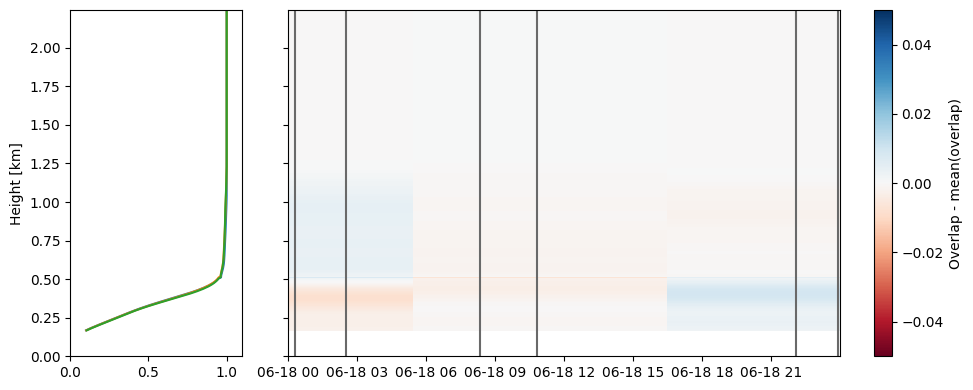

In [71]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 4]}, sharey=True)

print(data_cube.data_retrievals['overlap2d'].keys())
overlap2d = data_cube.data_retrievals['overlap2d']['532_total_FR']
height = np.array(data_cube.data_retrievals['height'])/1000

for e in data_cube.clFreeGrps:
    ax.plot(overlap2d[e[0],:], height)
    
ax.set_ylim(0, height[300])
ax.set_xlim(0, 1.1)
# ax.set_xlim(0.8, 1.1)
ax.set_ylabel('Height [km]')

overlap_dev = overlap2d - np.mean(overlap2d, axis=0)
pcmesh = ax1.pcolormesh(
    data_cube.data_retrievals['time64'], height[:300], 
    overlap_dev[:,:300].T, shading='nearest',
    vmin=-0.05, vmax=0.05, cmap='RdBu',
    )

cbar = fig.colorbar(pcmesh)
cbar.set_label('Overlap - mean(overlap)')

for sl in data_cube.clFreeGrps:
    ax1.axvline(data_cube.data_retrievals['time64'][sl[0]], color='dimgrey')
    ax1.axvline(data_cube.data_retrievals['time64'][sl[1]], color='dimgrey')

fig.tight_layout()



dict_keys(['sigOLCor355', 'sigOLCor387', 'sigOLCor532', 'sigOLCor607', 'sigOLCor1064', 'bgOLCor532', 'height'])
(3000,)
(3000,)
(3000,)
(3000,)
(3000,)


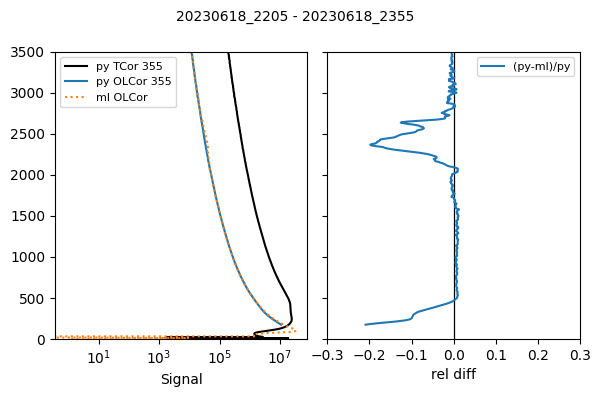

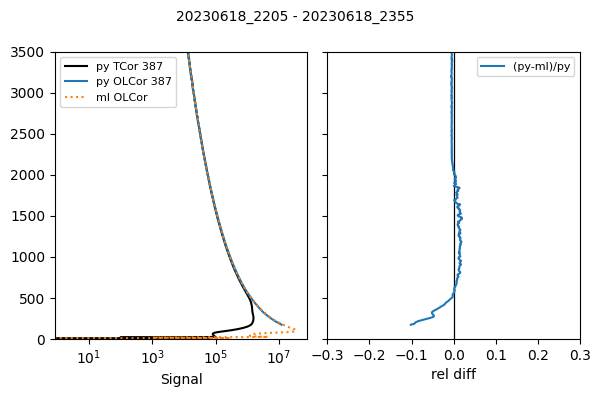

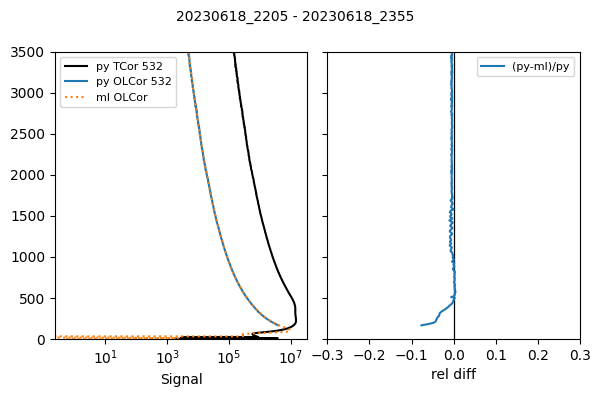

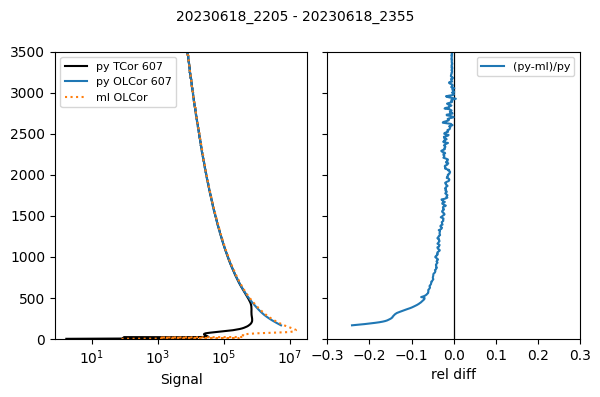

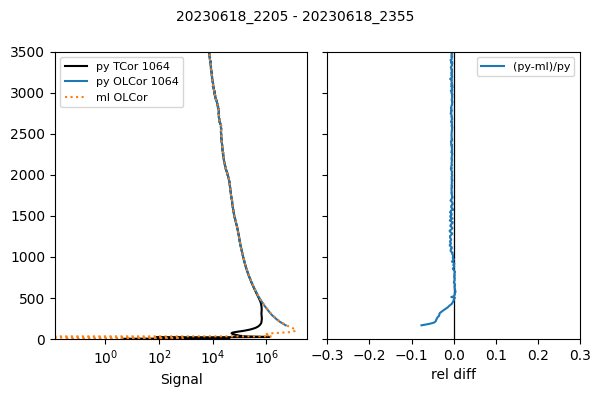

In [72]:
with open('20230618_0000_sigOLCor_matlab.pickle', 'rb') as f:
    OLcor_ml = pickle.load(f)
print(OLcor_ml.keys())


for wv in [355, 387, 532, 607, 1064]:
    #wv, t, tel = 532, 'total', 'FR'
    t, tel = 'total', 'FR'

    cldFree = data_cube.clFreeGrps[-1]
    signal_tcor = np.nansum(np.squeeze(data_cube.data_retrievals['sigTCor'][slice(*cldFree),:,data_cube.gf(wv, t, tel)]), axis=0)
    signal_OLcor = np.nansum(np.squeeze(data_cube.data_retrievals['sigOLCor'][slice(*cldFree),:,data_cube.gf(wv, t, tel)]), axis=0)
    
    signal_OLcor_ml = np.array(OLcor_ml[f'sigOLCor{wv}'])[-1,:]
    print(signal_OLcor_ml.shape)
    
    # print(eng.eval("""
    # sig = transpose(squeeze(sum(data.sigOLCor532(:, clFreGrps(iGrp, 1):clFreGrps(iGrp, 2)), 2)));
    # sum(sig(1001:1501))
    # """, nargout=0))
    
    
    fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
    ax.axvline(0, lw=0.8, color='dimgrey')
    
    ax.plot(signal_tcor, np.array(data_cube.data_retrievals['height']), 
            color='k', label=f'py TCor {wv}')
    ax.plot(signal_OLcor, np.array(data_cube.data_retrievals['height']), 
            color='C0', label=f'py OLCor {wv}')
    ax.plot(signal_OLcor_ml, np.array(OLcor_ml['height']), 
            color='C1', ls=':', label='ml OLCor')
    # ax.plot(ol_avg_ml, np.array(overlap_ml['height']), 
    #         color='k', lw=1, ls='--', label='ml average')
    
    ax.set_ylim(0, 3500)
    ax.set_xscale('log')
    ax.legend(fontsize=8, loc='upper left')
    ax.set_xlabel('Signal')
    # ax.set_xlim([0.80, 1.15])
    
    reldiff = (signal_OLcor - signal_OLcor_ml)/signal_OLcor
    ax1.axvline(0, lw=0.9, color='k')
    ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
    ax1.legend(fontsize=8)
    # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
    ax1.set_xlim(-0.3, 0.3); ax1.set_xlabel('rel diff')
    fig.suptitle(tstr, fontsize=10)
    fig.tight_layout()
    # # # # fig.savefig('mSig_rayleigh_fit.png')

In [73]:
# with open('20230618_0000_sigOLCor_matlab.pickle', 'rb') as f:
#     OLcor_ml = pickle.load(f)
# print(OLcor_ml.keys())

# signal_OLcor_ml = np.array(OLcor_ml[f'sigOLCor532'])[:]

# print('1.7266e+05', np.nansum(signal_OLcor_ml[1000:1500]))


# with open('20230618_0000_sigOLCor_tmp_matlab.pickle', 'rb') as f:
#     OLcor_tmp_ml = pickle.load(f)
# print(OLcor_tmp_ml.keys())

# signal_OLcor_tmp_ml = np.array(OLcor_tmp_ml[f'sigOLCor532'])[:]
# print('1.7266e+05', np.nansum(signal_OLcor_tmp_ml[1000:1500]))


# print('1.7266e+05', np.nansum(signal_OLcor[1000:1500]))


# mean_532_total = np.mean(data_cube.data_retrievals['sigBGCor'][35:300,:,4], axis=0)
# mean_532_cross = np.mean(data_cube.data_retrievals['sigBGCor'][35:300,:,5], axis=0)
# mean_TCor_532_total = np.mean(data_cube.data_retrievals['sigTCor'][35:300,:,4], axis=0)
# mean_OLCor_532_total = np.mean(data_cube.data_retrievals['sigOLCor'][35:300,:,4], axis=0)

# with open('20230618_0000_sigTCor_matlab.pickle', 'rb') as f:
#     sigTCor_ml = pickle.load(f)
# print(sigTCor_ml.keys())
# mean_TCor_532_total_ml = np.mean(sigTCor_ml['el532'][:, 36:301], axis=1)

# print(OLcor_tmp_ml['sigOLCor532_2d'].shape)
# mean_OLCor_532_total_ml = np.mean(OLcor_tmp_ml['sigOLCor532_2d'][:, 36:301], axis=1)


# fig, ax = plt.subplots(1, figsize=(4, 6))
# ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py sigBGCor total')
# ax.plot(mean_532_cross, np.array(data_cube.data_retrievals['height']), color='C0', ls=':', label='cross')

# ax.plot(mean_OLCor_532_total, np.array(data_cube.data_retrievals['height']), color='red', ls='-', label='py mean_OLCor_532')

# ax.plot(mean_TCor_532_total_ml, np.array(sigTCor_ml['height']), color='C1', label='ml el532 (TCor) total')
# # ax.plot(comp_ml['sig532c_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', ls=':', label='cross')

# ax.plot(mean_TCor_532_total, np.array(data_cube.data_retrievals['height']), color='C2', ls=':', label='py sigTCor total')

# ax.plot(mean_OLCor_532_total_ml, np.array(data_cube.data_retrievals['height']), color='red', ls=':', label='mean_OLCor_532_total_ml')

# ax.set_ylim(0, 8000)
# ax.set_xscale('log')
# ax.legend(fontsize=8)

In [74]:
data_cube.retrievalKlett(oc=True)

2025-02-28 17:53:53,262 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-02-28 17:53:53,265 - WARNING - at 10km height this is a difference of about 4 indices


retrievalname klett_OC
Starting Klett retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
== 532, total, FR klett =================================
(266, 3000, 1)
refHInd [675, 875] refH [5066.25 6566.25]
LR  50 [5066.25 6566.25] refBeta 1e-08 smoothWin_klett 21
indRefH  [675 875]
indRefH [675 875] 775
refH slice shape  (201,)
RCS[indRefMid]  52460.92954126816
mean(mBsc) 0.0008797481113861896 1e-05
aerBR[indRefMid]  0.011373578901245502
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval'])
== 355, total, FR klett =================================
(266, 3000, 1)
refHInd [973, 1172] refH [7301.25 8793.75]
LR  50 [7301.25 8793.75] refBeta 2e-08 smoothWin_klett 21
indRefH  [ 973 1172]
indRefH [ 973 1172] 1073
refH slice shape  (200,)
RCS[indRefMid]  70354.41206126122
mean(mBsc) 0.003458400642193114 2e-05
aerBR[indRefMid]  0.005796769106104807
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', '

/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/tests/../lib/retrievals/klettfernald.py:167: RuntimeWarning: invalid value encountered in scalar divide
  denominator1 = RCS[iAlt + 1] / (aerBsc[iAlt + 1] + molBsc[iAlt + 1])


(301, 3000, 1)
refHInd [962, 1162] refH [7218.75 8718.75]
LR  50 [7218.75 8718.75] refBeta 1e-08 smoothWin_klett 21
indRefH  [ 962 1162]
indRefH [ 962 1162] 1062
refH slice shape  (201,)
RCS[indRefMid]  43044.39361833974
mean(mBsc) 0.0006597205035191932 1e-05
aerBR[indRefMid]  0.015181897554444804
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval'])
== 355, total, FR klett =================================
(301, 3000, 1)
refHInd [773, 973] refH [5801.25 7301.25]
LR  50 [5801.25 7301.25] refBeta 2e-08 smoothWin_klett 21
indRefH  [773 973]
indRefH [773 973] 873
refH slice shape  (201,)
RCS[indRefMid]  104597.28397602121
mean(mBsc) 0.004261153524042991 2e-05
aerBR[indRefMid]  0.004701591872470641
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval'])
== 1064, total, FR klett =================================
(301, 3000, 1)
refHInd [583, 783] refH [4376.25 5876.

dict_keys(['aerBsc355_OC_klett', 'aerBsc532_OC_klett', 'aerBsc1064_OC_klett', 'aerExt532_OC_klett', 'height'])
[973, 1172] [7273.48080932 8760.30139623]
[773, 973] [5779.18876219 7273.48080932]
[773, 973] [5779.18876219 7273.48080932]
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[734, 934] [5487.801813   6982.09386013]
[721, 921] [5390.67282993 6884.96487707]
[583, 783] [4359.61131741 5853.90336454]
[533, 733] [3986.03830562 5480.33035276]


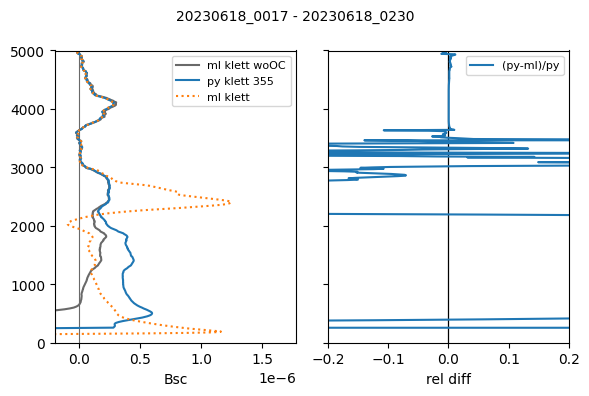

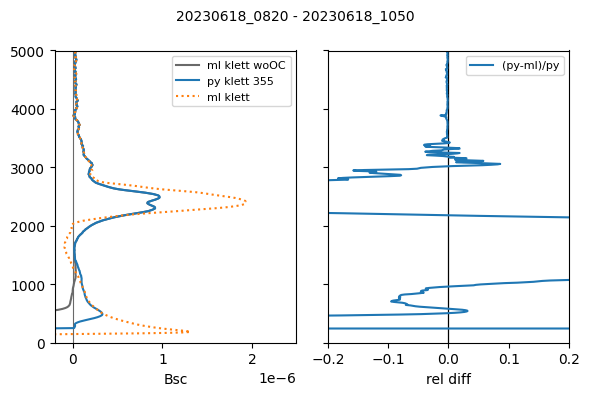

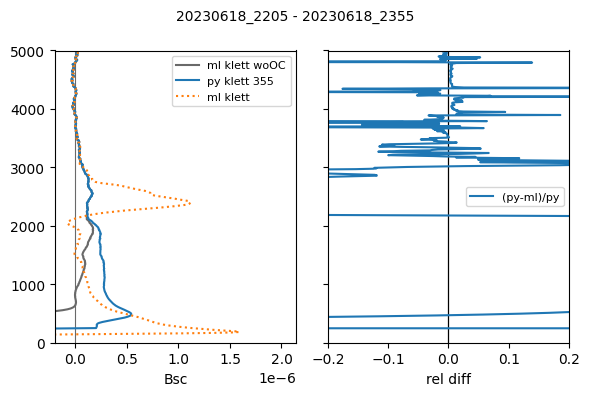

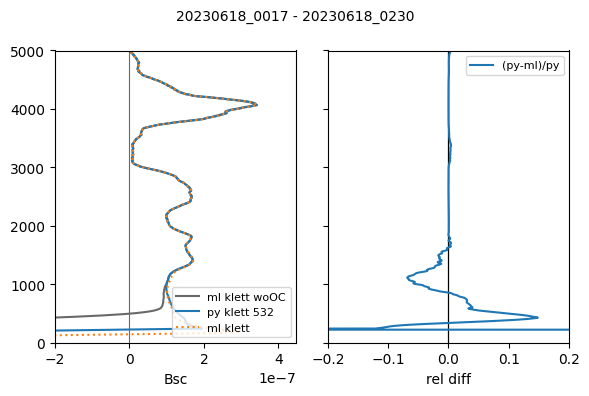

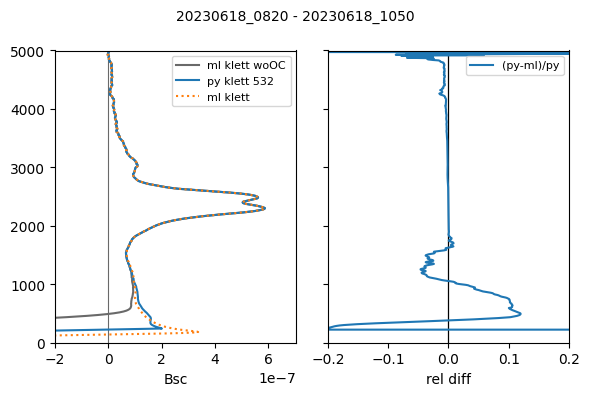

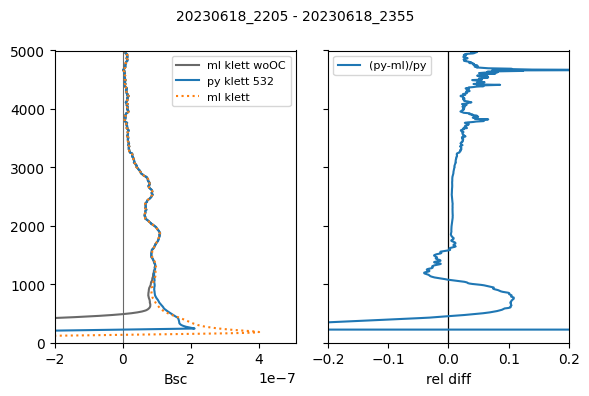

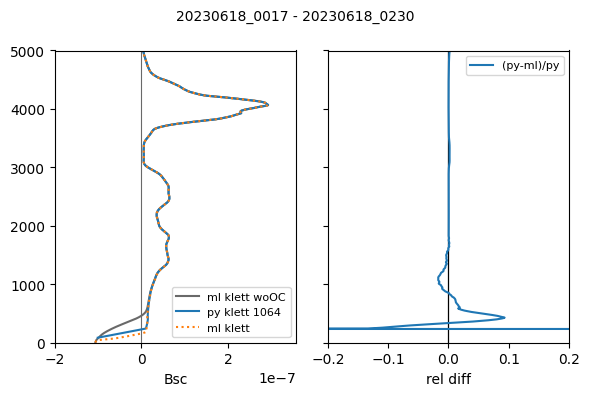

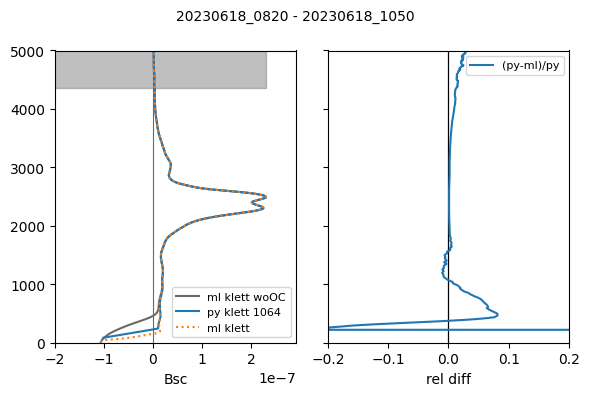

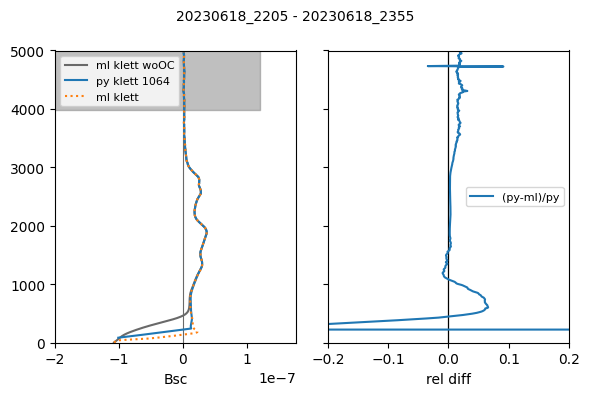

In [75]:
with open('20230618_0000_beta_OC_klett_matlab.pickle', 'rb') as f:
    beta_OC_klett_ml = pickle.load(f)
print(beta_OC_klett_ml.keys())


for wv in [355,532,1064]:
    for i in range(len(data_cube.data_retrievals['klett_OC'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
        
        beta_py = data_cube.data_retrievals['klett_OC'][i][f'{wv}_total_FR']['aerBsc']
        beta_std_ml = np.array(beta_klett_ml[f'aerBsc{wv}_klett'])[i,:]
        beta_ml = np.array(beta_OC_klett_ml[f'aerBsc{wv}_OC_klett'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        ax.fill_between([-1e-6, np.nanmax(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
                        color='grey', alpha=0.5)
        ax.plot(beta_std_ml, np.array(beta_klett_ml['height']), 
                color='dimgrey', ls='-', label='ml klett woOC')
        ax.plot(beta_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py klett {wv}')
        ax.plot(beta_ml, np.array(beta_klett_ml['height']), 
                color='C1', ls=':', label='ml klett')
        
        ax.set_ylim(0, 5000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Bsc')
        ax.set_xlim(left=-0.2e-6)
    
        reldiff = (beta_py - beta_ml)/beta_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.2, 0.2); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')

In [76]:
data_cube.retrievalRaman(oc=True)

2025-02-28 17:54:07,492 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-02-28 17:54:07,494 - WARNING - at 10km height this is a difference of about 4 indices
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/tests/../lib/retrievals/raman.py:198: RuntimeWarning: divide by zero encountered in divide
  temp_MC = number_density / (signal_gen[i] * height**2)
/mnt/c/Users/radenz/dev/PicassoPy/pyppc_env/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1899: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


[array([ 183., 1300.,  183., 1300.,  168., 1000.,  168.,  168.,  150.,
        150.,  150.,  150.,  150.]), array([ 176., 1300.,  176., 1300.,  168., 1000.,  168.,  168.,  150.,
        150.,  150.,  150.,  150.]), array([ 176., 1300.,  176., 1300.,  168., 1000.,  168.,  168.,  150.,
        150.,  150.,  150.,  150.])]
Starting Raman retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
== 355, total, FR | 387, total, FR raman ========
shape sig (266, 3000, 1)
183.0 491.25
refHInd [973, 1172] refH [7301.25 8793.75] hBaseInd 90 hBase 678.75
SNRRef [468.7337970936977] SNRRef_r [514.1316462372132]
high enough to continue
filling below overlap with 3.0782758060038486e-05
== 532, total, FR | 607, total, FR raman ========
shape sig (266, 3000, 1)
168.0 491.25
refHInd [675, 875] refH [5066.25 6566.25] hBaseInd 88 hBase 663.75
SNRRef [564.0877832710449] SNRRef_r [741.5686512111764]
high enough to continue
filling below overlap with 1.4131423497570751e-05
== 1064, total, FR | 607, total, FR ram

In [77]:
print(data_cube.data_retrievals['avail_optical_profiles'])

['klett', 'raman', 'klett_OC', 'raman_OC']


dict_keys(['aerExt355_raman', 'aerExt532_raman', 'aerExt1064_raman', 'aerBsc355_raman', 'aerBsc532_raman', 'aerBsc1064_raman', 'LR355_raman', 'LR532_raman', 'LR1064_raman', 'height'])
dict_keys(['aerExt355_OC_raman', 'aerExt532_OC_raman', 'aerExt1064_OC_raman', 'aerBsc355_OC_raman', 'aerBsc532_OC_raman', 'aerBsc1064_OC_raman', 'LR355_OC_raman', 'LR532_OC_raman', 'LR1064_OC_raman', 'height'])
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[734, 934] [5487.801813   6982.09386013]
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[734, 934] [5487.801813   6982.09386013]


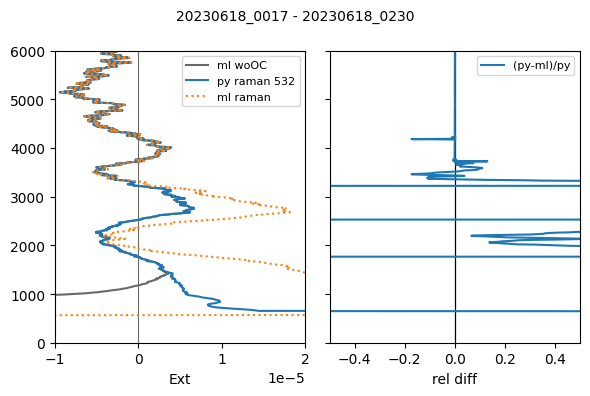

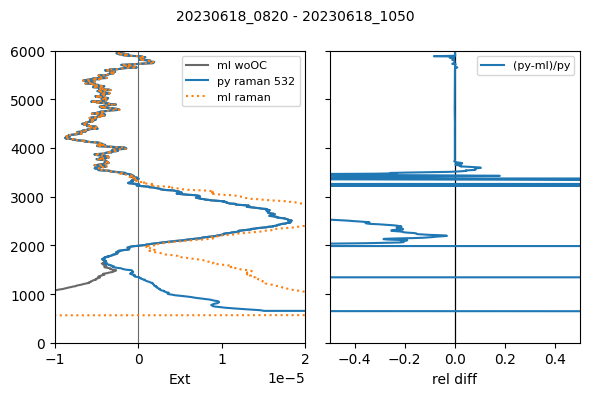

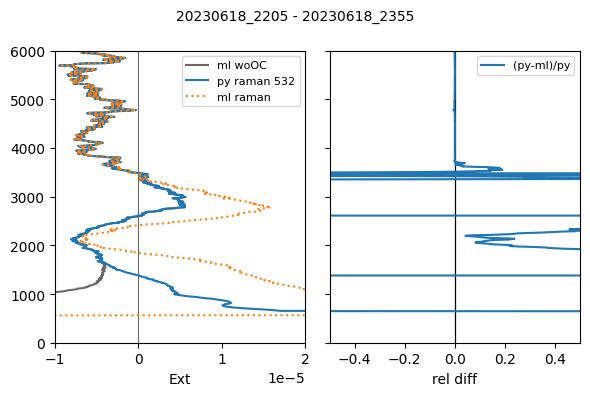

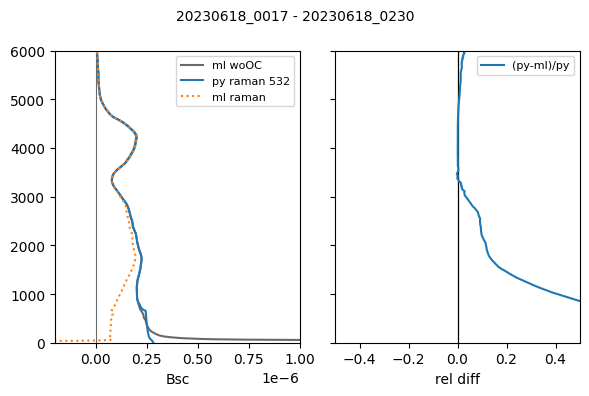

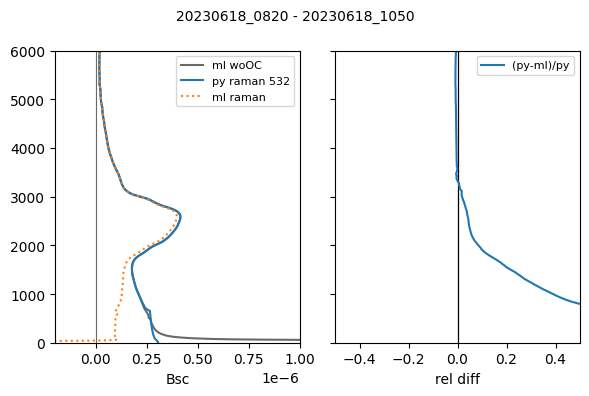

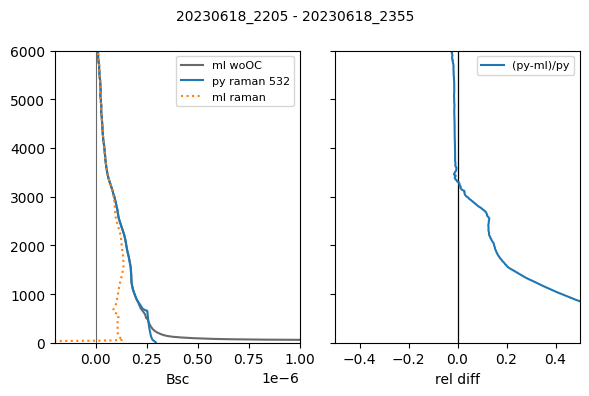

In [78]:

with open('20230618_0000_raman_matlab.pickle', 'rb') as f:
    raman_ml = pickle.load(f)
print(raman_ml.keys())

with open('20230618_0000_raman_OC_matlab.pickle', 'rb') as f:
    raman_OC_ml = pickle.load(f)
print(raman_OC_ml.keys())



# for wv in [355,532,1064]:
for wv in [532]:
    for i in range(len(data_cube.data_retrievals['raman_OC'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
           
        ext_py = data_cube.data_retrievals['raman_OC'][i][f'{wv}_total_FR']['aerExt']
        ext_std_ml = np.array(raman_ml[f'aerExt{wv}_raman'])[i,:]
        ext_ml = np.array(raman_OC_ml[f'aerExt{wv}_OC_raman'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(ext_std_ml, np.array(beta_klett_ml['height']), 
                color='dimgrey', ls='-', label='ml woOC')
        ax.plot(ext_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py raman {wv}')
        ax.plot(ext_ml, np.array(raman_ml['height']), 
                color='C1', ls=':', label='ml raman')
        
        ax.set_ylim(0, 6000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Ext')
        ax.set_xlim([-0.1e-4, 0.2e-4])
        # ax.set_xlim([-0.1e-4, 2e-2])
    
        reldiff = (ext_py - ext_ml)/ext_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.5, 0.5); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')

    
    for i in range(len(data_cube.data_retrievals['raman_OC'])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
           
        bsc_py = data_cube.data_retrievals['raman_OC'][i][f'{wv}_total_FR']['aerBsc']
        bsc_std_ml = np.array(raman_ml[f'aerBsc{wv}_raman'])[i,:]
        bsc_ml = np.array(raman_OC_ml[f'aerBsc{wv}_OC_raman'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(bsc_std_ml, np.array(beta_klett_ml['height']), 
                color='dimgrey', ls='-', label='ml woOC')
        ax.plot(bsc_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py raman {wv}')
        ax.plot(bsc_ml, np.array(raman_ml['height']), 
                color='C1', ls=':', label='ml raman')
        
        ax.set_ylim(0, 6000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Bsc')
        ax.set_xlim([-0.2e-6, 1e-6])
    
        reldiff = (bsc_py - bsc_ml)/bsc_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.5, 0.5); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')


In [79]:
import lib.retrievals.raman as raman
import lib.retrievals.ramanhelpers as ramanhelpers

cldFree = data_cube.clFreeGrps[0]
cldFree = cldFree[0], cldFree[1] + 1
wv, t, tel = 532, 'total', 'FR'
wv_r = 607
signal = 'OLCor'
# signal = 'TCor'
config_dict=data_cube.polly_config_dict

sig = np.nansum(np.squeeze(
    data_cube.data_retrievals[f'sig{signal}'][slice(*cldFree),:,data_cube.gf(wv, t, tel)]), axis=0)
print('shape sig', data_cube.data_retrievals[f'sig{signal}'][slice(*cldFree),:,data_cube.gf(wv, t, tel)].shape)
bg = np.nansum(np.squeeze(
    data_cube.data_retrievals[f'BG{signal}'][slice(*cldFree),data_cube.gf(wv, t, tel)]), axis=0)
molBsc = data_cube.mol_profiles[f'mBsc_{wv}'][i,:]
molExt = data_cube.mol_profiles[f'mExt_{wv}'][i,:]

sig_r = np.nansum(np.squeeze(
    data_cube.data_retrievals[f'sig{signal}'][slice(*cldFree),:,data_cube.gf(wv_r, t, tel)]), axis=0)
bg_r = np.nansum(np.squeeze(
    data_cube.data_retrievals[f'BG{signal}'][slice(*cldFree),data_cube.gf(wv_r, t, tel)]), axis=0)
molBsc_r = data_cube.mol_profiles[f'mBsc_{wv_r}'][i,:]
molExt_r = data_cube.mol_profiles[f'mExt_{wv_r}'][i,:]
number_density = data_cube.mol_profiles[f'number_density'][i,:]


prof = raman.raman_ext(
    height, sig_r, wv, wv_r, molExt, molExt_r,
    number_density, config_dict[f'angstrexp'], config_dict[f'smoothWin_raman_{wv}'], 
    'moving', 15, bg_r
    )

shape sig (266, 3000, 1)


131 982.5
(3000,)
(3001,)


(-0.01, 0.06)

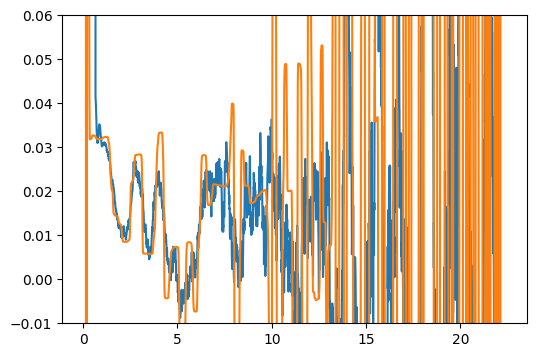

In [80]:
temp = number_density / (sig_r * height**2)
temp[temp <= 0] = np.nan
ratio = np.log(temp)

angstrom = config_dict[f'angstrexp']
window_size=config_dict[f'smoothWin_raman_{wv}']
print(window_size, window_size*7.5)
window_size=131
deriv_ratio = ramanhelpers.movingslope_variedWin(ratio, window_size) / \
         np.concatenate([[height[1] - height[0]], np.diff(height)])


from diff_tvr import DiffTVR
diff_tvr = DiffTVR(ratio.shape[0], height[1] - height[0])

print(ratio.shape)
(deriv,_) = diff_tvr.get_deriv_tvr(
    data=ratio.data, 
    deriv_guess=np.full(ratio.shape[0]+1,0.0), 
    alpha=0.005,
    no_opt_steps=9
    )

print(deriv.shape)


# Compute aerosol extinction coefficient
ext_aer = (deriv_ratio - molExt - molExt_r) / \
          (1 + (wv / wv_r) ** angstrom)

fig, ax = plt.subplots(1, figsize=(6,4))

ax.plot(height, deriv_ratio)
ax.plot(height, deriv[:-1])

ax.set_ylim(-20,2)
ax.set_ylim(-0.01,6e-2)
# ax.set_xlim(right=10)

(-0.05, 0.05)

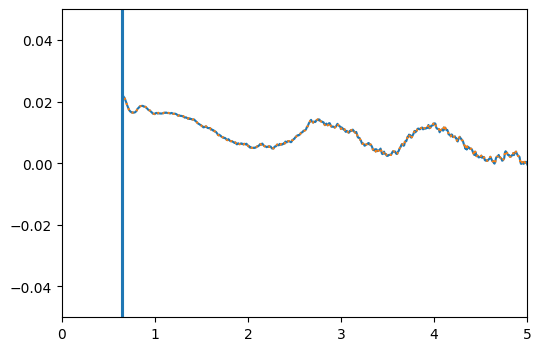

In [81]:
fig, ax = plt.subplots(1, figsize=(6,4))

# ax.plot(height, ref)
ax.plot(height, prof['aerExt'])
ax.plot(height, ext_aer, ':')
ax.set_xlim(0,5)
ax.axvline((150+window_size*7.5/2)/1000)
ax.axvline(660/1000)

ax.set_ylim(-0.05,0.05)


In [82]:
data_cube.pol_cali[355]['eta_best'] = 19.334585
data_cube.pol_cali[532]['eta_best'] = 28.762348

In [83]:
# data_cube.calcDepol()

ret_prof_name = 'klett'

import lib.retrievals.depolarization as depolarization 
data_cube.data_retrievals[ret_prof_name] = depolarization.voldepol_cldFreeGrps(
    data_cube, ret_prof_name) 

# for i, _ in enumerate(data_cube.clFreeGrps):
#     print(i)
    #print(data_cube.data_retrievals[ret_prof_name][i].keys())
    #dict_keys(['532_total_FR', '355_total_FR', '1064_total_FR'])
    # data_cube.data_retrievals[ret_prof_name][i]['355_total_FR']['mdr'] = mdr
    #data_cube.data_retrievals[ret_prof_name][i][channel]['mdrStd'] = mdrStd
    # data_cube.data_retrievals[ret_prof_name][i]['355_total_FR']['mdr'] = mdr

data_cube.data_retrievals[ret_prof_name][0]['355_total_FR']['mdr'] = 0.011311
data_cube.data_retrievals[ret_prof_name][1]['355_total_FR']['mdr'] = 0.011577
data_cube.data_retrievals[ret_prof_name][2]['355_total_FR']['mdr'] = 0.011577

data_cube.data_retrievals[ret_prof_name][0]['532_total_FR']['mdr'] = 0.002763
data_cube.data_retrievals[ret_prof_name][1]['532_total_FR']['mdr'] = 0.002714
data_cube.data_retrievals[ret_prof_name][2]['532_total_FR']['mdr'] = 0.002678

data_cube.data_retrievals[ret_prof_name] = depolarization.pardepol_cldFreeGrps(
    data_cube, ret_prof_name) 



2025-02-28 17:55:25,097 - INFO - voldepol at channel 532 cldFree 0 (35, 301)
2025-02-28 17:55:25,127 - INFO - voldepol at channel 355 cldFree 0 (35, 301)
2025-02-28 17:55:25,148 - INFO - voldepol at channel 532 cldFree 1 (1000, 1301)
2025-02-28 17:55:25,184 - INFO - voldepol at channel 355 cldFree 1 (1000, 1301)
2025-02-28 17:55:25,208 - INFO - voldepol at channel 532 cldFree 2 (2650, 2871)
2025-02-28 17:55:25,244 - INFO - voldepol at channel 355 cldFree 2 (2650, 2871)
2025-02-28 17:55:25,264 - INFO - pardepol at channel 532 cldFree 0 (35, 301)
2025-02-28 17:55:25,268 - INFO - pardepol at channel 355 cldFree 0 (35, 301)
2025-02-28 17:55:25,271 - INFO - pardepol at channel 532 cldFree 1 (1000, 1301)
2025-02-28 17:55:25,275 - INFO - pardepol at channel 355 cldFree 1 (1000, 1301)
2025-02-28 17:55:25,278 - INFO - pardepol at channel 532 cldFree 2 (2650, 2871)
2025-02-28 17:55:25,281 - INFO - pardepol at channel 355 cldFree 2 (2650, 2871)


no_profiles  3
dict_keys(['532_total_FR', '355_total_FR', '1064_total_FR', '532_total_NR', '355_total_NR'])
532_total_FR 28.762348
G [1.] [1.] H [-0.0430622] [-0.99600798] Eta 28.762348 error [0.004 0.    0.   ] Window 21 
est. mdr 532_total_FR  0.0027437000951057644 0.004000000000000001
G [1.] [1.] H [-0.0430622] [-0.99600798] Eta 28.762348 error [0.004 0.    0.   ] Window 1 
est. mdr 532_total_FR  0.0027471759039169596 0.004000000000000001  (smooth1)
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd'])
355_total_FR 19.334585
G [1.] [1.] H [0.18343195] [-0.99600798] Eta 19.334585 error [0.003 0.    0.   ] Window 21 
est. mdr 355_total_FR  0.01131230966119189 0.003
G [1.] [1.] H [0.18343195] [-0.99600798] Eta 19.334585 error [0.003 0.    0.   ] Window 1 
est. mdr 355_total_FR  0.011315795870517354 0.003  (smooth1)
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'm

dict_keys(['vdr355_klett', 'vdr355_raman', 'vdr532_klett', 'vdr532_raman', 'pdr355_klett', 'pdr355_raman', 'pdr355_OC_klett', 'pdr355_OC_raman', 'pdr532_klett', 'pdr532_raman', 'pdr532_OC_klett', 'pdr532_OC_raman', 'mdr355', 'aerBsc355_klett', 'mBsc355', 'mdr532', 'aerBsc532_klett', 'mBsc532', 'height'])
[973, 1172] [7273.48080932 8760.30139623]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd'])
-1.3441993315157253e-06
[773, 973] [5779.18876219 7273.48080932]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd'])
-3.215518648492272e-07
[773, 973] [5779.18876219 7273.48080932]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd'])
-6.5559255206

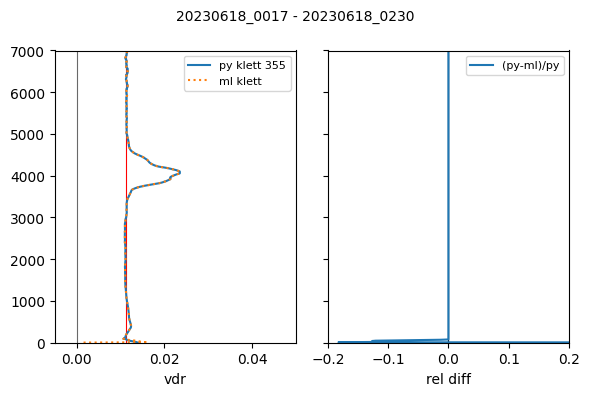

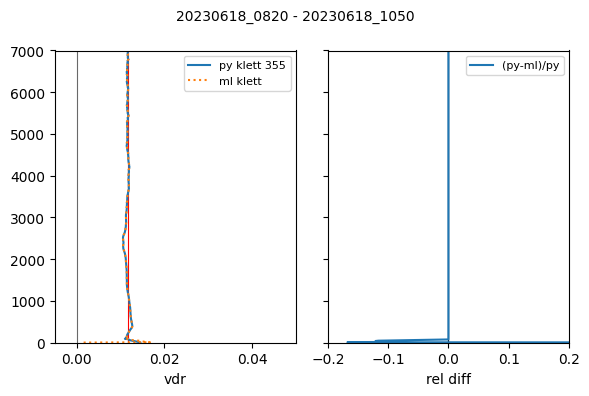

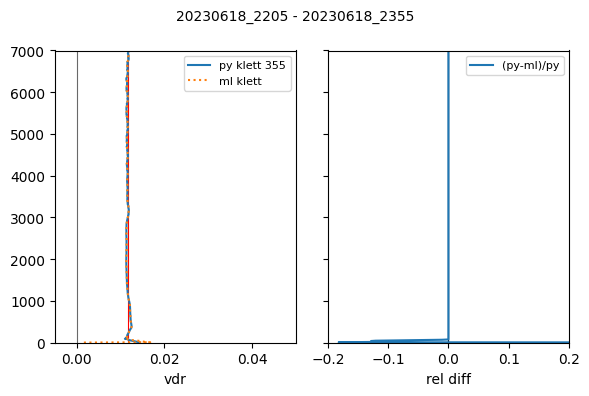

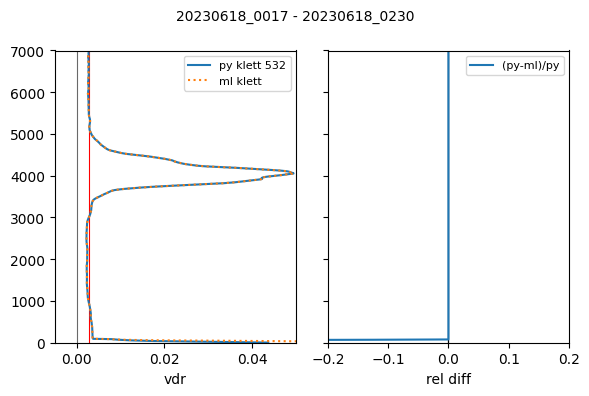

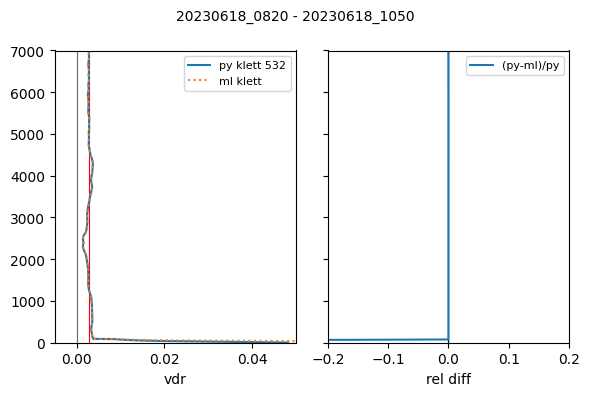

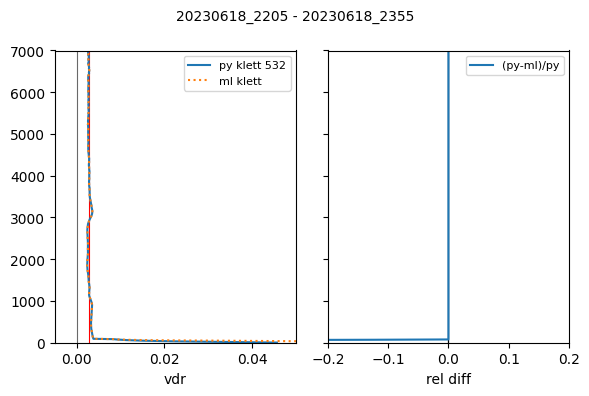

In [84]:
with open('20230618_0000_depol_matlab.pickle', 'rb') as f:
    depol_ml = pickle.load(f)
print(depol_ml.keys())

for wv in [355,532]:
# for wv in [532]:
    retrieval = 'klett'
    for i in range(len(data_cube.data_retrievals[retrieval])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
        print(data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR'].keys())
        
        vdr_py = data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR']['vdr']
        vdr_ml = np.array(depol_ml[f'vdr{wv}_{retrieval}'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        ax.axvline(data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR']['mdr'], lw=0.8, color='r')
        # ax.fill_between([-1e-6, np.nanmax(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                 color='grey', alpha=0.5)
        ax.plot(vdr_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py klett {wv}')
        ax.plot(vdr_ml, np.array(beta_klett_ml['height']), 
                color='C1', ls=':', label='ml klett')
        
        ax.set_ylim(0, 7000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('vdr')
        ax.set_xlim(-0.005, 0.05)
    
        reldiff = (vdr_py - vdr_ml)/vdr_py
        print(np.mean(reldiff[400:600]))
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.2, 0.2); ax1.set_xlabel('rel diff')
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')

[973, 1172] [7273.48080932 8760.30139623]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd'])
[773, 973] [5779.18876219 7273.48080932]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd'])
[773, 973] [5779.18876219 7273.48080932]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd'])
[675, 875] [5046.98565909 6541.27770623]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd'])
[962, 1162] [7191.29474673 8685.58679387]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retriev

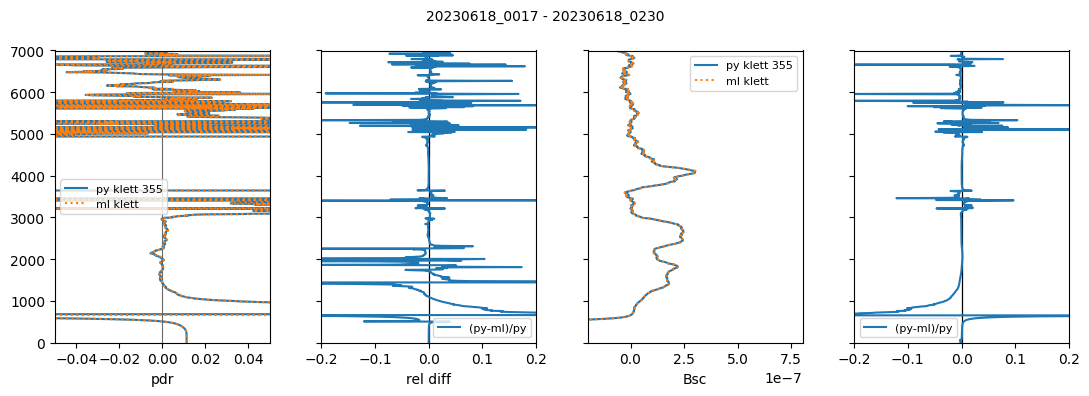

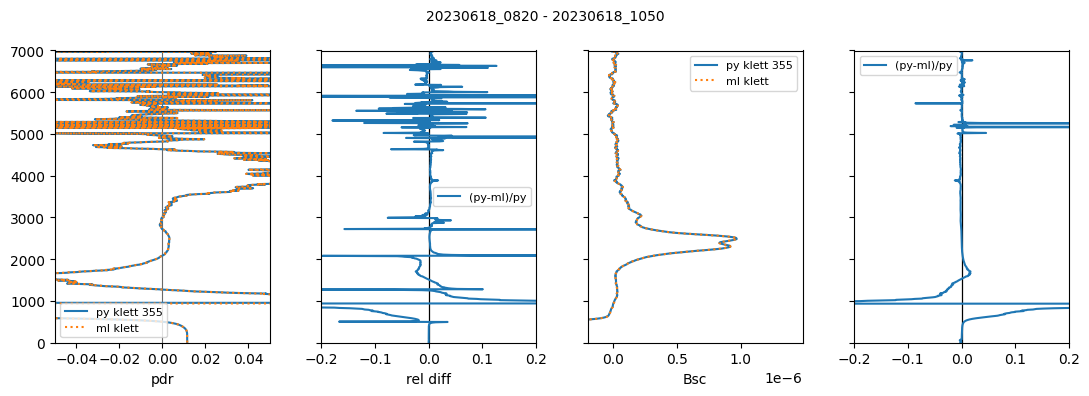

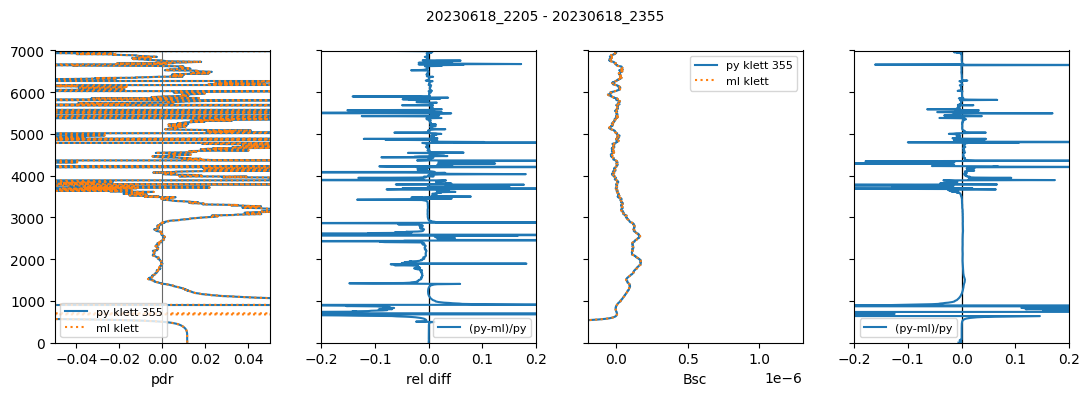

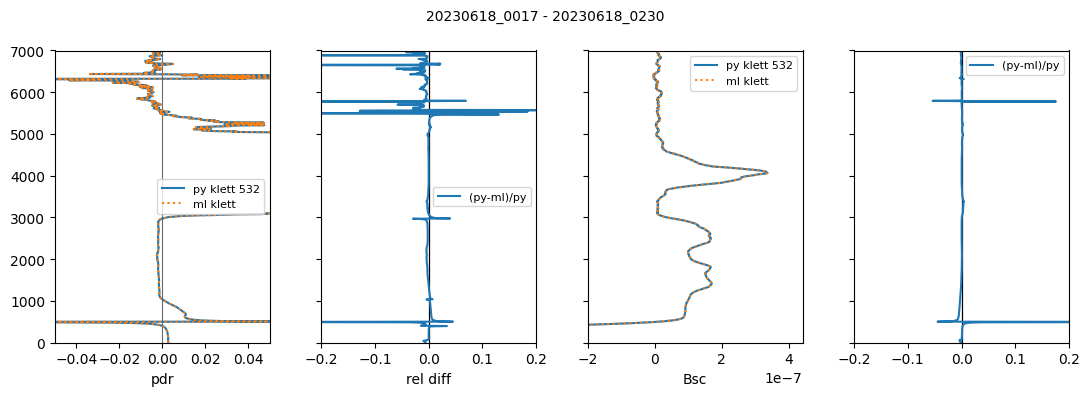

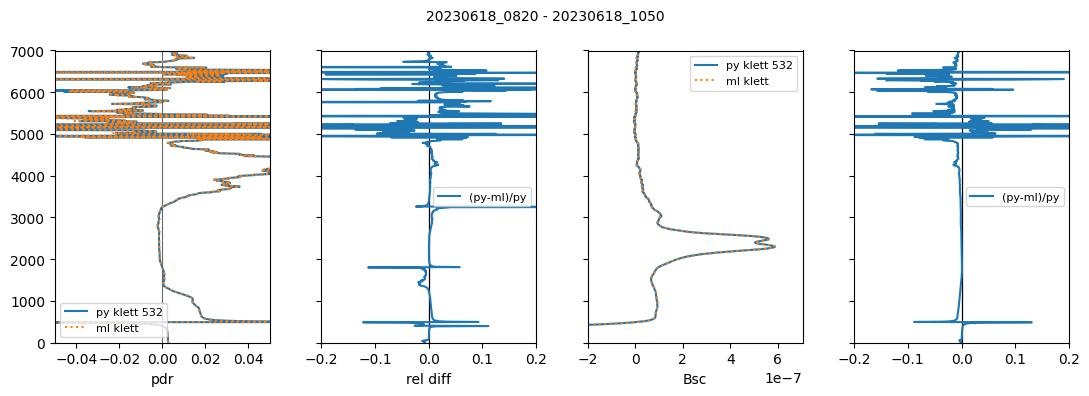

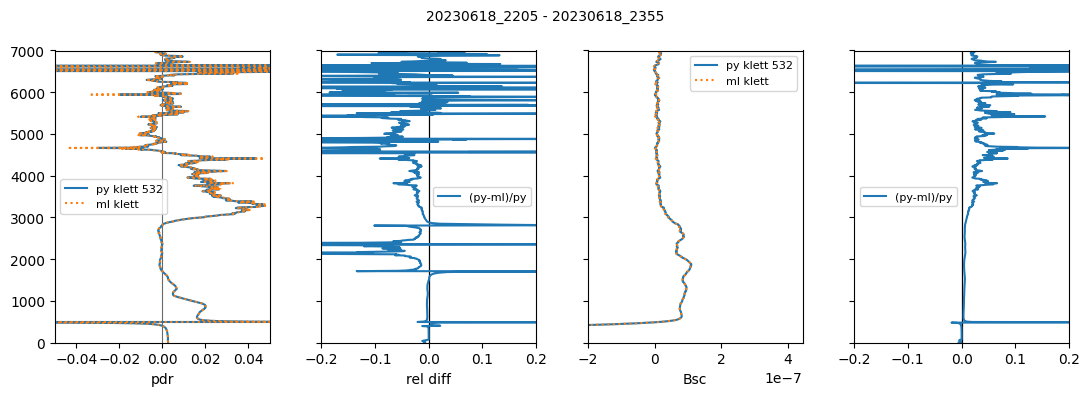

In [85]:
for wv in [355,532]:
# for wv in [532]:
    retrieval = 'klett'
    for i in range(len(data_cube.data_retrievals[retrieval])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
        print(data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR'].keys())
        
        pdr_py = data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR']['pdr']
        pdr_ml = np.array(depol_ml[f'pdr{wv}_{retrieval}'])[i,:]
        fig, (ax, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(11,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        # ax.fill_between([-1e-6, np.nanmax(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                 color='grey', alpha=0.5)
        ax.plot(pdr_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py klett {wv}')
        ax.plot(pdr_ml, np.array(depol_ml['height']), 
                color='C1', ls=':', label='ml klett')
        
        ax.set_ylim(0, 7000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('pdr')
        # ax.set_xlim(left=-0.2e-6)
        ax.set_xlim(-0.1, 0.3)
        ax.set_xlim(-0.05, 0.05)
    
        reldiff = (pdr_py - pdr_ml)/pdr_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.2, 0.2); ax1.set_xlabel('rel diff')

        bsc_py = data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR']['aerBsc']
        bsc_ml = np.array(depol_ml[f'aerBsc{wv}_{retrieval}'])[i,:]
        ax2.plot(bsc_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py klett {wv}')
        ax2.plot(bsc_ml, np.array(depol_ml['height']), 
                color='C1', ls=':', label='ml klett')
        ax2.legend(fontsize=8)
        ax2.set_xlabel('Bsc'); ax2.set_xlim(left=-0.2e-6)

        reldiff = (bsc_py - bsc_ml)/bsc_py
        ax3.axvline(0, lw=0.9, color='k')
        ax3.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax3.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax3.set_xlim(-0.2, 0.2); ax1.set_xlabel('rel diff')

        
        fig.suptitle(tstr, fontsize=10)
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')

In [86]:
data_cube.Angstroem()

klett
channels available 355_total_FR 532_total_FR Bsc
channels available 355_total_NR 532_total_NR Bsc
channels available 532_total_FR 1064_total_FR Bsc
channels available 355_total_FR 532_total_FR Ext
channels available 355_total_NR 532_total_NR Ext
channels available 355_total_FR 532_total_FR Bsc
channels available 355_total_NR 532_total_NR Bsc
channels available 532_total_FR 1064_total_FR Bsc
channels available 355_total_FR 532_total_FR Ext
channels available 355_total_NR 532_total_NR Ext
channels available 355_total_FR 532_total_FR Bsc
channels available 355_total_NR 532_total_NR Bsc
channels available 532_total_FR 1064_total_FR Bsc
channels available 355_total_FR 532_total_FR Ext
channels available 355_total_NR 532_total_NR Ext
raman
channels available 355_total_FR 532_total_FR Bsc
channels available 355_total_NR 532_total_NR Bsc
channels available 532_total_FR 1064_total_FR Bsc
channels available 355_total_FR 532_total_FR Ext
channels available 355_total_NR 532_total_NR Ext
chan

[973, 1172] [7273.48080932 8760.30139623]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd', 'AE_Bsc_355_532', 'AEStd_Bsc_355_532', 'AE_Ext_355_532', 'AEStd_Ext_355_532'])
[773, 973] [5779.18876219 7273.48080932]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd', 'AE_Bsc_355_532', 'AEStd_Bsc_355_532', 'AE_Ext_355_532', 'AEStd_Ext_355_532'])
[773, 973] [5779.18876219 7273.48080932]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd', 'retrieval', 'vdr', 'vdrStd', 'mdr', 'mdrStd', 'pdr', 'pdrStd', 'AE_Bsc_355_532', 'AEStd_Bsc_355_532', 'AE_Ext_355_532', 'AEStd_Ext_355_532'])
[973, 1172] [7273.48080932 8760.30139623]
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt'

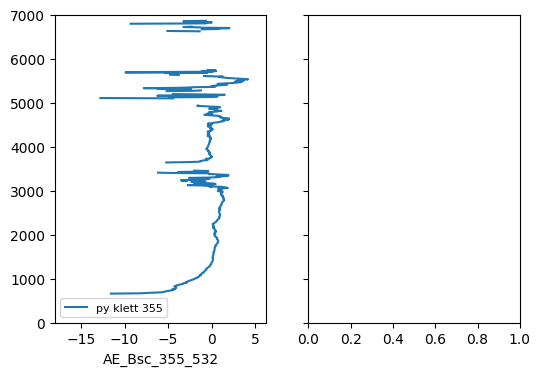

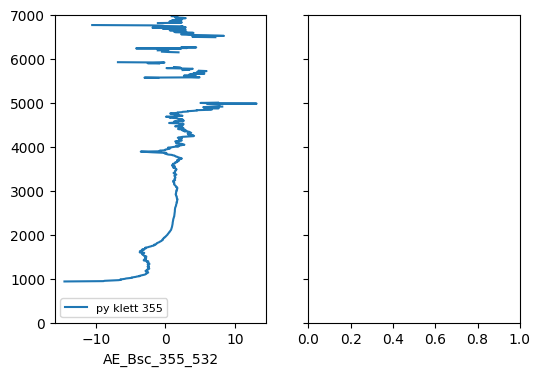

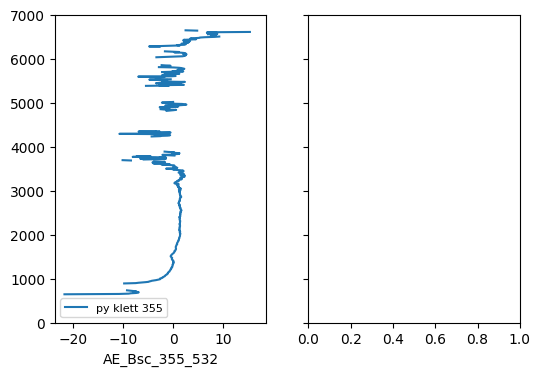

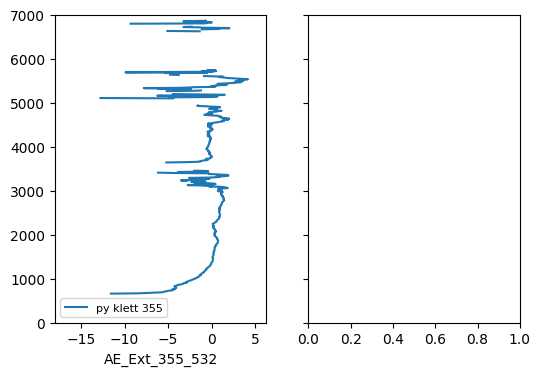

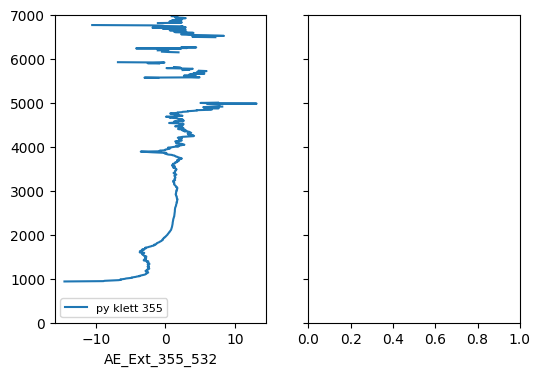

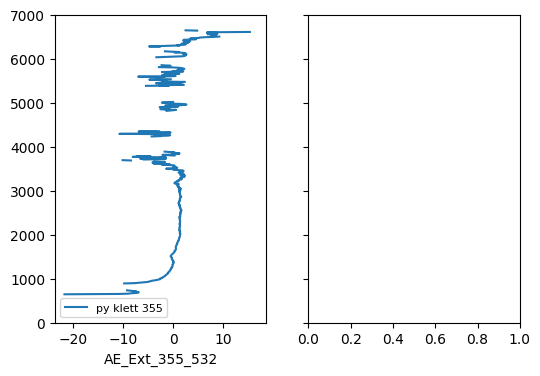

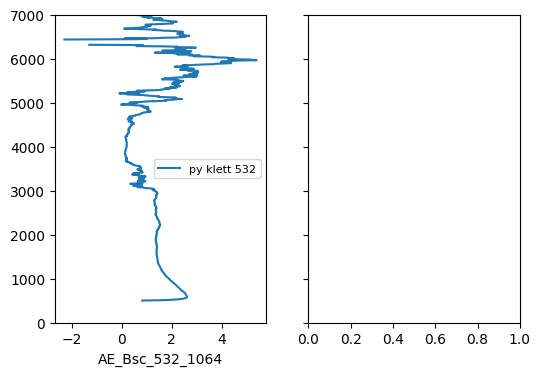

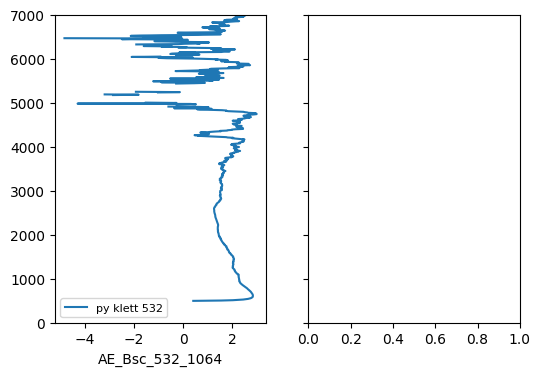

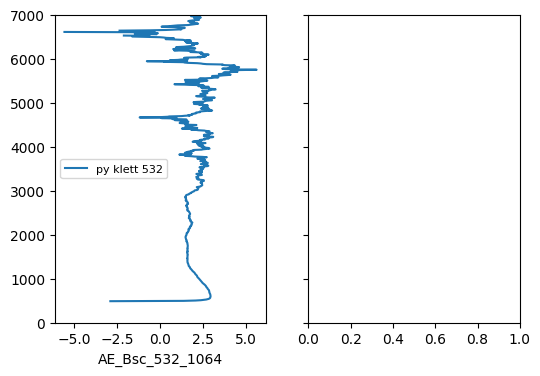

In [87]:
# with open('20230618_0000_depol_matlab.pickle', 'rb') as f:
#     depol_ml = pickle.load(f)
# print(depol_ml.keys())

for wv, var in [(355, 'AE_Bsc_355_532'), (355, 'AE_Ext_355_532'), (532, 'AE_Bsc_532_1064')]:
    retrieval = 'klett'
    for i in range(len(data_cube.data_retrievals[retrieval])):

        tstr = f"{time_slices[i][0]:%Y%m%d_%H%M} - {time_slices[i][1]:%Y%m%d_%H%M}"
        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
        print(data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR'].keys())
        
        ae_py = data_cube.data_retrievals[retrieval][i][f'{wv}_total_FR'][var]
        # ae_ml = np.array(depol_ml[f'vdr{wv}_{retrieval}'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        # ax.fill_between([-1e-6, np.nanmax(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                 color='grey', alpha=0.5)
        ax.plot(ae_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py klett {wv}')
        # ax.plot(ae_ml, np.array(beta_klett_ml['height']), 
        #         color='C1', ls=':', label='ml klett')
        
        ax.set_ylim(0, 7000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel(var)
        # ax.set_xlim(-0.005, 0.05)
    
        # reldiff = (vdr_py - vdr_ml)/vdr_py
        # print(np.mean(reldiff[400:600]))
        # ax1.axvline(0, lw=0.9, color='k')
        # ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        # ax1.legend(fontsize=8)
        # # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        # ax1.set_xlim(-0.2, 0.2); ax1.set_xlabel('rel diff')
        # fig.suptitle(tstr, fontsize=10)
        # fig.tight_layout()
        # # # # fig.savefig('mSig_rayleigh_fit.png')